# prediction major world Indices for using GRU

### Deep Learning for Financial Applications : A Survey에서의 기술을 접목시켰습니다.

### 과거의 데이터를 중심으로 주가를 예측하는 투자 전략으로 모멘텀 투자전략을 적용하였습니다.
### 이 프로젝트에서 사용된 column은 볼린저 밴드,이동평균선(Moving Average),등 저희가 평소에 주식투자를 할때 사용하는 
### 후행성 보조지표를 사용하며, 또한 feature engineering을 통해서 새로운 column을 추가하였습니다.

In [169]:
!pip install IPython

In [170]:
!pip install finance-datareader

In [171]:
import numpy as np 
import pandas as pd 
import os
import FinanceDataReader as fdr
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

# from neuralprophet import NeuralProphet
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,BaggingRegressor
from sklearn.model_selection import train_test_split,StratifiedKFold,KFold
from sklearn.metrics import mean_squared_error,accuracy_score
from lightgbm import LGBMRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor


import torch
from torchvision import datasets
from torch.utils.data import DataLoader,Dataset

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings(action='ignore')

In [172]:
pd.set_option('display.max_column',None)

# Data set 

In [173]:
stock_name = ['KOSPI200','SNP500','NASDAQ','KOSDAQ','DOWJONES']
stock_code = ['KS200','US500','IXIC','KQ11','DJI']

In [174]:
for i in range(len(stock_code)):
    start_date = '2011-01-01'
    end_date = '2021-10-31'
    stock_name[i] = fdr.DataReader(stock_code[i],start=start_date,end=end_date)[
        ['Close','Open','High','Low','Volume','Change']]
    

### train set :2011.01.01 ~ 2021.10.1
### test set : 2021.10.4 ~ 2021.10.29
### target : 2021.11.01 ~ 2021.11.26

In [175]:
KOSPI200 = stock_name[0]
SNP500 = stock_name[1]
NASDAQ = stock_name[2]
KOSDAQ = stock_name[3]
US30 = stock_name[4]

In [176]:
print('KOSPI200\n',KOSPI200)
print('S&P500\n',SNP500)
print('NASDAQ\n',NASDAQ)
print('KOSDAQ\n',KOSDAQ)
print('US30\n',US30)

KOSPI200
              Close    Open    High     Low       Volume  Change
Date                                                           
2011-01-03  273.81  272.84  273.81  271.63     100080.0  0.0097
2011-01-04  275.78  274.29  275.78  273.69     113810.0  0.0072
2011-01-05  275.35  275.37  275.94  274.57     127210.0 -0.0016
2011-01-06  274.72  276.91  277.13  273.08     143230.0 -0.0023
2011-01-07  275.61  274.00  275.61  273.24     113110.0  0.0032
...            ...     ...     ...     ...          ...     ...
2021-10-25  395.01  392.45  395.99  390.02  152060000.0  0.0042
2021-10-26  399.07  397.75  399.67  396.28  135400000.0  0.0103
2021-10-27  395.48  398.31  398.82  394.41  193850000.0 -0.0090
2021-10-28  393.89  394.87  397.79  393.89  180650000.0 -0.0040
2021-10-29  388.47  396.08  396.92  387.82  146470000.0 -0.0138

[2668 rows x 6 columns]
S&P500
               Close     Open     High      Low  Volume  Change
Date                                                          

# EDA
* 표본탐색: KOSPI200


In [177]:
KOSPI200.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2668 entries, 2011-01-03 to 2021-10-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2668 non-null   float64
 1   Open    2668 non-null   float64
 2   High    2668 non-null   float64
 3   Low     2668 non-null   float64
 4   Volume  2668 non-null   float64
 5   Change  2668 non-null   float64
dtypes: float64(6)
memory usage: 145.9 KB


In [178]:
KOSPI200.describe()

,Close,Open,High,Low,Volume,Change
count,2668.000000,2668.000000,2668.000000,2668.000000,2.668000e+03,2668.000000
mean,281.132241,281.262294,282.745214,279.484925,5.616599e+07,0.000196
std,47.881437,47.903847,48.262141,47.561666,8.321467e+07,0.010989
min,199.280000,200.800000,206.660000,196.270000,3.691000e+04,-0.076700
25%,251.585000,251.650000,252.757500,250.305000,7.230750e+04,-0.005000
50%,264.445000,264.545000,265.890000,262.980000,1.136150e+05,0.000400
75%,293.822500,294.055000,295.550000,292.137500,9.114750e+07,0.005825
max,440.400000,440.780000,449.040000,438.750000,5.457800e+08,0.091500


array([[<AxesSubplot:title={'center':'Close'}>,
        <AxesSubplot:title={'center':'Open'}>],
       [<AxesSubplot:title={'center':'High'}>,
        <AxesSubplot:title={'center':'Low'}>],
       [<AxesSubplot:title={'center':'Volume'}>,
        <AxesSubplot:title={'center':'Change'}>]], dtype=object)

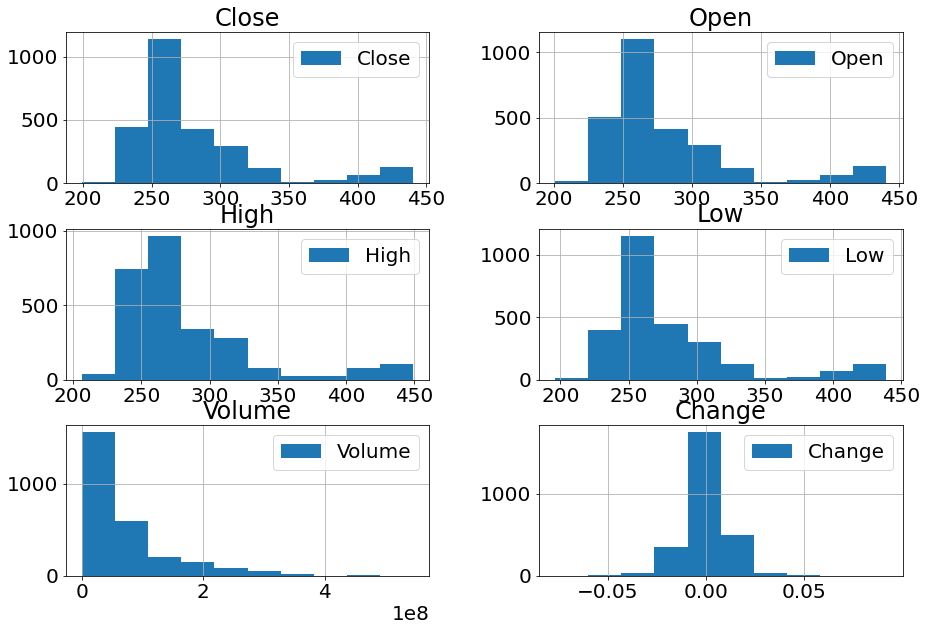

In [179]:
KOSPI200.hist(figsize=(15,10),legend=True)

# Close And Volume

In [180]:
Close = KOSPI200.Close
Volume = KOSPI200.Volume
Close_Vol = pd.concat([Close,Volume],axis=1)
scaler = StandardScaler()
scaler_ = pd.DataFrame(scaler.fit_transform(Close_Vol))


In [181]:
scaler_.columns = ['Close','Volume']
scaler_

,Close,Volume
0,-0.152953,-0.673877
1,-0.111802,-0.673712
2,-0.120784,-0.673551
3,-0.133944,-0.673358
4,-0.115353,-0.673720
...,...,...
2663,2.378774,1.152585
2664,2.463582,0.952342
2665,2.388592,1.654874
2666,2.355378,1.496219


In [182]:
fig = make_subplots(specs=[[{'secondary_y':True}]])
fig.add_trace(
    go.Scatter(x=KOSPI200[2000:].index,y=scaler_[2000:].Close,name='Close price')
)
fig.add_trace(
    go.Scatter(x=KOSPI200[2000:].index,y=scaler_[2000:].Volume,name='Close price')
)
fig.update_layout(
    title = 'Correlation with Close price & Volume',
    xaxis_title = 'Date'
)
fig.show()

# Feature Engineering
* 표본탐색: KOSPI200
* Correlation

## target(Close)를 중심으로 feature engineering

Index(['Close', 'Low', 'High', 'Open', 'Volume', 'Change'], dtype='object')


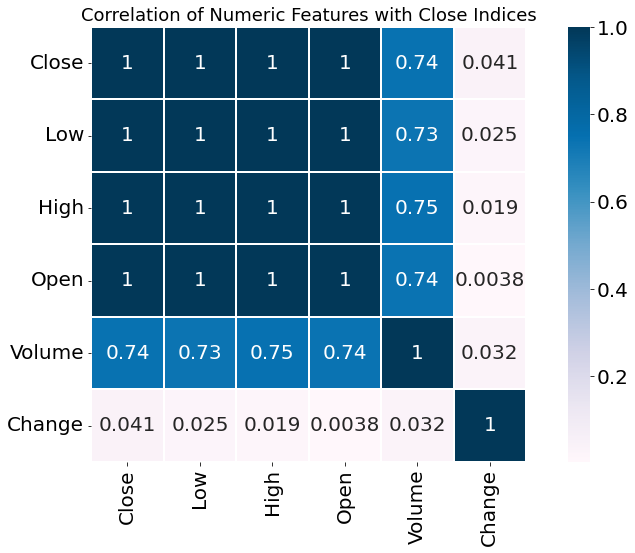

In [183]:
corr_data = KOSPI200[KOSPI200.keys()]
colormap = plt.cm.PuBu  
cols = corr_data.corr().nlargest(6,'Close')['Close'].index 
print(cols) 
cm = np.corrcoef(KOSPI200[cols].values.T) 
f , ax = plt.subplots(figsize = (15,8)) 
plt.title('Correlation of Numeric Features with Close Indices',y=1,size=18)
heatmap = sns.heatmap(cm, vmax=1, linewidths=0.1,square=True,annot=True,cmap=colormap, linecolor="white",xticklabels = cols.values ,yticklabels = cols.values)

In [184]:
KOSPI200.keys()

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Change'], dtype='object')

# Moving Average

In [185]:
class MA(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,x,y):
        return self
    def transform(self,x):
        x['MA5'] = x['Close'].rolling(window=5).mean()
        x['MA10'] = x['Close'].rolling(window=10).mean()
        x['MA20'] = x['Close'].rolling(window=20).mean()
        x['MA60'] = x['Close'].rolling(window=60).mean()
        x['MA120'] = x['Close'].rolling(window=120).mean()
        return x

class VMA(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,x,y=None):
        return self
    def transform(self,x):
        x['VMA5'] = x['Volume'].rolling(window=5).mean()
        x['VMA10'] = x['Volume'].rolling(window=10).mean()
        x['VMA20'] = x['Volume'].rolling(window=20).mean()
        x['VMA60'] = x['Volume'].rolling(window=60).mean()
        x['VMA120'] = x['Volume'].rolling(window=120).mean()
        return x

class bolinger(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,x,y):
        return self
    def transform(self,x):
        x['std'] = x['Close'].rolling(window=20).std()
        x['20_Upper'] = x['MA20'] + 2 * x['std']
        x['20_Lower'] = x['MA20'] - 2 * x['std']
        x.drop('std',axis=1,inplace=True)
        x.dropna(inplace=True)
        return x

class Close_MA(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,x,y):
        return self
    def transform(self,x):
        x['Close_MA5'] = x['Close'] / x['MA5']
        x['Close_MA10'] = x['Close'] / x['MA10']
        x['Close_MA20'] = x['Close'] / x['MA20']
        x['Close_MA60'] = x['Close'] / x['MA60']
        x['Close_MA120'] = x['Close'] / x['MA120']
        return x
    
class Close_Vol(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,x,y):
        return self
    def transform(self,x):
        x['Volume_MA5'] = x['Volume'] / x['VMA5']
        x['Volume_MA10'] = x['Volume'] / x['VMA10']
        x['Volume_MA20'] = x['Volume'] / x['VMA20']
        x['Volume_MA60'] = x['Volume'] / x['VMA60']
        x['Volume_MA120'] = x['Volume'] / x['VMA120']
        return x


In [186]:
data_pipeline = Pipeline([
    ('MA',MA()),
    ('VMA',VMA()),
    ('Bolinger',bolinger()),
    ('Close_MA',Close_MA()),
    ('Close_Vol',Close_Vol()),
])
KOSPI200 = data_pipeline.transform(KOSPI200)
SNP500 = data_pipeline.transform(SNP500)
KOSDAQ = data_pipeline.transform(KOSDAQ)
US30 = data_pipeline.transform(US30)
NASDAQ = data_pipeline.transform(NASDAQ)

Index(['Close', 'Low', 'High', 'Open', 'MA5', 'MA10', 'MA20', '20_Lower',
       '20_Upper', 'MA60', 'MA120', 'VMA120', 'VMA60', 'VMA20', 'VMA10',
       'VMA5', 'Volume', 'Close_MA120', 'Close_MA60', 'Close_MA20',
       'Close_MA10', 'Close_MA5', 'Change', 'Volume_MA120', 'Volume_MA60',
       'Volume_MA5', 'Volume_MA10'],
      dtype='object')


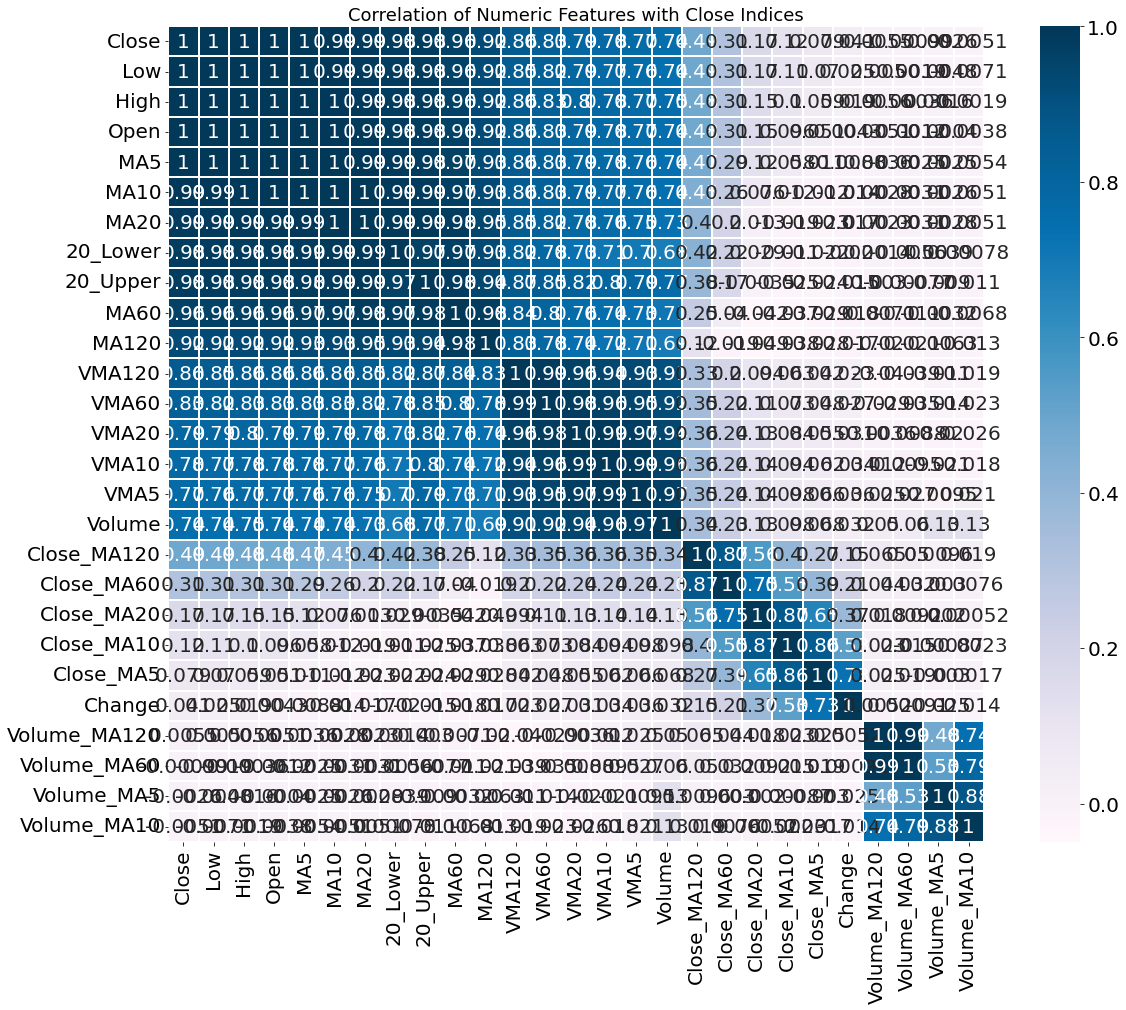

<Figure size 432x288 with 0 Axes>

In [187]:
corr_data = KOSPI200[KOSPI200.keys()]
colormap = plt.cm.PuBu  
k = len(KOSPI200.keys())-1
cols = corr_data.corr().nlargest(k,'Close')['Close'].index 
print(cols) 
cm = np.corrcoef(KOSPI200[cols].values.T) 
f , ax = plt.subplots(figsize = (20,15)) 
plt.title('Correlation of Numeric Features with Close Indices',y=1,size=18)
heatmap = sns.heatmap(cm, vmax=1, linewidths=0.1,square=True,annot=True,cmap=colormap, linecolor="white",xticklabels = cols.values ,yticklabels = cols.values)
plt.show()
plt.savefig('heatmap.png')

In [188]:
US30.isna().sum()

Close           0
Open            0
High            0
Low             0
Volume          0
Change          0
MA5             0
MA10            0
MA20            0
MA60            0
MA120           0
VMA5            0
VMA10           0
VMA20           0
VMA60           0
VMA120          0
20_Upper        0
20_Lower        0
Close_MA5       0
Close_MA10      0
Close_MA20      0
Close_MA60      0
Close_MA120     0
Volume_MA5      0
Volume_MA10     0
Volume_MA20     0
Volume_MA60     0
Volume_MA120    0
dtype: int64

# Visualization for key features

In [189]:
def plot_MA(data):
    %matplotlib inline
    plt.figure(figsize=(30,10))
    plt.rc('font',size=20)
    plt.plot(data['Close'],label='Close')
    plt.plot(data['MA5'],label='MA5',)
    plt.plot(data['MA10'],label='MA10')
    plt.plot(data['MA20'],label='MA20')
    plt.plot(data['MA60'],label='MA60')
    plt.plot(data['MA120'],label='MA120')
    plt.xlabel('Year')
    plt.ylabel('Indics')
    plt.legend(fontsize=30)
    plt.grid(True)
    return plt.show()
    

In [190]:
def plot_VMA(data):
    %matplotlib inline
    plt.figure(figsize=(30,10))
    plt.rc('font',size=20)
    plt.plot(data['Volume'],label='Volume')
    plt.plot(data['VMA5'],label='VMA5',)
    plt.plot(data['VMA10'],label='VMA10')
    plt.plot(data['VMA20'],label='VMA20')
    plt.plot(data['VMA60'],label='VMA60')
    plt.plot(data['VMA120'],label='VMA120')
    plt.ylabel('Volume')
    plt.xlabel('year')
    plt.legend(fontsize=30)
    plt.grid(True)
    return plt.show()
    

In [191]:
def bol_plot(data):
    plt.figure(figsize=(30,10))
    plt.rc('font',size=20)
    plt.plot(data['Close'],color='black',label='Close_price')
    plt.plot(data['20_Upper'],ls='--',color='red',label='Uper Band')
    plt.plot(data['20_Lower'],ls='--',color='blue',label='Lower Band')
    plt.xlabel('Date')
    plt.ylabel('Indics')
    plt.legend()
    plt.grid(True)
    return plt.show()

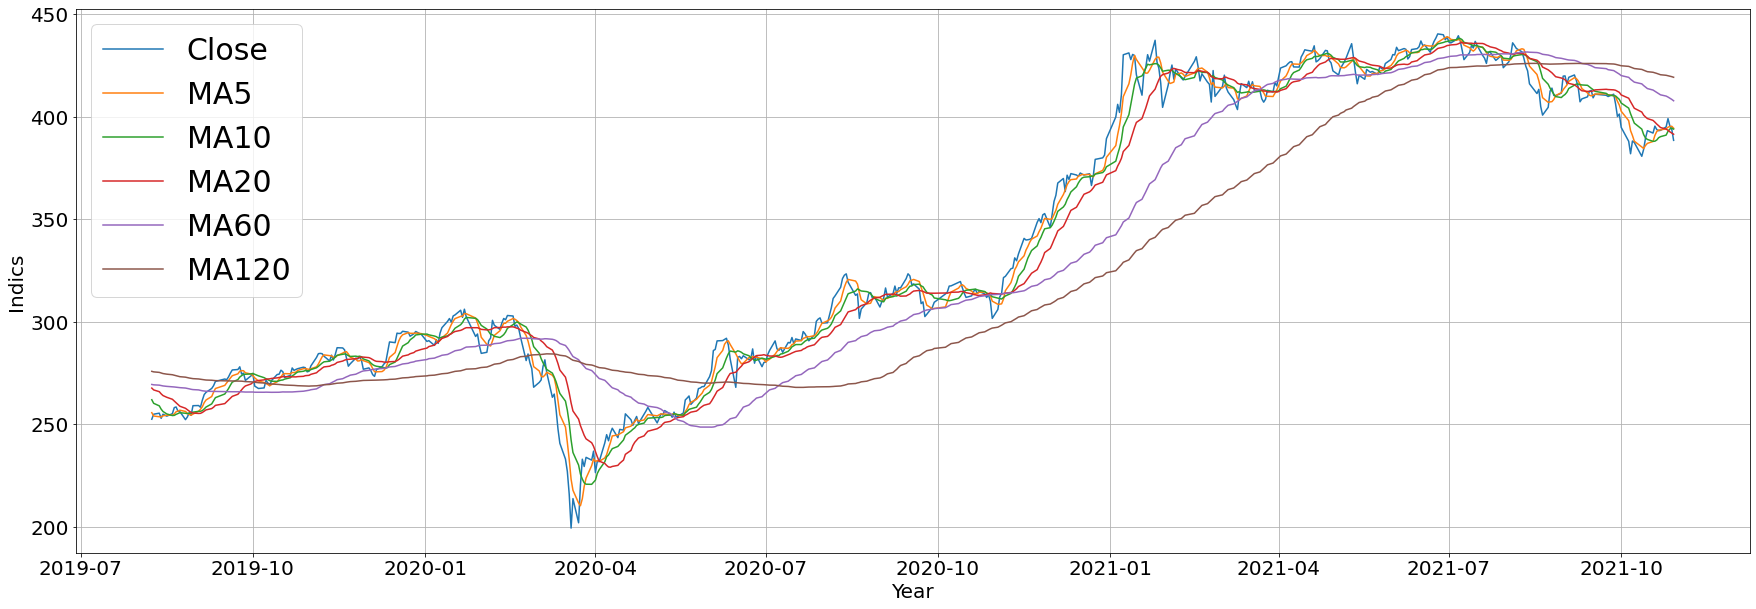

In [192]:
plot_MA(KOSPI200[2000:])

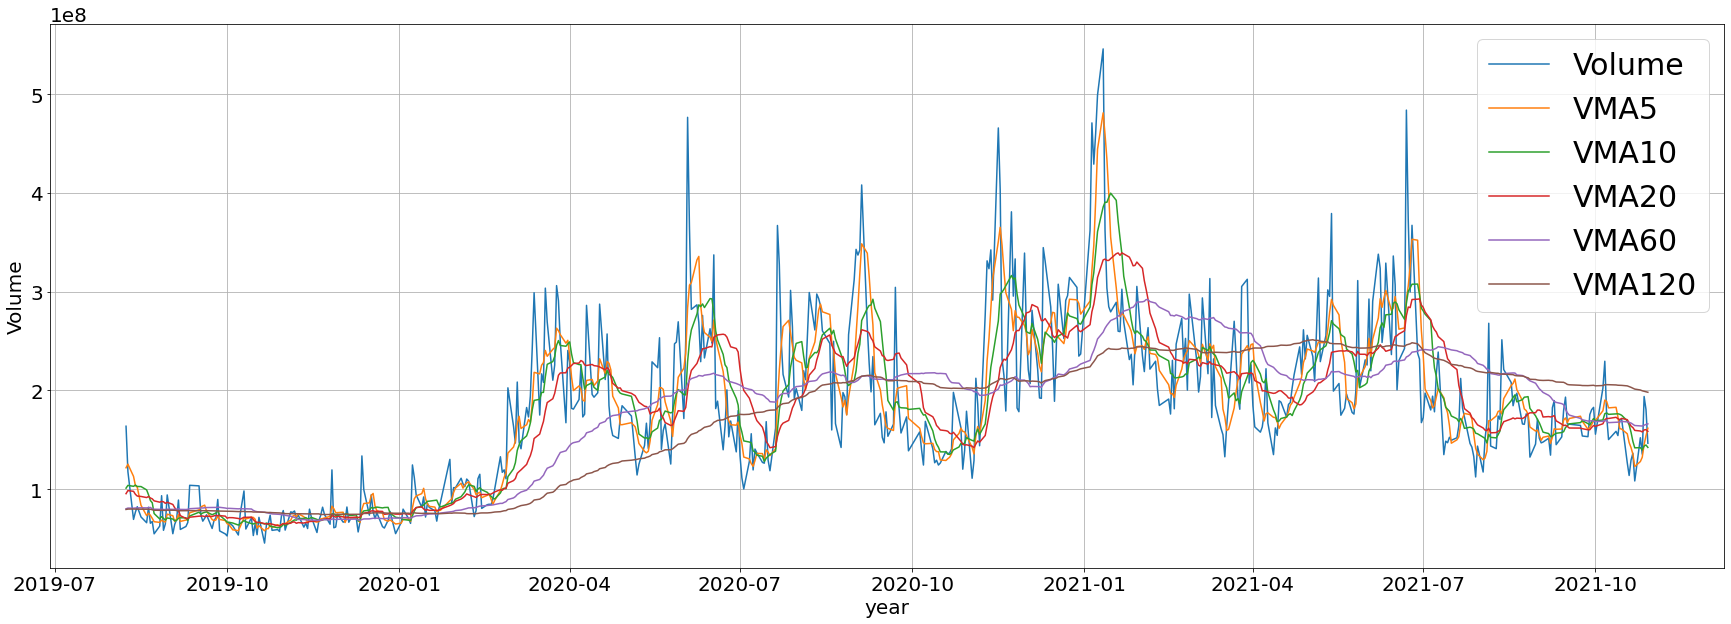

In [193]:
plot_VMA(KOSPI200[2000:])

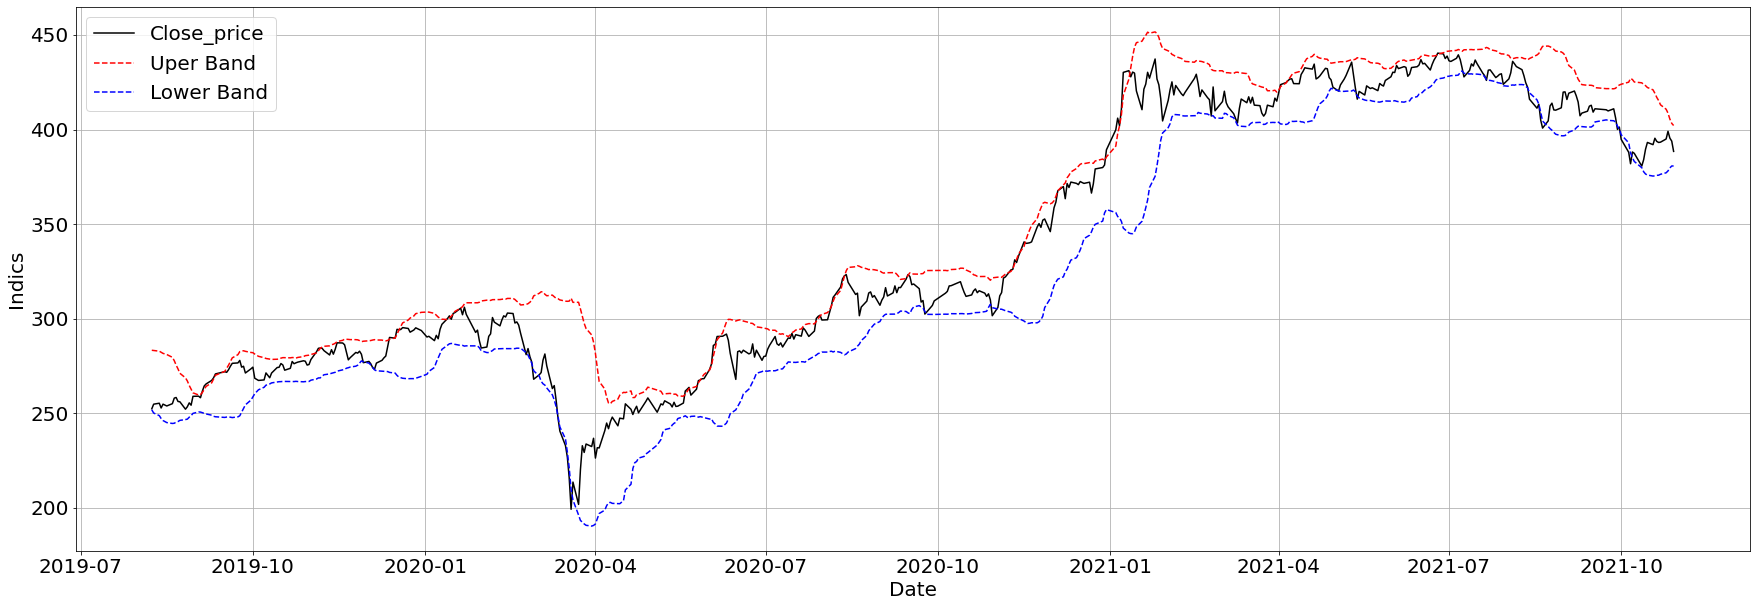

In [194]:
bol_plot(KOSPI200[2000:])

# ML Dataset 

In [195]:
NASDAQ.keys()

Index(['Close', 'Open', 'High', 'Low', 'Volume', 'Change', 'MA5', 'MA10',
       'MA20', 'MA60', 'MA120', 'VMA5', 'VMA10', 'VMA20', 'VMA60', 'VMA120',
       '20_Upper', '20_Lower', 'Close_MA5', 'Close_MA10', 'Close_MA20',
       'Close_MA60', 'Close_MA120', 'Volume_MA5', 'Volume_MA10', 'Volume_MA20',
       'Volume_MA60', 'Volume_MA120'],
      dtype='object')

In [196]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()

In [197]:
def ML_data_preprocessing(data):
    data.drop(['Volume','Volume_MA5','Volume_MA10','Volume_MA20','Volume_MA60','Volume_MA120','Change'],axis=1,inplace=True)
    ML_dataname_train, ML_dataname_test = data[:-20],data[-20:]
    ML_dataname_train.reset_index(drop=True,inplace=True)
    ML_dataname_test.reset_index(drop=True,inplace=True)
    ML_dataname_train_target = ML_dataname_train.Close.iloc[20:]
    ML_dataname_train = scaler.fit_transform(ML_dataname_train.iloc[0:-20])
    return ML_dataname_train, ML_dataname_train_target,ML_dataname_test
    

In [198]:
ML_KOSPI200_train,ML_KOSPI200_target,ML_KOSPI200_test = ML_data_preprocessing(KOSPI200)
ML_SNP500_train,ML_SNP500_target,ML_SNP500_test = ML_data_preprocessing(SNP500)
ML_NASDAQ_train,ML_NASDAQ_target,ML_NASDAQ_test = ML_data_preprocessing(NASDAQ)
ML_KOSDAQ_train,ML_KOSDAQ_target,ML_KOSDAQ_test = ML_data_preprocessing(KOSDAQ)
ML_US30_train,ML_US30_target,ML_US30_test = ML_data_preprocessing(US30)

In [199]:
print(ML_KOSDAQ_train.shape,ML_KOSDAQ_target.shape,ML_KOSDAQ_test.shape)

(2510, 21) (2510,) (20, 21)


In [200]:
def ML_MAPELoss(output,target):
    return np.mean(np.abs((target - output)/ target))

In [201]:
def ML_NMAE(pred,target):
    return abs(target - pred).sum() / (abs(target).sum()) * 100

In [293]:
def indices_binarizer(target,prediction):
    target_result = []
    prediction_result = []
    for i,indices in enumerate(target):
        if i == 0:
            target_result.append(0)
            data = indices
        if indices >= data:
            pred = 1
            target_result.append(pred)
            data = indices
        if indices < data:
            pred = 0
            target_result.append(pred)
            data = indices
    for i,indices in enumerate(prediction):
        if i == 0:
            prediction_result.append(0)
            pred_data = indices
        if indices >= data:
            pred = 1
            prediction_result.append(pred)
            pred_data = indices
        if indices < data:
            pred = 0
            prediction_result.append(pred)
            pred_data = indices
    return target_result, prediction_result

# ML models

In [203]:
ML_KOSPI200_train

array([[ 0.16937732,  0.25499768,  0.25956662, ..., -0.42076774,
        -0.74002858, -0.35458556],
       [ 0.26696097,  0.27731288,  0.25680037, ...,  0.16612962,
        -0.43502413, -0.12961496],
       [ 0.27997212,  0.28870293,  0.27086215, ...,  0.28637498,
        -0.38964862, -0.09929787],
       ...,
       [ 3.5044145 ,  3.5009298 ,  3.49700323, ..., -0.71654872,
        -0.82942511, -0.57004207],
       [ 3.4214684 ,  3.5120874 ,  3.49031812, ..., -0.93534146,
        -0.97953121, -0.69386526],
       [ 3.41821561,  3.37587169,  3.39926233, ..., -0.86914197,
        -0.96860483, -0.6999324 ]])

In [204]:
def RF_model(x_train,y_train,x_test):
    rf_models = []
    rf_result = []
    kf = KFold(n_splits=5) 
    fold = 1
    for train_idx,valid_idx in kf.split(x_train,y_train):
        train_x = x_train[train_idx] 
        train_y = y_train.values[train_idx] 
        val_x = x_train[valid_idx]  
        val_y = y_train.values[valid_idx]
        print(f"--------------------fold:{fold}--------------------")
        rf_model = BaggingRegressor(RandomForestRegressor(n_estimators=50,n_jobs=-1,
                                         random_state=0),n_jobs=-1,oob_score=True,verbose=False) 
        rf_model.fit(train_x,train_y)  
        prediction = rf_model.predict(val_x)
        label, y_hat = indices_binarizer(val_y,prediction)
        print(f'Accuracy score:{accuracy_score(label,y_hat)}')
        score = ML_MAPELoss(prediction,val_y) 
        print(f"MAPE:{score}")  
        rf_models.append(rf_model) 
        fold += 1
    for model in rf_models:
        pred = model.predict(x_test)
        rf_result.append(pred)
    rf_pred = np.mean(rf_result,axis=0)
    return rf_pred

In [205]:
print('------KOSPI200---------')
rf_KOSPI200_pred = RF_model(ML_KOSPI200_train,ML_KOSPI200_target,ML_KOSPI200_test)
print('-------S&P500----------')
rf_SNP500_pred = RF_model(ML_SNP500_train,ML_SNP500_target,ML_SNP500_test)
print('-------KOSDAQ----------')
rf_KOSDAQ_pred = RF_model(ML_KOSDAQ_train,ML_KOSDAQ_target,ML_KOSDAQ_test)
print('-------NASDAQ----------')
rf_NASDAQ_pred = RF_model(ML_NASDAQ_train,ML_NASDAQ_target,ML_NASDAQ_test)
print('-------US30----------')
rf_US30_pred = RF_model(ML_US30_train,ML_US30_target,ML_US30_test)
print('End Training')

------KOSPI200---------
--------------------fold:1--------------------
Accuracy score:0.4731610337972167
MAPE:0.04004212720339498
--------------------fold:2--------------------
Accuracy score:0.510934393638171
MAPE:0.03192506292535866
--------------------fold:3--------------------
Accuracy score:0.4592445328031809
MAPE:0.05406424146127857
--------------------fold:4--------------------
Accuracy score:0.4850894632206759
MAPE:0.09391854196879885
--------------------fold:5--------------------
Accuracy score:0.4302788844621514
MAPE:0.14816702037420512
-------S&P500----------
--------------------fold:1--------------------
Accuracy score:0.44854368932038835
MAPE:0.21512698850295897
--------------------fold:2--------------------
Accuracy score:0.516504854368932
MAPE:0.04284704608382391
--------------------fold:3--------------------
Accuracy score:0.5
MAPE:0.03323615691179092
--------------------fold:4--------------------
Accuracy score:0.46303501945525294
MAPE:0.06391530557176711
-------------

# Compare to real_Indices

In [206]:
for i in range(len(stock_code)):
    start_date = '2021-11-01'
    end_date = '2021-11-26'
    stock_name[i] = fdr.DataReader(stock_code[i],start=start_date,end=end_date)[['Close']]


In [207]:
real_KOSPI200 = stock_name[0]
real_SNP500 = stock_name[1]
real_NASDAQ = stock_name[2]
real_KOSDAQ = stock_name[3]
real_US30 = stock_name[4]

In [208]:
def make_datetime(pred):
    pred_start = pd.to_datetime('2021-11-01')
    pred_end = pd.to_datetime('2021-11-26')
    name_pred = pd.DataFrame()
    name_pred.index = pd.date_range(pred_start,pred_end,freq='B')
    name_pred['pred'] = pred
    return name_pred

In [209]:
ML_KOSPI200_pred = make_datetime(rf_KOSPI200_pred)
ML_SNP500_pred = make_datetime(rf_SNP500_pred)
ML_KOSDAQ_pred = make_datetime(rf_KOSDAQ_pred)
ML_NASDAQ_pred = make_datetime(rf_NASDAQ_pred)
ML_US30_pred = make_datetime(rf_US30_pred)

In [210]:
def plot_result(label,pred,real):
    plt.figure(figsize=(17,10))
    plt.rc('font',size=20)
    plt.title(label)
    plt.plot(pred,ls='-.',label='prediction_Indices',color='black')
    plt.plot(real,label='real_Indices',color='red')
    plt.legend(loc='upper right')
    plt.show()

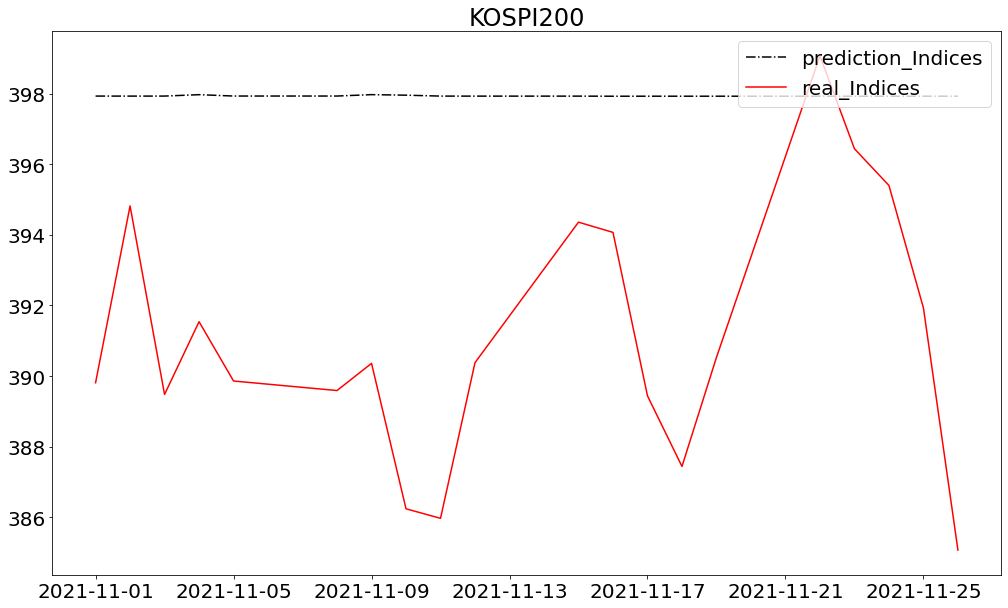

In [211]:
plot_result('KOSPI200',ML_KOSPI200_pred,real_KOSPI200)

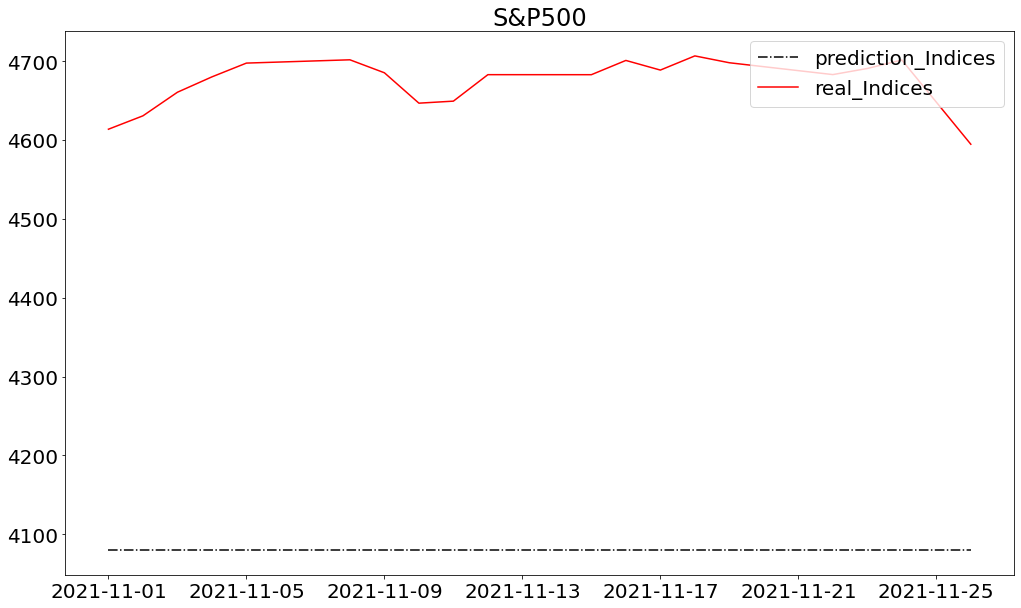

In [212]:
plot_result('S&P500',ML_SNP500_pred,real_SNP500)

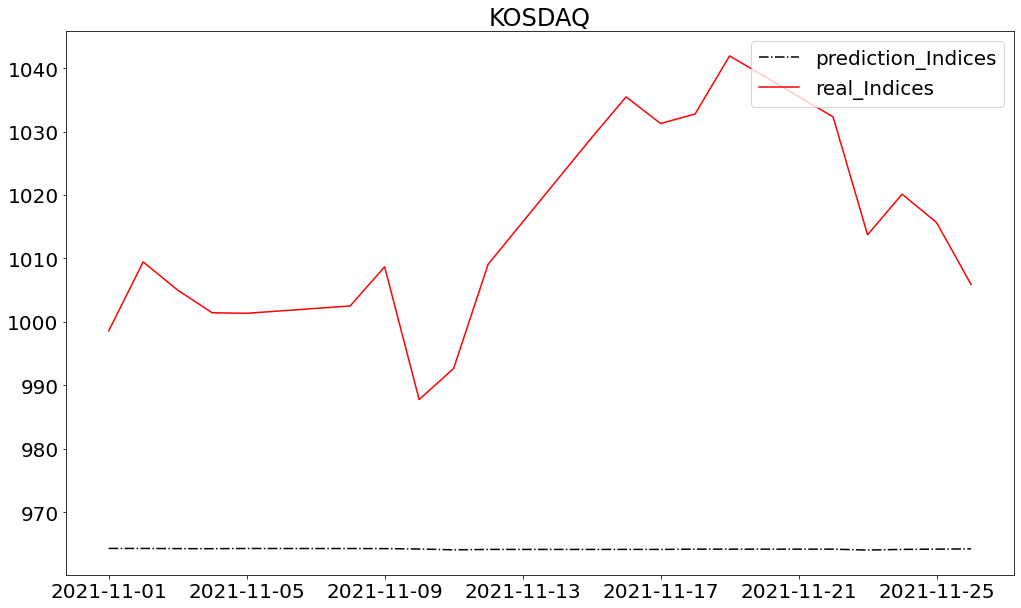

In [213]:
plot_result('KOSDAQ',ML_KOSDAQ_pred,real_KOSDAQ)

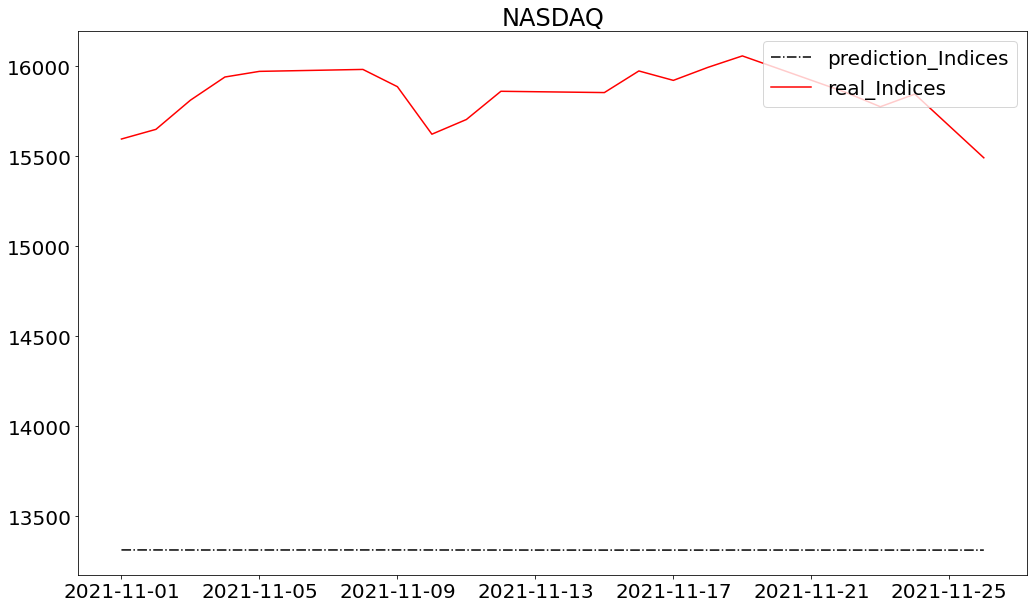

In [214]:
plot_result('NASDAQ',ML_NASDAQ_pred,real_NASDAQ)

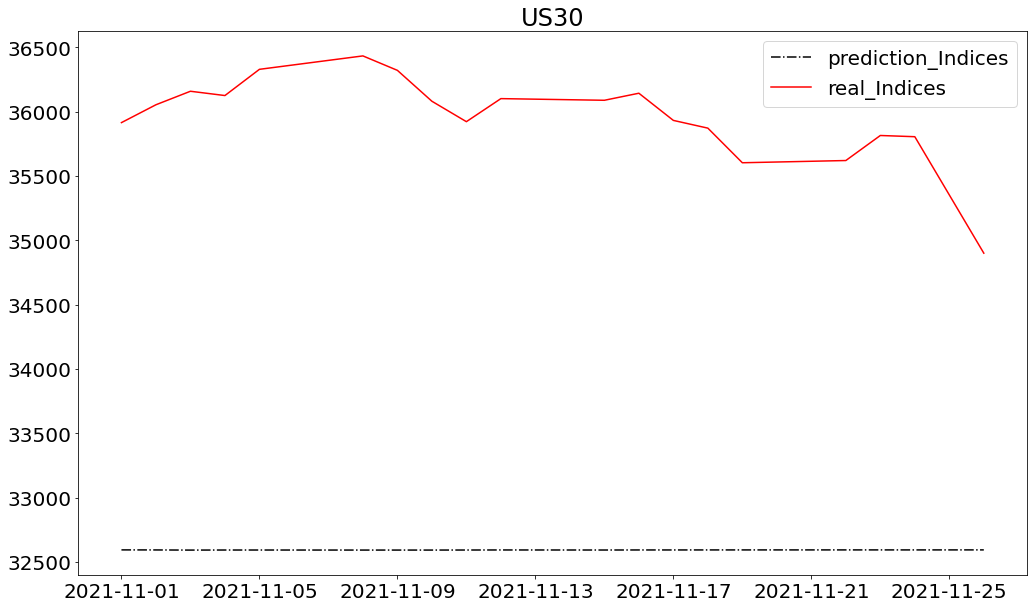

In [215]:
plot_result('US30',ML_US30_pred,real_US30)

# Deep Learning Dataset

### Dataset Composition method
* 데이터를 주단위(5일)로 나누어서 5일간의 변동성을 모델로 훈련시켜서 데이터셋 다음날의 가격을 에측하게 하였습니다.
* 월-금의 데이터  다음주 월요일 예측 ,  화요일-다음주월요일 -> 다음주 화요일 예측
* 그래서 5개의 차원을 만들어서 한주의 column들을 model이 학습할 수 있도록 구성
* Convolution 과 GRU를 이용하기에 feature engineering을 통해서 만든 column들은 drop 하였습니다.

In [216]:
KOSPI200

,Close,Open,High,Low,MA5,MA10,MA20,MA60,MA120,VMA5,VMA10,VMA20,VMA60,VMA120,20_Upper,20_Lower,Close_MA5,Close_MA10,Close_MA20,Close_MA60,Close_MA120
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-28,270.41,274.37,275.59,270.41,271.242,269.888,272.9180,279.301667,273.936917,106202.0,104243.0,106977.0,1.215985e+05,1.206544e+05,283.074101,262.761899,0.996933,1.001934,0.990810,0.968165,0.987125
2011-06-29,274.61,275.33,275.47,273.06,272.022,269.896,272.5105,279.199667,273.943583,105462.0,106297.0,105849.5,1.212505e+05,1.207733e+05,281.602105,263.418895,1.009514,1.017466,1.007704,0.983561,1.002433
2011-06-30,275.17,275.82,276.08,274.02,273.188,270.525,272.1315,279.119000,273.938500,108824.0,108030.0,104697.0,1.207055e+05,1.207100e+05,279.971678,264.291322,1.007255,1.017170,1.011166,0.985852,1.004496
2011-07-01,278.77,277.90,279.69,277.34,274.080,271.780,272.1320,279.064667,273.967000,105998.0,105385.0,104705.0,1.205208e+05,1.205798e+05,279.973959,264.290041,1.017112,1.025719,1.024393,0.998944,1.017531
2011-07-04,281.67,281.28,282.85,281.13,276.126,273.508,272.2735,279.070000,274.024917,117576.0,109945.0,106580.0,1.201005e+05,1.205219e+05,280.705060,263.841940,1.020078,1.029842,1.034511,1.009317,1.027899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-25,395.01,392.45,395.99,390.02,394.136,391.027,393.9480,410.067833,420.208583,127968000.0,142027000.0,158888000.0,1.640943e+08,2.004122e+08,410.751822,377.144178,1.002218,1.010186,1.002696,0.963280,0.940033
2021-10-26,399.07,397.75,399.67,396.28,394.868,392.865,393.4095,409.594500,419.981833,132278000.0,139710000.0,157967000.0,1.639138e+08,1.996077e+08,408.690239,378.128761,1.010642,1.015794,1.014388,0.974305,0.950208
2021-10-27,395.48,398.31,398.82,394.41,395.216,394.003,392.6350,409.048833,419.757833,145198000.0,143668000.0,160002500.0,1.647693e+08,1.990915e+08,405.556207,379.713793,1.000668,1.003749,1.007246,0.966828,0.942162


In [217]:
def deeplr_data(data):
    data.drop(['VMA5','VMA10','VMA20','VMA60','VMA120','Close_MA5','Close_MA10',
               'Close_MA20','Close_MA60','Close_MA120'],axis=1,inplace=True)
    name_train, name_test = data[:-25], data[-25:]
    name_train.reset_index(drop=True,inplace=True)
    name_target = name_train.Close.iloc[25:]
    name_train = name_train.iloc[0:-25]
    name_test.reset_index(drop=True,inplace=True)
    return name_train , name_test ,name_target
    
    

In [218]:
KOSPI200_train, KOSPI200_test, KOSPI200_target,  = deeplr_data(KOSPI200)
SNP500_train,SNP500_test,SNP500_target  = deeplr_data(SNP500)
NASDAQ_train,NASDAQ_test,NASDAQ_target  = deeplr_data(NASDAQ)
KOSDAQ_train, KOSDAQ_test, KOSDAQ_target = deeplr_data(KOSDAQ)
US30_train, US30_test, US30_target = deeplr_data(US30)

In [219]:
print(KOSPI200_train.shape, KOSPI200_test.shape,KOSPI200_target.shape,)

(2499, 11) (25, 11) (2499,)


In [220]:
def make_dataset(data, label, window_size=5):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [221]:
def make_testset(data , window_size=5):
    feature_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
    return np.array(feature_list)

In [222]:
feature = [KOSPI200.keys()]
label = ['Close']
KOSPI200_trainset , KOSPI200_target = make_dataset(KOSPI200_train,KOSPI200_target)
KOSPI200_testset = make_testset(KOSPI200_test)

SNP500_trainset, SNP500_target = make_dataset(SNP500_train,SNP500_target)
SNP500_testset = make_testset(SNP500_test)

KOSDAQ_trainset, KOSDAQ_target = make_dataset(KOSDAQ_train,KOSDAQ_target)
KOSDAQ_testset = make_testset(KOSDAQ_test)

NASDAQ_trainset, NASDAQ_target = make_dataset(NASDAQ_train,NASDAQ_target)
NASDAQ_testset = make_testset(NASDAQ_test)

US30_trainset, US30_target = make_dataset(US30_train,US30_target)
US30_testset = make_testset(US30_test)


In [223]:
print(KOSDAQ_trainset.shape,KOSDAQ_target.shape)
print(KOSDAQ_testset.shape)

(2495, 5, 11) (2495,)
(20, 5, 11)


# dataset to tensor

In [224]:
class CustomDataset(Dataset):
    def __init__(self,data,label):
        self.data = data
        self.label = label
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        data = torch.tensor(scaler.fit_transform(self.data[idx]),dtype=torch.float64)
        label = torch.tensor(self.label[idx],dtype=torch.int64)
        return data,label

In [225]:
class CustomTestset(Dataset):
    def __init__(self,data):
        self.data = data
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        data = torch.tensor(scaler.fit_transform(self.data[idx]),dtype=torch.float64)
        return data

# CNN2RNN Dataset

In [252]:
KOSPI200_train_set = CustomDataset(KOSPI200_trainset,KOSPI200_target)
KOSPI200_test_set = CustomTestset(KOSPI200_testset)

SNP500_train_set = CustomDataset(SNP500_trainset,SNP500_target)
SNP500_test_set = CustomTestset(SNP500_testset)

KOSDAQ_train_set = CustomDataset(KOSDAQ_trainset,KOSDAQ_target)
KOSDAQ_test_set = CustomTestset(KOSDAQ_testset)

NASDAQ_train_set = CustomDataset(NASDAQ_trainset,NASDAQ_target)
NASDAQ_test_set = CustomTestset(NASDAQ_testset)

US30_train_set = CustomDataset(US30_trainset,US30_target)
US30_test_set = CustomTestset(US30_testset)

# Deep Learning Model

In [253]:
import torch
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import KFold
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer

## Model
* activation : HardSwish,GELU,LeakyReLU
* layers : Conv1d,GRU,Linear,BatchNormalization

## 모델 설명
* Convolution 1d 를 사용하여서 kernel size는 1로 하고 activation fuction을 통해서 feature size의 변화없이 채널 사이즈의 변화와 비선형성을 주었습니다.
* GRU를 통하여서 convolution을 통한 weight가 아닌 다시 input을 삽입하여서 overfitiing을 최소화 하였습니다. 아무래도 주식가격예측문제와 같은 time-series data에서 overfitting은 피할 수 없는 문제인것 같습니다.
* 그리고 두 layer들을 통하여 나온 weight와 bias를 결합하여서 Linear를 통해서 가격을 예측해보았습니다.

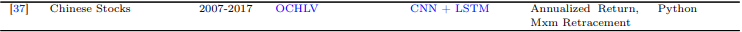

In [254]:
Image('../input/image-finance/20220225_144122.png')

In [255]:
class CNN2GRU(nn.Module):
    def __init__(self):
        super(CNN2GRU,self).__init__()
        self.conv1 = nn.Conv1d(5,128,1)
        self.bnn1 = nn.BatchNorm1d(128)
        self.conv2 = nn.Conv1d(128,256,1)
        self.bnn2 = nn.BatchNorm1d(256)
        self.conv3 = nn.Conv1d(256,512,1)
        self.bnn3 = nn.BatchNorm1d(512)
        self.gru1 = nn.LSTM(11,512,4)
        self.gru2 = nn.LSTM(512,256,4)
        self.gru3 = nn.LSTM(256,11,4)
        self.fc1 = nn.Linear(5687,1024)
        self.fc2 = nn.Linear(1024,1024)
        self.fc3 = nn.Linear(1024,256)
        self.fc4 = nn.Linear(256,1)
        self.flatten = nn.Flatten()
        self.gelu = nn.GELU()
        self.lrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.25)
        self.swish = nn.Hardswish()
    def forward(self,input):
        x = self.bnn1(self.swish(self.conv1(input)))
        x = self.bnn2(self.swish(self.conv2(x)))
        conv_out = self.bnn3(self.swish(self.conv3(x)))
        x,_ = self.gru1(input)
        x = self.gelu(x)
        x,_ = self.gru2(x)
        x = self.gelu(x)
        x,_ = self.gru3(x)
        GRU_out = self.gelu(x)
        x = torch.cat([conv_out,GRU_out],dim=1)
        x = x.flatten(1)
        x = self.dropout(self.swish(self.fc1(x)))
        x = self.dropout(self.swish(self.fc2(x)))
        x = self.dropout(self.swish(self.fc3(x)))
        output = self.fc4(x)
        output = output.view(-1)
        return output
model = CNN2GRU()
model

CNN2GRU(
  (conv1): Conv1d(5, 128, kernel_size=(1,), stride=(1,))
  (bnn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
  (bnn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
  (bnn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (gru1): LSTM(11, 512, num_layers=4)
  (gru2): LSTM(512, 256, num_layers=4)
  (gru3): LSTM(256, 11, num_layers=4)
  (fc1): Linear(in_features=5687, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=1, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (gelu): GELU()
  (lrelu): LeakyReLU(negative_slope=0.1)
  (dropout): Dropout(p=0.25, inplace=False)
  (swish): Hardswish()
)

# Train Session

* optimizer : AdamMax
* Loss_func : MAPE_Loss , NMAE
* 어떠한 Loss가 모델의 Weight에 좋은 영향을 끼치는지 실험적으로 판단해보았습니다.
* validation Loss , accuracy를 중심으로 더 좋아지는 방향으로 모델을 저장했습니다.

In [256]:
def MAPELoss(output,target):
    return torch.mean(torch.abs((target - output)/ target))

def NMAELoss(pred,target):
    return abs(target - pred).sum() / (abs(target).sum()) * 100

In [290]:
def train(model,loader,device,optimizer):
        model.train()
        train_loss = []
        train_acc = []
        tqdm_train = tqdm(loader)
        for data,label in tqdm_train:
            data,label = data.to(device).float(),label.to(device)
            optimizer.zero_grad()
            logits = model(data)
            label = label.to(torch.float32)
            target_binary, pred_binary = indices_binarizer(label,logits)
            acc = accuracy_score(target_binary,pred_binary)
            loss = NMAELoss(logits,label)
            loss.backward()
            optimizer.step()

            loss_np = loss.detach().cpu().numpy()
            acc_np = acc
            train_loss.append(loss_np)
            train_acc.append(acc_np)
        train_loss = np.mean(train_loss)
        train_acc = np.mean(train_acc)
    
        return train_acc, train_loss

In [289]:
def validation(model,loader,device):
    model.eval()
    valid_acc = []
    valid_loss = []
    tqdm_valid = tqdm(loader)
    with torch.no_grad():
        for data,label in tqdm_valid:
            
            data,label = data.to(device).float(),label.to(device)
                
            logits = model(data)
            loss = NMAELoss(logits,label)
            target_binary, pred_binary = indices_binarizer(label,logits)
            acc = accuracy_score(target_binary,pred_binary)
            loss_np = loss.detach().cpu().numpy()
            acc_np = acc
            valid_loss.append(loss_np)
            valid_acc.append(acc_np)
        valid_loss = np.mean(valid_loss)
        valid_acc = np.mean(valid_acc)
    return valid_acc, valid_loss
        

In [291]:
def CNN2RNN_run(stock_name,model,data,lr,epochs):
    device = ('cuda' if torch.cuda.is_available else 'cpu')
    kf = KFold(n_splits=5,shuffle=True)
    for fold ,(train_idx,valid_idx) in enumerate(kf.split(data)):
        print(f'Fold:{fold+1}')
        train_sampler_kfold = SubsetRandomSampler(train_idx)
        valid_sampler_kfold = SubsetRandomSampler(valid_idx)
        train_loader = torch.utils.data.DataLoader(data,batch_size=128,
                                                   num_workers=0,sampler=train_sampler_kfold,drop_last=True)
        valid_loader = torch.utils.data.DataLoader(data,batch_size=128,
                                              num_workers=0,sampler=valid_sampler_kfold,drop_last=True)
        valid_min_loss = np.Inf
        name_train_acc = []
        name_valid_acc = []
        name_train_loss = []
        name_valid_loss = []
        model = CNN2GRU()
        model.to(device)
        optimizer = torch.optim.Adamax(model.parameters(),lr=lr)
        for e in range(epochs):
            train_acc,train_loss = train(model,train_loader,device,optimizer)
            valid_acc,valid_loss = validation(model,valid_loader,device)
            
            name_train_loss.append(train_loss)
            name_valid_loss.append(valid_loss)
            name_train_acc.append(train_acc)
            name_valid_acc.append(valid_acc)
            
            print('Epochs:{}\t Training Accuracy:{:.3f}\t Validation Accuracy:{:.3f}'.format(
            e+1,train_acc,valid_acc))
            
            print('Epoch:{}\t Training Loss:{:.3f}\t Validation Loss:{:3f}'.format(
                e+1,train_loss,valid_loss))
            if valid_loss < valid_min_loss:
                print('Validation Loss decreased:{:3f} --> {:3f} So saving the model'.format(
                    valid_min_loss,valid_loss))
                valid_min_loss = valid_loss
                torch.save(model,f'{stock_name}_CNN2GRU_{fold}.pt')
                patience = 0
            else:
                patience += 1
                print(f'count patience:{patience} of 10')
                if patience > 10:
                    print(f"Meet Early Stopper so End Training...\nAnd best Valid MAPE Loss:{valid_min_loss}")
                    break
    return name_train_acc, name_train_loss, name_valid_acc, name_valid_loss
    

In [294]:
print('-------------------KOSPI200---------------------')
KOSPI200_train_acc, KOSPI200_train_loss, KOSPI200_valid_acc, KOSPI200_valid_loss = CNN2RNN_run('KOSPI200',CNN2GRU(),KOSPI200_train_set,lr=0.0003,epochs=100)
print('-------------------S&P500---------------------')
SNP500_train_acc, SNP500_train_loss,SNP500_valid_acc ,SNP500_valid_loss = CNN2RNN_run('SNP500',CNN2GRU(),SNP500_train_set,lr=0.0003,epochs=100)
print('-------------------KOSDAQ---------------------')
KOSDAQ_train_acc,KOSDAQ_train_loss,KOSDAQ_valid_acc ,KOSDAQ_valid_loss = CNN2RNN_run('KOSDAQ',CNN2GRU(),KOSDAQ_train_set,lr=0.0003,epochs=100)
print('-------------------NASDAQ---------------------')
NASDAQ_train_acc,NASDAQ_train_loss,NASDAQ_valid_acc,NASDAQ_valid_loss = CNN2RNN_run('NASDAQ',CNN2GRU(),NASDAQ_train_set,lr=0.0003,epochs=100)
print('-------------------US30---------------------')
US30_train_acc,US30_train_loss,US30_valid_acc,US30_valid_loss = CNN2RNN_run('US30',CNN2GRU(),US30_train_set,lr=0.0003,epochs=100)

-------------------KOSPI200---------------------
Fold:1


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epochs:1	 Training Accuracy:0.496	 Validation Accuracy:0.486
Epoch:1	 Training Loss:99.255	 Validation Loss:99.358582
Validation Loss decreased:inf --> 99.358582 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epochs:2	 Training Accuracy:0.485	 Validation Accuracy:0.478
Epoch:2	 Training Loss:88.294	 Validation Loss:86.282814
Validation Loss decreased:99.358582 --> 86.282814 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epochs:3	 Training Accuracy:0.511	 Validation Accuracy:0.568
Epoch:3	 Training Loss:46.894	 Validation Loss:30.498146
Validation Loss decreased:86.282814 --> 30.498146 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:4	 Training Accuracy:0.543	 Validation Accuracy:0.525
Epoch:4	 Training Loss:28.828	 Validation Loss:30.322584
Validation Loss decreased:30.498146 --> 30.322584 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epochs:5	 Training Accuracy:0.536	 Validation Accuracy:0.481
Epoch:5	 Training Loss:21.596	 Validation Loss:25.527786
Validation Loss decreased:30.322584 --> 25.527786 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:6	 Training Accuracy:0.539	 Validation Accuracy:0.483
Epoch:6	 Training Loss:19.645	 Validation Loss:22.082525
Validation Loss decreased:25.527786 --> 22.082525 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:7	 Training Accuracy:0.533	 Validation Accuracy:0.535
Epoch:7	 Training Loss:18.155	 Validation Loss:20.491587
Validation Loss decreased:22.082525 --> 20.491587 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:8	 Training Accuracy:0.525	 Validation Accuracy:0.486
Epoch:8	 Training Loss:17.148	 Validation Loss:20.112741
Validation Loss decreased:20.491587 --> 20.112741 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.00it/s]


Epochs:9	 Training Accuracy:0.529	 Validation Accuracy:0.568
Epoch:9	 Training Loss:16.828	 Validation Loss:16.500727
Validation Loss decreased:20.112741 --> 16.500727 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:10	 Training Accuracy:0.545	 Validation Accuracy:0.506
Epoch:10	 Training Loss:15.578	 Validation Loss:18.329165
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:11	 Training Accuracy:0.556	 Validation Accuracy:0.519
Epoch:11	 Training Loss:15.057	 Validation Loss:15.559640
Validation Loss decreased:16.500727 --> 15.559640 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:12	 Training Accuracy:0.549	 Validation Accuracy:0.494
Epoch:12	 Training Loss:14.990	 Validation Loss:15.131068
Validation Loss decreased:15.559640 --> 15.131068 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:13	 Training Accuracy:0.561	 Validation Accuracy:0.501
Epoch:13	 Training Loss:14.515	 Validation Loss:16.286673
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:14	 Training Accuracy:0.536	 Validation Accuracy:0.483
Epoch:14	 Training Loss:14.049	 Validation Loss:16.924231
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:15	 Training Accuracy:0.533	 Validation Accuracy:0.525
Epoch:15	 Training Loss:13.806	 Validation Loss:16.009708
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epochs:16	 Training Accuracy:0.542	 Validation Accuracy:0.525
Epoch:16	 Training Loss:14.067	 Validation Loss:14.275547
Validation Loss decreased:15.131068 --> 14.275547 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Epochs:17	 Training Accuracy:0.549	 Validation Accuracy:0.483
Epoch:17	 Training Loss:13.093	 Validation Loss:13.846343
Validation Loss decreased:14.275547 --> 13.846343 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Epochs:18	 Training Accuracy:0.556	 Validation Accuracy:0.571
Epoch:18	 Training Loss:12.887	 Validation Loss:13.352089
Validation Loss decreased:13.846343 --> 13.352089 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Epochs:19	 Training Accuracy:0.547	 Validation Accuracy:0.556
Epoch:19	 Training Loss:12.808	 Validation Loss:13.724645
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epochs:20	 Training Accuracy:0.575	 Validation Accuracy:0.488
Epoch:20	 Training Loss:12.824	 Validation Loss:13.362327
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:21	 Training Accuracy:0.583	 Validation Accuracy:0.519
Epoch:21	 Training Loss:12.619	 Validation Loss:13.268513
Validation Loss decreased:13.352089 --> 13.268513 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:22	 Training Accuracy:0.563	 Validation Accuracy:0.499
Epoch:22	 Training Loss:12.359	 Validation Loss:13.205813
Validation Loss decreased:13.268513 --> 13.205813 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:23	 Training Accuracy:0.536	 Validation Accuracy:0.512
Epoch:23	 Training Loss:12.402	 Validation Loss:13.089085
Validation Loss decreased:13.205813 --> 13.089085 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:24	 Training Accuracy:0.563	 Validation Accuracy:0.496
Epoch:24	 Training Loss:12.117	 Validation Loss:12.839130
Validation Loss decreased:13.089085 --> 12.839130 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:25	 Training Accuracy:0.532	 Validation Accuracy:0.561
Epoch:25	 Training Loss:12.361	 Validation Loss:12.641061
Validation Loss decreased:12.839130 --> 12.641061 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:26	 Training Accuracy:0.560	 Validation Accuracy:0.519
Epoch:26	 Training Loss:12.327	 Validation Loss:12.354009
Validation Loss decreased:12.641061 --> 12.354009 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:27	 Training Accuracy:0.562	 Validation Accuracy:0.576
Epoch:27	 Training Loss:12.235	 Validation Loss:12.103786
Validation Loss decreased:12.354009 --> 12.103786 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Epochs:28	 Training Accuracy:0.556	 Validation Accuracy:0.543
Epoch:28	 Training Loss:12.115	 Validation Loss:12.223640
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:29	 Training Accuracy:0.556	 Validation Accuracy:0.545
Epoch:29	 Training Loss:11.731	 Validation Loss:13.401017
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epochs:30	 Training Accuracy:0.571	 Validation Accuracy:0.514
Epoch:30	 Training Loss:11.827	 Validation Loss:12.301089
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:31	 Training Accuracy:0.554	 Validation Accuracy:0.571
Epoch:31	 Training Loss:11.629	 Validation Loss:12.408290
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:32	 Training Accuracy:0.574	 Validation Accuracy:0.488
Epoch:32	 Training Loss:11.009	 Validation Loss:12.091468
Validation Loss decreased:12.103786 --> 12.091468 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Epochs:33	 Training Accuracy:0.584	 Validation Accuracy:0.530
Epoch:33	 Training Loss:11.305	 Validation Loss:12.379657
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epochs:34	 Training Accuracy:0.563	 Validation Accuracy:0.571
Epoch:34	 Training Loss:11.273	 Validation Loss:13.967231
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:35	 Training Accuracy:0.587	 Validation Accuracy:0.537
Epoch:35	 Training Loss:11.099	 Validation Loss:12.617284
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:36	 Training Accuracy:0.567	 Validation Accuracy:0.532
Epoch:36	 Training Loss:11.570	 Validation Loss:13.315059
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Epochs:37	 Training Accuracy:0.550	 Validation Accuracy:0.522
Epoch:37	 Training Loss:11.306	 Validation Loss:13.875545
count patience:5 of 10


100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


Epochs:38	 Training Accuracy:0.565	 Validation Accuracy:0.592
Epoch:38	 Training Loss:11.089	 Validation Loss:11.662704
Validation Loss decreased:12.091468 --> 11.662704 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Epochs:39	 Training Accuracy:0.567	 Validation Accuracy:0.509
Epoch:39	 Training Loss:10.924	 Validation Loss:12.790338
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:40	 Training Accuracy:0.564	 Validation Accuracy:0.532
Epoch:40	 Training Loss:10.944	 Validation Loss:12.507113
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:41	 Training Accuracy:0.577	 Validation Accuracy:0.519
Epoch:41	 Training Loss:11.023	 Validation Loss:12.062443
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:42	 Training Accuracy:0.577	 Validation Accuracy:0.506
Epoch:42	 Training Loss:10.995	 Validation Loss:12.654963
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:43	 Training Accuracy:0.583	 Validation Accuracy:0.527
Epoch:43	 Training Loss:10.712	 Validation Loss:13.045471
count patience:5 of 10


100%|██████████| 3/3 [00:01<00:00,  2.73it/s]


Epochs:44	 Training Accuracy:0.580	 Validation Accuracy:0.512
Epoch:44	 Training Loss:10.804	 Validation Loss:12.739281
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:45	 Training Accuracy:0.578	 Validation Accuracy:0.553
Epoch:45	 Training Loss:10.987	 Validation Loss:12.259735
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:46	 Training Accuracy:0.589	 Validation Accuracy:0.556
Epoch:46	 Training Loss:10.557	 Validation Loss:13.039617
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epochs:47	 Training Accuracy:0.567	 Validation Accuracy:0.506
Epoch:47	 Training Loss:10.953	 Validation Loss:13.335503
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:48	 Training Accuracy:0.574	 Validation Accuracy:0.537
Epoch:48	 Training Loss:10.853	 Validation Loss:12.341790
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:49	 Training Accuracy:0.569	 Validation Accuracy:0.532
Epoch:49	 Training Loss:10.988	 Validation Loss:12.556188
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:11.662703514099121
Fold:2


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:1	 Training Accuracy:0.498	 Validation Accuracy:0.517
Epoch:1	 Training Loss:99.240	 Validation Loss:99.368004
Validation Loss decreased:inf --> 99.368004 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:2	 Training Accuracy:0.491	 Validation Accuracy:0.491
Epoch:2	 Training Loss:88.412	 Validation Loss:86.666840
Validation Loss decreased:99.368004 --> 86.666840 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:3	 Training Accuracy:0.514	 Validation Accuracy:0.509
Epoch:3	 Training Loss:50.028	 Validation Loss:33.391224
Validation Loss decreased:86.666840 --> 33.391224 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epochs:4	 Training Accuracy:0.489	 Validation Accuracy:0.494
Epoch:4	 Training Loss:29.262	 Validation Loss:30.589323
Validation Loss decreased:33.391224 --> 30.589323 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.59it/s]


Epochs:5	 Training Accuracy:0.540	 Validation Accuracy:0.483
Epoch:5	 Training Loss:21.548	 Validation Loss:24.934296
Validation Loss decreased:30.589323 --> 24.934296 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epochs:6	 Training Accuracy:0.528	 Validation Accuracy:0.558
Epoch:6	 Training Loss:18.761	 Validation Loss:17.794039
Validation Loss decreased:24.934296 --> 17.794039 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:7	 Training Accuracy:0.524	 Validation Accuracy:0.504
Epoch:7	 Training Loss:18.163	 Validation Loss:17.435129
Validation Loss decreased:17.794039 --> 17.435129 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:8	 Training Accuracy:0.547	 Validation Accuracy:0.558
Epoch:8	 Training Loss:17.511	 Validation Loss:20.207861
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:9	 Training Accuracy:0.533	 Validation Accuracy:0.530
Epoch:9	 Training Loss:16.930	 Validation Loss:17.149961
Validation Loss decreased:17.435129 --> 17.149961 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:10	 Training Accuracy:0.541	 Validation Accuracy:0.561
Epoch:10	 Training Loss:15.936	 Validation Loss:16.136543
Validation Loss decreased:17.149961 --> 16.136543 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:11	 Training Accuracy:0.537	 Validation Accuracy:0.522
Epoch:11	 Training Loss:15.219	 Validation Loss:16.313728
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:12	 Training Accuracy:0.524	 Validation Accuracy:0.517
Epoch:12	 Training Loss:15.581	 Validation Loss:16.877703
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epochs:13	 Training Accuracy:0.530	 Validation Accuracy:0.579
Epoch:13	 Training Loss:14.762	 Validation Loss:16.020212
Validation Loss decreased:16.136543 --> 16.020212 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:14	 Training Accuracy:0.542	 Validation Accuracy:0.532
Epoch:14	 Training Loss:14.303	 Validation Loss:15.778076
Validation Loss decreased:16.020212 --> 15.778076 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:15	 Training Accuracy:0.551	 Validation Accuracy:0.553
Epoch:15	 Training Loss:14.231	 Validation Loss:15.146399
Validation Loss decreased:15.778076 --> 15.146399 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:16	 Training Accuracy:0.537	 Validation Accuracy:0.537
Epoch:16	 Training Loss:13.596	 Validation Loss:14.265672
Validation Loss decreased:15.146399 --> 14.265672 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:17	 Training Accuracy:0.545	 Validation Accuracy:0.532
Epoch:17	 Training Loss:13.692	 Validation Loss:14.907588
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.73it/s]


Epochs:18	 Training Accuracy:0.541	 Validation Accuracy:0.550
Epoch:18	 Training Loss:13.704	 Validation Loss:15.194130
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:19	 Training Accuracy:0.555	 Validation Accuracy:0.514
Epoch:19	 Training Loss:12.993	 Validation Loss:13.496802
Validation Loss decreased:14.265672 --> 13.496802 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epochs:20	 Training Accuracy:0.558	 Validation Accuracy:0.599
Epoch:20	 Training Loss:12.833	 Validation Loss:13.409495
Validation Loss decreased:13.496802 --> 13.409495 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:21	 Training Accuracy:0.560	 Validation Accuracy:0.563
Epoch:21	 Training Loss:12.891	 Validation Loss:13.895541
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epochs:22	 Training Accuracy:0.570	 Validation Accuracy:0.514
Epoch:22	 Training Loss:12.609	 Validation Loss:14.876243
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:23	 Training Accuracy:0.570	 Validation Accuracy:0.548
Epoch:23	 Training Loss:12.605	 Validation Loss:14.172025
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:24	 Training Accuracy:0.553	 Validation Accuracy:0.571
Epoch:24	 Training Loss:12.536	 Validation Loss:14.296260
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:25	 Training Accuracy:0.567	 Validation Accuracy:0.561
Epoch:25	 Training Loss:12.315	 Validation Loss:13.863431
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epochs:26	 Training Accuracy:0.568	 Validation Accuracy:0.561
Epoch:26	 Training Loss:12.044	 Validation Loss:12.837704
Validation Loss decreased:13.409495 --> 12.837704 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:27	 Training Accuracy:0.563	 Validation Accuracy:0.519
Epoch:27	 Training Loss:11.884	 Validation Loss:14.326111
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:28	 Training Accuracy:0.566	 Validation Accuracy:0.550
Epoch:28	 Training Loss:11.823	 Validation Loss:13.243678
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:29	 Training Accuracy:0.581	 Validation Accuracy:0.594
Epoch:29	 Training Loss:11.622	 Validation Loss:13.461764
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:30	 Training Accuracy:0.581	 Validation Accuracy:0.558
Epoch:30	 Training Loss:11.320	 Validation Loss:12.630592
Validation Loss decreased:12.837704 --> 12.630592 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:31	 Training Accuracy:0.570	 Validation Accuracy:0.504
Epoch:31	 Training Loss:11.347	 Validation Loss:12.988118
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:32	 Training Accuracy:0.590	 Validation Accuracy:0.558
Epoch:32	 Training Loss:11.676	 Validation Loss:13.354394
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:33	 Training Accuracy:0.571	 Validation Accuracy:0.571
Epoch:33	 Training Loss:11.658	 Validation Loss:13.691612
count patience:3 of 10


100%|██████████| 3/3 [00:01<00:00,  2.55it/s]


Epochs:34	 Training Accuracy:0.566	 Validation Accuracy:0.550
Epoch:34	 Training Loss:11.237	 Validation Loss:12.812131
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:35	 Training Accuracy:0.576	 Validation Accuracy:0.558
Epoch:35	 Training Loss:11.369	 Validation Loss:13.294067
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:36	 Training Accuracy:0.570	 Validation Accuracy:0.540
Epoch:36	 Training Loss:11.097	 Validation Loss:13.943924
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:37	 Training Accuracy:0.561	 Validation Accuracy:0.491
Epoch:37	 Training Loss:11.280	 Validation Loss:12.094444
Validation Loss decreased:12.630592 --> 12.094444 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:38	 Training Accuracy:0.568	 Validation Accuracy:0.537
Epoch:38	 Training Loss:10.926	 Validation Loss:12.365117
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epochs:39	 Training Accuracy:0.579	 Validation Accuracy:0.568
Epoch:39	 Training Loss:10.787	 Validation Loss:12.557025
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:40	 Training Accuracy:0.584	 Validation Accuracy:0.576
Epoch:40	 Training Loss:11.113	 Validation Loss:13.287517
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:41	 Training Accuracy:0.571	 Validation Accuracy:0.579
Epoch:41	 Training Loss:11.101	 Validation Loss:13.723214
count patience:4 of 10


100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Epochs:42	 Training Accuracy:0.547	 Validation Accuracy:0.556
Epoch:42	 Training Loss:10.561	 Validation Loss:12.877400
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:43	 Training Accuracy:0.591	 Validation Accuracy:0.548
Epoch:43	 Training Loss:10.602	 Validation Loss:12.517796
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:44	 Training Accuracy:0.583	 Validation Accuracy:0.537
Epoch:44	 Training Loss:10.710	 Validation Loss:11.999938
Validation Loss decreased:12.094444 --> 11.999938 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epochs:45	 Training Accuracy:0.592	 Validation Accuracy:0.579
Epoch:45	 Training Loss:10.891	 Validation Loss:12.751999
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epochs:46	 Training Accuracy:0.585	 Validation Accuracy:0.566
Epoch:46	 Training Loss:10.470	 Validation Loss:13.317012
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:47	 Training Accuracy:0.578	 Validation Accuracy:0.594
Epoch:47	 Training Loss:10.407	 Validation Loss:12.606761
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:48	 Training Accuracy:0.574	 Validation Accuracy:0.548
Epoch:48	 Training Loss:10.466	 Validation Loss:12.903832
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:49	 Training Accuracy:0.561	 Validation Accuracy:0.566
Epoch:49	 Training Loss:10.446	 Validation Loss:12.738438
count patience:5 of 10


100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


Epochs:50	 Training Accuracy:0.593	 Validation Accuracy:0.517
Epoch:50	 Training Loss:10.441	 Validation Loss:12.527911
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:51	 Training Accuracy:0.594	 Validation Accuracy:0.576
Epoch:51	 Training Loss:10.312	 Validation Loss:13.556363
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:52	 Training Accuracy:0.574	 Validation Accuracy:0.522
Epoch:52	 Training Loss:10.680	 Validation Loss:12.986641
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:53	 Training Accuracy:0.611	 Validation Accuracy:0.561
Epoch:53	 Training Loss:9.917	 Validation Loss:12.471195
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:54	 Training Accuracy:0.600	 Validation Accuracy:0.605
Epoch:54	 Training Loss:10.148	 Validation Loss:12.533843
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


Epochs:55	 Training Accuracy:0.573	 Validation Accuracy:0.568
Epoch:55	 Training Loss:10.155	 Validation Loss:12.729149
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:11.999938011169434
Fold:3


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:1	 Training Accuracy:0.494	 Validation Accuracy:0.499
Epoch:1	 Training Loss:99.177	 Validation Loss:99.144409
Validation Loss decreased:inf --> 99.144409 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Epochs:2	 Training Accuracy:0.491	 Validation Accuracy:0.475
Epoch:2	 Training Loss:85.095	 Validation Loss:81.994087
Validation Loss decreased:99.144409 --> 81.994087 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Epochs:3	 Training Accuracy:0.536	 Validation Accuracy:0.525
Epoch:3	 Training Loss:44.159	 Validation Loss:36.482624
Validation Loss decreased:81.994087 --> 36.482624 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epochs:4	 Training Accuracy:0.536	 Validation Accuracy:0.506
Epoch:4	 Training Loss:28.405	 Validation Loss:29.561676
Validation Loss decreased:36.482624 --> 29.561676 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epochs:5	 Training Accuracy:0.536	 Validation Accuracy:0.478
Epoch:5	 Training Loss:21.931	 Validation Loss:24.988306
Validation Loss decreased:29.561676 --> 24.988306 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:6	 Training Accuracy:0.513	 Validation Accuracy:0.525
Epoch:6	 Training Loss:19.173	 Validation Loss:21.000582
Validation Loss decreased:24.988306 --> 21.000582 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:7	 Training Accuracy:0.543	 Validation Accuracy:0.504
Epoch:7	 Training Loss:17.951	 Validation Loss:19.655519
Validation Loss decreased:21.000582 --> 19.655519 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:8	 Training Accuracy:0.545	 Validation Accuracy:0.537
Epoch:8	 Training Loss:16.977	 Validation Loss:19.616856
Validation Loss decreased:19.655519 --> 19.616856 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:9	 Training Accuracy:0.534	 Validation Accuracy:0.543
Epoch:9	 Training Loss:17.117	 Validation Loss:18.578604
Validation Loss decreased:19.616856 --> 18.578604 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:10	 Training Accuracy:0.547	 Validation Accuracy:0.514
Epoch:10	 Training Loss:15.294	 Validation Loss:16.170000
Validation Loss decreased:18.578604 --> 16.170000 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Epochs:11	 Training Accuracy:0.536	 Validation Accuracy:0.568
Epoch:11	 Training Loss:15.042	 Validation Loss:15.881816
Validation Loss decreased:16.170000 --> 15.881816 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:12	 Training Accuracy:0.552	 Validation Accuracy:0.509
Epoch:12	 Training Loss:14.509	 Validation Loss:15.684853
Validation Loss decreased:15.881816 --> 15.684853 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Epochs:13	 Training Accuracy:0.534	 Validation Accuracy:0.553
Epoch:13	 Training Loss:14.310	 Validation Loss:16.212431
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:14	 Training Accuracy:0.548	 Validation Accuracy:0.548
Epoch:14	 Training Loss:13.712	 Validation Loss:17.991657
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:15	 Training Accuracy:0.533	 Validation Accuracy:0.501
Epoch:15	 Training Loss:13.947	 Validation Loss:15.788624
count patience:3 of 10


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Epochs:16	 Training Accuracy:0.548	 Validation Accuracy:0.483
Epoch:16	 Training Loss:13.425	 Validation Loss:15.059829
Validation Loss decreased:15.684853 --> 15.059829 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:17	 Training Accuracy:0.541	 Validation Accuracy:0.574
Epoch:17	 Training Loss:12.992	 Validation Loss:14.744237
Validation Loss decreased:15.059829 --> 14.744237 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epochs:18	 Training Accuracy:0.544	 Validation Accuracy:0.509
Epoch:18	 Training Loss:13.085	 Validation Loss:14.186685
Validation Loss decreased:14.744237 --> 14.186685 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:19	 Training Accuracy:0.534	 Validation Accuracy:0.514
Epoch:19	 Training Loss:12.744	 Validation Loss:14.461139
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:20	 Training Accuracy:0.570	 Validation Accuracy:0.556
Epoch:20	 Training Loss:12.655	 Validation Loss:14.787997
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epochs:21	 Training Accuracy:0.551	 Validation Accuracy:0.509
Epoch:21	 Training Loss:12.082	 Validation Loss:15.073326
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:22	 Training Accuracy:0.558	 Validation Accuracy:0.550
Epoch:22	 Training Loss:12.236	 Validation Loss:13.511261
Validation Loss decreased:14.186685 --> 13.511261 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Epochs:23	 Training Accuracy:0.553	 Validation Accuracy:0.525
Epoch:23	 Training Loss:12.489	 Validation Loss:15.002986
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:24	 Training Accuracy:0.562	 Validation Accuracy:0.532
Epoch:24	 Training Loss:12.010	 Validation Loss:14.475009
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:25	 Training Accuracy:0.572	 Validation Accuracy:0.566
Epoch:25	 Training Loss:12.177	 Validation Loss:14.412239
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:26	 Training Accuracy:0.559	 Validation Accuracy:0.527
Epoch:26	 Training Loss:11.951	 Validation Loss:13.844944
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:27	 Training Accuracy:0.563	 Validation Accuracy:0.501
Epoch:27	 Training Loss:11.594	 Validation Loss:13.667655
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:28	 Training Accuracy:0.569	 Validation Accuracy:0.571
Epoch:28	 Training Loss:11.687	 Validation Loss:14.119527
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:29	 Training Accuracy:0.589	 Validation Accuracy:0.535
Epoch:29	 Training Loss:11.700	 Validation Loss:15.313376
count patience:7 of 10


100%|██████████| 3/3 [00:01<00:00,  2.75it/s]


Epochs:30	 Training Accuracy:0.559	 Validation Accuracy:0.571
Epoch:30	 Training Loss:11.567	 Validation Loss:13.463874
Validation Loss decreased:13.511261 --> 13.463874 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:31	 Training Accuracy:0.560	 Validation Accuracy:0.607
Epoch:31	 Training Loss:11.327	 Validation Loss:13.052071
Validation Loss decreased:13.463874 --> 13.052071 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Epochs:32	 Training Accuracy:0.569	 Validation Accuracy:0.553
Epoch:32	 Training Loss:11.289	 Validation Loss:13.139087
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:33	 Training Accuracy:0.562	 Validation Accuracy:0.537
Epoch:33	 Training Loss:11.280	 Validation Loss:13.763294
count patience:2 of 10


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Epochs:34	 Training Accuracy:0.581	 Validation Accuracy:0.545
Epoch:34	 Training Loss:11.382	 Validation Loss:13.224141
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:35	 Training Accuracy:0.586	 Validation Accuracy:0.512
Epoch:35	 Training Loss:11.308	 Validation Loss:13.305439
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:36	 Training Accuracy:0.573	 Validation Accuracy:0.584
Epoch:36	 Training Loss:11.369	 Validation Loss:13.176415
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:37	 Training Accuracy:0.589	 Validation Accuracy:0.592
Epoch:37	 Training Loss:11.259	 Validation Loss:13.855804
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:38	 Training Accuracy:0.574	 Validation Accuracy:0.548
Epoch:38	 Training Loss:11.530	 Validation Loss:13.034042
Validation Loss decreased:13.052071 --> 13.034042 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epochs:39	 Training Accuracy:0.576	 Validation Accuracy:0.530
Epoch:39	 Training Loss:11.022	 Validation Loss:13.910870
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:40	 Training Accuracy:0.577	 Validation Accuracy:0.558
Epoch:40	 Training Loss:10.747	 Validation Loss:11.849772
Validation Loss decreased:13.034042 --> 11.849772 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:41	 Training Accuracy:0.574	 Validation Accuracy:0.548
Epoch:41	 Training Loss:10.962	 Validation Loss:13.329492
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:42	 Training Accuracy:0.562	 Validation Accuracy:0.525
Epoch:42	 Training Loss:10.835	 Validation Loss:13.086600
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:43	 Training Accuracy:0.558	 Validation Accuracy:0.574
Epoch:43	 Training Loss:10.941	 Validation Loss:13.435126
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epochs:44	 Training Accuracy:0.595	 Validation Accuracy:0.530
Epoch:44	 Training Loss:10.849	 Validation Loss:12.954735
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:45	 Training Accuracy:0.574	 Validation Accuracy:0.545
Epoch:45	 Training Loss:10.703	 Validation Loss:14.142480
count patience:5 of 10


100%|██████████| 3/3 [00:01<00:00,  2.74it/s]


Epochs:46	 Training Accuracy:0.602	 Validation Accuracy:0.473
Epoch:46	 Training Loss:10.598	 Validation Loss:11.910802
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:47	 Training Accuracy:0.565	 Validation Accuracy:0.566
Epoch:47	 Training Loss:10.851	 Validation Loss:13.238641
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:48	 Training Accuracy:0.588	 Validation Accuracy:0.532
Epoch:48	 Training Loss:10.535	 Validation Loss:12.798305
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:49	 Training Accuracy:0.582	 Validation Accuracy:0.450
Epoch:49	 Training Loss:10.798	 Validation Loss:13.065013
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:50	 Training Accuracy:0.574	 Validation Accuracy:0.579
Epoch:50	 Training Loss:10.542	 Validation Loss:13.443027
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:51	 Training Accuracy:0.598	 Validation Accuracy:0.519
Epoch:51	 Training Loss:10.725	 Validation Loss:13.037471
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:11.849772453308105
Fold:4


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epochs:1	 Training Accuracy:0.486	 Validation Accuracy:0.486
Epoch:1	 Training Loss:99.289	 Validation Loss:99.432396
Validation Loss decreased:inf --> 99.432396 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.76it/s]


Epochs:2	 Training Accuracy:0.497	 Validation Accuracy:0.519
Epoch:2	 Training Loss:89.726	 Validation Loss:88.453979
Validation Loss decreased:99.432396 --> 88.453979 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epochs:3	 Training Accuracy:0.529	 Validation Accuracy:0.525
Epoch:3	 Training Loss:47.614	 Validation Loss:32.766697
Validation Loss decreased:88.453979 --> 32.766697 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Epochs:4	 Training Accuracy:0.520	 Validation Accuracy:0.465
Epoch:4	 Training Loss:30.268	 Validation Loss:34.381142
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:5	 Training Accuracy:0.520	 Validation Accuracy:0.525
Epoch:5	 Training Loss:21.883	 Validation Loss:26.747679
Validation Loss decreased:32.766697 --> 26.747679 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:6	 Training Accuracy:0.539	 Validation Accuracy:0.525
Epoch:6	 Training Loss:19.377	 Validation Loss:21.912802
Validation Loss decreased:26.747679 --> 21.912802 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:7	 Training Accuracy:0.530	 Validation Accuracy:0.514
Epoch:7	 Training Loss:17.962	 Validation Loss:22.382227
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:8	 Training Accuracy:0.515	 Validation Accuracy:0.527
Epoch:8	 Training Loss:17.075	 Validation Loss:20.834896
Validation Loss decreased:21.912802 --> 20.834896 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Epochs:9	 Training Accuracy:0.534	 Validation Accuracy:0.568
Epoch:9	 Training Loss:15.760	 Validation Loss:19.520914
Validation Loss decreased:20.834896 --> 19.520914 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epochs:10	 Training Accuracy:0.539	 Validation Accuracy:0.514
Epoch:10	 Training Loss:15.635	 Validation Loss:18.533392
Validation Loss decreased:19.520914 --> 18.533392 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:11	 Training Accuracy:0.522	 Validation Accuracy:0.519
Epoch:11	 Training Loss:15.374	 Validation Loss:21.684278
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:12	 Training Accuracy:0.541	 Validation Accuracy:0.535
Epoch:12	 Training Loss:14.708	 Validation Loss:16.797653
Validation Loss decreased:18.533392 --> 16.797653 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:13	 Training Accuracy:0.551	 Validation Accuracy:0.535
Epoch:13	 Training Loss:14.426	 Validation Loss:16.510584
Validation Loss decreased:16.797653 --> 16.510584 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:14	 Training Accuracy:0.559	 Validation Accuracy:0.540
Epoch:14	 Training Loss:14.156	 Validation Loss:15.594672
Validation Loss decreased:16.510584 --> 15.594672 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:15	 Training Accuracy:0.549	 Validation Accuracy:0.512
Epoch:15	 Training Loss:13.826	 Validation Loss:14.505856
Validation Loss decreased:15.594672 --> 14.505856 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


Epochs:16	 Training Accuracy:0.534	 Validation Accuracy:0.543
Epoch:16	 Training Loss:13.922	 Validation Loss:14.648683
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:17	 Training Accuracy:0.523	 Validation Accuracy:0.545
Epoch:17	 Training Loss:13.648	 Validation Loss:14.265602
Validation Loss decreased:14.505856 --> 14.265602 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:18	 Training Accuracy:0.541	 Validation Accuracy:0.517
Epoch:18	 Training Loss:13.041	 Validation Loss:14.290372
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:19	 Training Accuracy:0.565	 Validation Accuracy:0.537
Epoch:19	 Training Loss:13.225	 Validation Loss:15.573657
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:20	 Training Accuracy:0.553	 Validation Accuracy:0.545
Epoch:20	 Training Loss:13.026	 Validation Loss:16.215668
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:21	 Training Accuracy:0.547	 Validation Accuracy:0.556
Epoch:21	 Training Loss:12.794	 Validation Loss:13.399712
Validation Loss decreased:14.265602 --> 13.399712 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:22	 Training Accuracy:0.547	 Validation Accuracy:0.597
Epoch:22	 Training Loss:12.256	 Validation Loss:13.190917
Validation Loss decreased:13.399712 --> 13.190917 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Epochs:23	 Training Accuracy:0.551	 Validation Accuracy:0.535
Epoch:23	 Training Loss:12.050	 Validation Loss:14.660889
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:24	 Training Accuracy:0.559	 Validation Accuracy:0.550
Epoch:24	 Training Loss:12.405	 Validation Loss:12.496807
Validation Loss decreased:13.190917 --> 12.496807 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.85it/s]


Epochs:25	 Training Accuracy:0.569	 Validation Accuracy:0.566
Epoch:25	 Training Loss:12.380	 Validation Loss:13.715584
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:26	 Training Accuracy:0.573	 Validation Accuracy:0.558
Epoch:26	 Training Loss:12.052	 Validation Loss:13.475032
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:27	 Training Accuracy:0.547	 Validation Accuracy:0.509
Epoch:27	 Training Loss:11.877	 Validation Loss:12.997890
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:28	 Training Accuracy:0.579	 Validation Accuracy:0.545
Epoch:28	 Training Loss:11.860	 Validation Loss:13.954829
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:29	 Training Accuracy:0.588	 Validation Accuracy:0.532
Epoch:29	 Training Loss:11.857	 Validation Loss:13.595608
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:30	 Training Accuracy:0.573	 Validation Accuracy:0.568
Epoch:30	 Training Loss:11.947	 Validation Loss:12.060211
Validation Loss decreased:12.496807 --> 12.060211 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:31	 Training Accuracy:0.573	 Validation Accuracy:0.568
Epoch:31	 Training Loss:11.683	 Validation Loss:12.276353
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:32	 Training Accuracy:0.564	 Validation Accuracy:0.589
Epoch:32	 Training Loss:12.062	 Validation Loss:12.784144
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epochs:33	 Training Accuracy:0.576	 Validation Accuracy:0.537
Epoch:33	 Training Loss:11.967	 Validation Loss:12.060330
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:34	 Training Accuracy:0.547	 Validation Accuracy:0.581
Epoch:34	 Training Loss:11.349	 Validation Loss:12.924584
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:35	 Training Accuracy:0.582	 Validation Accuracy:0.535
Epoch:35	 Training Loss:11.206	 Validation Loss:12.973821
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:36	 Training Accuracy:0.571	 Validation Accuracy:0.574
Epoch:36	 Training Loss:11.014	 Validation Loss:12.908470
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:37	 Training Accuracy:0.576	 Validation Accuracy:0.530
Epoch:37	 Training Loss:11.077	 Validation Loss:12.132091
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:38	 Training Accuracy:0.572	 Validation Accuracy:0.519
Epoch:38	 Training Loss:11.212	 Validation Loss:12.192314
count patience:8 of 10


100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Epochs:39	 Training Accuracy:0.563	 Validation Accuracy:0.509
Epoch:39	 Training Loss:11.653	 Validation Loss:12.116328
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:40	 Training Accuracy:0.568	 Validation Accuracy:0.504
Epoch:40	 Training Loss:10.992	 Validation Loss:11.791526
Validation Loss decreased:12.060211 --> 11.791526 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Epochs:41	 Training Accuracy:0.551	 Validation Accuracy:0.584
Epoch:41	 Training Loss:11.083	 Validation Loss:11.751022
Validation Loss decreased:11.791526 --> 11.751022 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:42	 Training Accuracy:0.607	 Validation Accuracy:0.579
Epoch:42	 Training Loss:11.327	 Validation Loss:12.522235
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:43	 Training Accuracy:0.578	 Validation Accuracy:0.553
Epoch:43	 Training Loss:10.797	 Validation Loss:12.959788
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:44	 Training Accuracy:0.575	 Validation Accuracy:0.561
Epoch:44	 Training Loss:10.618	 Validation Loss:13.528176
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:45	 Training Accuracy:0.574	 Validation Accuracy:0.530
Epoch:45	 Training Loss:11.299	 Validation Loss:13.020474
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:46	 Training Accuracy:0.571	 Validation Accuracy:0.548
Epoch:46	 Training Loss:11.062	 Validation Loss:12.353501
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:47	 Training Accuracy:0.591	 Validation Accuracy:0.548
Epoch:47	 Training Loss:11.065	 Validation Loss:13.262612
count patience:6 of 10


100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


Epochs:48	 Training Accuracy:0.561	 Validation Accuracy:0.535
Epoch:48	 Training Loss:11.345	 Validation Loss:12.551215
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:49	 Training Accuracy:0.573	 Validation Accuracy:0.553
Epoch:49	 Training Loss:10.673	 Validation Loss:12.021882
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:50	 Training Accuracy:0.594	 Validation Accuracy:0.519
Epoch:50	 Training Loss:10.628	 Validation Loss:13.489150
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:51	 Training Accuracy:0.580	 Validation Accuracy:0.545
Epoch:51	 Training Loss:10.492	 Validation Loss:12.581141
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:52	 Training Accuracy:0.565	 Validation Accuracy:0.607
Epoch:52	 Training Loss:10.756	 Validation Loss:12.358476
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:11.751022338867188
Fold:5


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epochs:1	 Training Accuracy:0.494	 Validation Accuracy:0.506
Epoch:1	 Training Loss:99.270	 Validation Loss:99.381470
Validation Loss decreased:inf --> 99.381470 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epochs:2	 Training Accuracy:0.499	 Validation Accuracy:0.494
Epoch:2	 Training Loss:88.633	 Validation Loss:85.763863
Validation Loss decreased:99.381470 --> 85.763863 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


Epochs:3	 Training Accuracy:0.530	 Validation Accuracy:0.543
Epoch:3	 Training Loss:47.992	 Validation Loss:31.473024
Validation Loss decreased:85.763863 --> 31.473024 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:4	 Training Accuracy:0.513	 Validation Accuracy:0.525
Epoch:4	 Training Loss:29.974	 Validation Loss:29.019302
Validation Loss decreased:31.473024 --> 29.019302 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:5	 Training Accuracy:0.541	 Validation Accuracy:0.504
Epoch:5	 Training Loss:22.383	 Validation Loss:24.906822
Validation Loss decreased:29.019302 --> 24.906822 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epochs:6	 Training Accuracy:0.528	 Validation Accuracy:0.525
Epoch:6	 Training Loss:19.637	 Validation Loss:20.960283
Validation Loss decreased:24.906822 --> 20.960283 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:7	 Training Accuracy:0.530	 Validation Accuracy:0.491
Epoch:7	 Training Loss:18.497	 Validation Loss:19.219606
Validation Loss decreased:20.960283 --> 19.219606 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:8	 Training Accuracy:0.527	 Validation Accuracy:0.496
Epoch:8	 Training Loss:17.369	 Validation Loss:19.924078
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epochs:9	 Training Accuracy:0.562	 Validation Accuracy:0.517
Epoch:9	 Training Loss:16.145	 Validation Loss:16.777058
Validation Loss decreased:19.219606 --> 16.777058 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


Epochs:10	 Training Accuracy:0.557	 Validation Accuracy:0.556
Epoch:10	 Training Loss:15.759	 Validation Loss:16.429586
Validation Loss decreased:16.777058 --> 16.429586 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:11	 Training Accuracy:0.568	 Validation Accuracy:0.522
Epoch:11	 Training Loss:15.273	 Validation Loss:15.591855
Validation Loss decreased:16.429586 --> 15.591855 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:12	 Training Accuracy:0.538	 Validation Accuracy:0.543
Epoch:12	 Training Loss:14.923	 Validation Loss:16.538843
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:13	 Training Accuracy:0.539	 Validation Accuracy:0.571
Epoch:13	 Training Loss:14.997	 Validation Loss:15.749461
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:14	 Training Accuracy:0.553	 Validation Accuracy:0.543
Epoch:14	 Training Loss:14.444	 Validation Loss:15.434400
Validation Loss decreased:15.591855 --> 15.434400 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:15	 Training Accuracy:0.547	 Validation Accuracy:0.581
Epoch:15	 Training Loss:13.752	 Validation Loss:14.037381
Validation Loss decreased:15.434400 --> 14.037381 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


Epochs:16	 Training Accuracy:0.559	 Validation Accuracy:0.548
Epoch:16	 Training Loss:13.589	 Validation Loss:13.693288
Validation Loss decreased:14.037381 --> 13.693288 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


Epochs:17	 Training Accuracy:0.555	 Validation Accuracy:0.494
Epoch:17	 Training Loss:13.306	 Validation Loss:14.375705
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:18	 Training Accuracy:0.556	 Validation Accuracy:0.556
Epoch:18	 Training Loss:13.342	 Validation Loss:14.916618
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:19	 Training Accuracy:0.526	 Validation Accuracy:0.506
Epoch:19	 Training Loss:12.896	 Validation Loss:13.151839
Validation Loss decreased:13.693288 --> 13.151839 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:20	 Training Accuracy:0.581	 Validation Accuracy:0.545
Epoch:20	 Training Loss:12.561	 Validation Loss:12.788560
Validation Loss decreased:13.151839 --> 12.788560 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


Epochs:21	 Training Accuracy:0.585	 Validation Accuracy:0.589
Epoch:21	 Training Loss:12.851	 Validation Loss:12.961085
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:22	 Training Accuracy:0.564	 Validation Accuracy:0.535
Epoch:22	 Training Loss:12.522	 Validation Loss:13.410641
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:23	 Training Accuracy:0.552	 Validation Accuracy:0.530
Epoch:23	 Training Loss:12.349	 Validation Loss:13.582932
count patience:3 of 10


100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Epochs:24	 Training Accuracy:0.552	 Validation Accuracy:0.496
Epoch:24	 Training Loss:12.522	 Validation Loss:13.596474
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:25	 Training Accuracy:0.568	 Validation Accuracy:0.499
Epoch:25	 Training Loss:12.393	 Validation Loss:13.315528
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epochs:26	 Training Accuracy:0.576	 Validation Accuracy:0.550
Epoch:26	 Training Loss:12.355	 Validation Loss:13.277381
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:27	 Training Accuracy:0.570	 Validation Accuracy:0.499
Epoch:27	 Training Loss:12.391	 Validation Loss:12.626403
Validation Loss decreased:12.788560 --> 12.626403 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:28	 Training Accuracy:0.559	 Validation Accuracy:0.530
Epoch:28	 Training Loss:12.337	 Validation Loss:12.844070
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:29	 Training Accuracy:0.553	 Validation Accuracy:0.496
Epoch:29	 Training Loss:11.941	 Validation Loss:13.532959
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:30	 Training Accuracy:0.586	 Validation Accuracy:0.530
Epoch:30	 Training Loss:11.668	 Validation Loss:12.901380
count patience:3 of 10


100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


Epochs:31	 Training Accuracy:0.580	 Validation Accuracy:0.499
Epoch:31	 Training Loss:11.753	 Validation Loss:11.544656
Validation Loss decreased:12.626403 --> 11.544656 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:32	 Training Accuracy:0.569	 Validation Accuracy:0.548
Epoch:32	 Training Loss:12.005	 Validation Loss:12.579417
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:33	 Training Accuracy:0.577	 Validation Accuracy:0.532
Epoch:33	 Training Loss:11.400	 Validation Loss:12.461631
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:34	 Training Accuracy:0.575	 Validation Accuracy:0.527
Epoch:34	 Training Loss:11.933	 Validation Loss:13.111823
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:35	 Training Accuracy:0.554	 Validation Accuracy:0.525
Epoch:35	 Training Loss:11.615	 Validation Loss:12.190570
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:36	 Training Accuracy:0.577	 Validation Accuracy:0.568
Epoch:36	 Training Loss:11.757	 Validation Loss:11.240478
Validation Loss decreased:11.544656 --> 11.240478 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Epochs:37	 Training Accuracy:0.562	 Validation Accuracy:0.543
Epoch:37	 Training Loss:11.202	 Validation Loss:11.090897
Validation Loss decreased:11.240478 --> 11.090897 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epochs:38	 Training Accuracy:0.575	 Validation Accuracy:0.548
Epoch:38	 Training Loss:11.426	 Validation Loss:12.520171
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:39	 Training Accuracy:0.594	 Validation Accuracy:0.535
Epoch:39	 Training Loss:10.908	 Validation Loss:13.413597
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


Epochs:40	 Training Accuracy:0.578	 Validation Accuracy:0.525
Epoch:40	 Training Loss:11.047	 Validation Loss:13.157002
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:41	 Training Accuracy:0.583	 Validation Accuracy:0.514
Epoch:41	 Training Loss:11.345	 Validation Loss:11.546451
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epochs:42	 Training Accuracy:0.533	 Validation Accuracy:0.574
Epoch:42	 Training Loss:10.996	 Validation Loss:12.656235
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:43	 Training Accuracy:0.574	 Validation Accuracy:0.496
Epoch:43	 Training Loss:11.255	 Validation Loss:11.347741
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:44	 Training Accuracy:0.595	 Validation Accuracy:0.512
Epoch:44	 Training Loss:11.120	 Validation Loss:11.973403
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:45	 Training Accuracy:0.569	 Validation Accuracy:0.514
Epoch:45	 Training Loss:10.903	 Validation Loss:11.927613
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:46	 Training Accuracy:0.617	 Validation Accuracy:0.530
Epoch:46	 Training Loss:11.166	 Validation Loss:12.728023
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epochs:47	 Training Accuracy:0.580	 Validation Accuracy:0.525
Epoch:47	 Training Loss:10.828	 Validation Loss:12.332639
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:48	 Training Accuracy:0.598	 Validation Accuracy:0.530
Epoch:48	 Training Loss:10.702	 Validation Loss:11.700497
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:11.090896606445312
-------------------S&P500---------------------
Fold:1


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:1	 Training Accuracy:0.506	 Validation Accuracy:0.512
Epoch:1	 Training Loss:99.875	 Validation Loss:99.909752
Validation Loss decreased:inf --> 99.909752 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epochs:2	 Training Accuracy:0.502	 Validation Accuracy:0.519
Epoch:2	 Training Loss:97.891	 Validation Loss:97.044708
Validation Loss decreased:99.909752 --> 97.044708 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:3	 Training Accuracy:0.493	 Validation Accuracy:0.496
Epoch:3	 Training Loss:87.270	 Validation Loss:80.324104
Validation Loss decreased:97.044708 --> 80.324104 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:4	 Training Accuracy:0.494	 Validation Accuracy:0.525
Epoch:4	 Training Loss:62.201	 Validation Loss:50.634686
Validation Loss decreased:80.324104 --> 50.634686 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


Epochs:5	 Training Accuracy:0.532	 Validation Accuracy:0.525
Epoch:5	 Training Loss:47.237	 Validation Loss:41.264526
Validation Loss decreased:50.634686 --> 41.264526 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epochs:6	 Training Accuracy:0.520	 Validation Accuracy:0.465
Epoch:6	 Training Loss:39.251	 Validation Loss:34.742035
Validation Loss decreased:41.264526 --> 34.742035 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:7	 Training Accuracy:0.513	 Validation Accuracy:0.517
Epoch:7	 Training Loss:36.297	 Validation Loss:33.899567
Validation Loss decreased:34.742035 --> 33.899567 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epochs:8	 Training Accuracy:0.518	 Validation Accuracy:0.504
Epoch:8	 Training Loss:33.952	 Validation Loss:33.002274
Validation Loss decreased:33.899567 --> 33.002274 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:9	 Training Accuracy:0.522	 Validation Accuracy:0.509
Epoch:9	 Training Loss:32.900	 Validation Loss:29.921534
Validation Loss decreased:33.002274 --> 29.921534 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:10	 Training Accuracy:0.529	 Validation Accuracy:0.525
Epoch:10	 Training Loss:30.843	 Validation Loss:28.528595
Validation Loss decreased:29.921534 --> 28.528595 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:11	 Training Accuracy:0.508	 Validation Accuracy:0.530
Epoch:11	 Training Loss:30.507	 Validation Loss:30.807093
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epochs:12	 Training Accuracy:0.526	 Validation Accuracy:0.514
Epoch:12	 Training Loss:29.618	 Validation Loss:28.003355
Validation Loss decreased:28.528595 --> 28.003355 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Epochs:13	 Training Accuracy:0.521	 Validation Accuracy:0.517
Epoch:13	 Training Loss:28.878	 Validation Loss:26.877531
Validation Loss decreased:28.003355 --> 26.877531 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:14	 Training Accuracy:0.535	 Validation Accuracy:0.499
Epoch:14	 Training Loss:28.470	 Validation Loss:26.656485
Validation Loss decreased:26.877531 --> 26.656485 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:15	 Training Accuracy:0.526	 Validation Accuracy:0.519
Epoch:15	 Training Loss:27.444	 Validation Loss:26.286062
Validation Loss decreased:26.656485 --> 26.286062 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:16	 Training Accuracy:0.529	 Validation Accuracy:0.506
Epoch:16	 Training Loss:27.307	 Validation Loss:26.509680
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:17	 Training Accuracy:0.533	 Validation Accuracy:0.509
Epoch:17	 Training Loss:26.879	 Validation Loss:26.840036
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epochs:18	 Training Accuracy:0.519	 Validation Accuracy:0.545
Epoch:18	 Training Loss:26.798	 Validation Loss:27.648821
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:19	 Training Accuracy:0.533	 Validation Accuracy:0.496
Epoch:19	 Training Loss:26.266	 Validation Loss:26.215982
Validation Loss decreased:26.286062 --> 26.215982 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:20	 Training Accuracy:0.543	 Validation Accuracy:0.545
Epoch:20	 Training Loss:26.418	 Validation Loss:25.589760
Validation Loss decreased:26.215982 --> 25.589760 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.08it/s]


Epochs:21	 Training Accuracy:0.522	 Validation Accuracy:0.496
Epoch:21	 Training Loss:25.664	 Validation Loss:26.770967
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:22	 Training Accuracy:0.537	 Validation Accuracy:0.509
Epoch:22	 Training Loss:25.210	 Validation Loss:25.170013
Validation Loss decreased:25.589760 --> 25.170013 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epochs:23	 Training Accuracy:0.530	 Validation Accuracy:0.509
Epoch:23	 Training Loss:25.131	 Validation Loss:25.255821
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:24	 Training Accuracy:0.534	 Validation Accuracy:0.514
Epoch:24	 Training Loss:24.939	 Validation Loss:26.074799
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:25	 Training Accuracy:0.525	 Validation Accuracy:0.504
Epoch:25	 Training Loss:24.897	 Validation Loss:25.676687
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:26	 Training Accuracy:0.536	 Validation Accuracy:0.509
Epoch:26	 Training Loss:24.447	 Validation Loss:25.640007
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:27	 Training Accuracy:0.517	 Validation Accuracy:0.494
Epoch:27	 Training Loss:24.577	 Validation Loss:26.184759
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:28	 Training Accuracy:0.537	 Validation Accuracy:0.483
Epoch:28	 Training Loss:24.534	 Validation Loss:26.312782
count patience:6 of 10


100%|██████████| 3/3 [00:01<00:00,  2.76it/s]


Epochs:29	 Training Accuracy:0.541	 Validation Accuracy:0.512
Epoch:29	 Training Loss:24.109	 Validation Loss:26.081675
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:30	 Training Accuracy:0.547	 Validation Accuracy:0.496
Epoch:30	 Training Loss:24.545	 Validation Loss:27.318253
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:31	 Training Accuracy:0.544	 Validation Accuracy:0.519
Epoch:31	 Training Loss:24.156	 Validation Loss:25.863708
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:32	 Training Accuracy:0.535	 Validation Accuracy:0.501
Epoch:32	 Training Loss:24.142	 Validation Loss:26.767630
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:33	 Training Accuracy:0.530	 Validation Accuracy:0.509
Epoch:33	 Training Loss:23.856	 Validation Loss:25.187037
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:25.170013427734375
Fold:2


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:1	 Training Accuracy:0.504	 Validation Accuracy:0.506
Epoch:1	 Training Loss:99.889	 Validation Loss:99.914001
Validation Loss decreased:inf --> 99.914001 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:2	 Training Accuracy:0.491	 Validation Accuracy:0.486
Epoch:2	 Training Loss:98.071	 Validation Loss:97.387390
Validation Loss decreased:99.914001 --> 97.387390 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:3	 Training Accuracy:0.488	 Validation Accuracy:0.509
Epoch:3	 Training Loss:87.913	 Validation Loss:81.904449
Validation Loss decreased:97.387390 --> 81.904449 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


Epochs:4	 Training Accuracy:0.512	 Validation Accuracy:0.488
Epoch:4	 Training Loss:62.136	 Validation Loss:54.258656
Validation Loss decreased:81.904449 --> 54.258656 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:5	 Training Accuracy:0.512	 Validation Accuracy:0.525
Epoch:5	 Training Loss:45.688	 Validation Loss:42.705944
Validation Loss decreased:54.258656 --> 42.705944 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:6	 Training Accuracy:0.512	 Validation Accuracy:0.537
Epoch:6	 Training Loss:38.078	 Validation Loss:37.013645
Validation Loss decreased:42.705944 --> 37.013645 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:7	 Training Accuracy:0.512	 Validation Accuracy:0.512
Epoch:7	 Training Loss:35.255	 Validation Loss:37.004147
Validation Loss decreased:37.013645 --> 37.004147 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:8	 Training Accuracy:0.507	 Validation Accuracy:0.512
Epoch:8	 Training Loss:34.258	 Validation Loss:37.611897
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


Epochs:9	 Training Accuracy:0.532	 Validation Accuracy:0.571
Epoch:9	 Training Loss:32.907	 Validation Loss:31.942255
Validation Loss decreased:37.004147 --> 31.942255 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.74it/s]


Epochs:10	 Training Accuracy:0.498	 Validation Accuracy:0.465
Epoch:10	 Training Loss:32.173	 Validation Loss:32.644970
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:11	 Training Accuracy:0.516	 Validation Accuracy:0.512
Epoch:11	 Training Loss:30.823	 Validation Loss:32.999062
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:12	 Training Accuracy:0.527	 Validation Accuracy:0.501
Epoch:12	 Training Loss:30.253	 Validation Loss:31.769623
Validation Loss decreased:31.942255 --> 31.769623 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:13	 Training Accuracy:0.531	 Validation Accuracy:0.499
Epoch:13	 Training Loss:28.799	 Validation Loss:29.449102
Validation Loss decreased:31.769623 --> 29.449102 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:14	 Training Accuracy:0.525	 Validation Accuracy:0.481
Epoch:14	 Training Loss:28.447	 Validation Loss:29.061861
Validation Loss decreased:29.449102 --> 29.061861 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:15	 Training Accuracy:0.530	 Validation Accuracy:0.525
Epoch:15	 Training Loss:27.920	 Validation Loss:29.082991
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:16	 Training Accuracy:0.534	 Validation Accuracy:0.535
Epoch:16	 Training Loss:27.289	 Validation Loss:28.129183
Validation Loss decreased:29.061861 --> 28.129183 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:17	 Training Accuracy:0.541	 Validation Accuracy:0.486
Epoch:17	 Training Loss:26.992	 Validation Loss:27.107962
Validation Loss decreased:28.129183 --> 27.107962 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:18	 Training Accuracy:0.540	 Validation Accuracy:0.535
Epoch:18	 Training Loss:26.824	 Validation Loss:29.541512
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epochs:19	 Training Accuracy:0.530	 Validation Accuracy:0.548
Epoch:19	 Training Loss:26.885	 Validation Loss:26.768692
Validation Loss decreased:27.107962 --> 26.768692 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:20	 Training Accuracy:0.552	 Validation Accuracy:0.494
Epoch:20	 Training Loss:25.821	 Validation Loss:26.700933
Validation Loss decreased:26.768692 --> 26.700933 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:21	 Training Accuracy:0.512	 Validation Accuracy:0.527
Epoch:21	 Training Loss:25.614	 Validation Loss:26.932777
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:22	 Training Accuracy:0.527	 Validation Accuracy:0.512
Epoch:22	 Training Loss:25.562	 Validation Loss:26.981674
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:23	 Training Accuracy:0.520	 Validation Accuracy:0.525
Epoch:23	 Training Loss:25.355	 Validation Loss:26.972282
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:24	 Training Accuracy:0.547	 Validation Accuracy:0.501
Epoch:24	 Training Loss:25.021	 Validation Loss:26.995682
count patience:4 of 10


100%|██████████| 3/3 [00:01<00:00,  2.39it/s]


Epochs:25	 Training Accuracy:0.537	 Validation Accuracy:0.501
Epoch:25	 Training Loss:25.140	 Validation Loss:26.473129
Validation Loss decreased:26.700933 --> 26.473129 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


Epochs:26	 Training Accuracy:0.552	 Validation Accuracy:0.486
Epoch:26	 Training Loss:24.746	 Validation Loss:26.604601
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:27	 Training Accuracy:0.530	 Validation Accuracy:0.501
Epoch:27	 Training Loss:24.997	 Validation Loss:26.198065
Validation Loss decreased:26.473129 --> 26.198065 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:28	 Training Accuracy:0.536	 Validation Accuracy:0.506
Epoch:28	 Training Loss:24.588	 Validation Loss:26.207094
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:29	 Training Accuracy:0.542	 Validation Accuracy:0.494
Epoch:29	 Training Loss:24.614	 Validation Loss:26.311211
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:30	 Training Accuracy:0.533	 Validation Accuracy:0.522
Epoch:30	 Training Loss:24.426	 Validation Loss:25.655706
Validation Loss decreased:26.198065 --> 25.655706 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:31	 Training Accuracy:0.532	 Validation Accuracy:0.512
Epoch:31	 Training Loss:24.494	 Validation Loss:26.891830
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:32	 Training Accuracy:0.557	 Validation Accuracy:0.481
Epoch:32	 Training Loss:24.196	 Validation Loss:26.314066
count patience:2 of 10


100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Epochs:33	 Training Accuracy:0.560	 Validation Accuracy:0.509
Epoch:33	 Training Loss:23.619	 Validation Loss:27.097624
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:34	 Training Accuracy:0.536	 Validation Accuracy:0.525
Epoch:34	 Training Loss:24.141	 Validation Loss:26.267603
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:35	 Training Accuracy:0.552	 Validation Accuracy:0.504
Epoch:35	 Training Loss:23.540	 Validation Loss:26.666353
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:36	 Training Accuracy:0.558	 Validation Accuracy:0.519
Epoch:36	 Training Loss:23.533	 Validation Loss:25.635559
Validation Loss decreased:25.655706 --> 25.635559 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Epochs:37	 Training Accuracy:0.520	 Validation Accuracy:0.517
Epoch:37	 Training Loss:23.525	 Validation Loss:27.595560
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epochs:38	 Training Accuracy:0.539	 Validation Accuracy:0.532
Epoch:38	 Training Loss:23.131	 Validation Loss:26.622803
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:39	 Training Accuracy:0.533	 Validation Accuracy:0.486
Epoch:39	 Training Loss:23.379	 Validation Loss:26.729986
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:40	 Training Accuracy:0.542	 Validation Accuracy:0.504
Epoch:40	 Training Loss:23.223	 Validation Loss:25.094048
Validation Loss decreased:25.635559 --> 25.094048 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:41	 Training Accuracy:0.551	 Validation Accuracy:0.501
Epoch:41	 Training Loss:23.203	 Validation Loss:26.579473
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.72it/s]


Epochs:42	 Training Accuracy:0.567	 Validation Accuracy:0.522
Epoch:42	 Training Loss:23.407	 Validation Loss:26.208181
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:43	 Training Accuracy:0.539	 Validation Accuracy:0.517
Epoch:43	 Training Loss:22.649	 Validation Loss:27.082125
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:44	 Training Accuracy:0.551	 Validation Accuracy:0.491
Epoch:44	 Training Loss:22.778	 Validation Loss:25.567289
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:45	 Training Accuracy:0.557	 Validation Accuracy:0.499
Epoch:45	 Training Loss:22.404	 Validation Loss:27.966742
count patience:5 of 10


100%|██████████| 3/3 [00:01<00:00,  2.62it/s]


Epochs:46	 Training Accuracy:0.527	 Validation Accuracy:0.512
Epoch:46	 Training Loss:22.420	 Validation Loss:26.934072
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:47	 Training Accuracy:0.542	 Validation Accuracy:0.506
Epoch:47	 Training Loss:22.356	 Validation Loss:27.228796
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:48	 Training Accuracy:0.549	 Validation Accuracy:0.535
Epoch:48	 Training Loss:22.297	 Validation Loss:27.026840
count patience:8 of 10


100%|██████████| 3/3 [00:01<00:00,  2.94it/s]


Epochs:49	 Training Accuracy:0.542	 Validation Accuracy:0.509
Epoch:49	 Training Loss:22.442	 Validation Loss:27.154984
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:50	 Training Accuracy:0.541	 Validation Accuracy:0.494
Epoch:50	 Training Loss:22.104	 Validation Loss:26.369387
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:51	 Training Accuracy:0.552	 Validation Accuracy:0.506
Epoch:51	 Training Loss:22.320	 Validation Loss:26.740393
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:25.09404754638672
Fold:3


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:1	 Training Accuracy:0.500	 Validation Accuracy:0.483
Epoch:1	 Training Loss:99.871	 Validation Loss:99.919014
Validation Loss decreased:inf --> 99.919014 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:2	 Training Accuracy:0.487	 Validation Accuracy:0.494
Epoch:2	 Training Loss:97.840	 Validation Loss:97.307869
Validation Loss decreased:99.919014 --> 97.307869 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:3	 Training Accuracy:0.498	 Validation Accuracy:0.506
Epoch:3	 Training Loss:87.227	 Validation Loss:81.657219
Validation Loss decreased:97.307869 --> 81.657219 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epochs:4	 Training Accuracy:0.509	 Validation Accuracy:0.509
Epoch:4	 Training Loss:61.083	 Validation Loss:53.879848
Validation Loss decreased:81.657219 --> 53.879848 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:5	 Training Accuracy:0.531	 Validation Accuracy:0.530
Epoch:5	 Training Loss:45.317	 Validation Loss:42.595066
Validation Loss decreased:53.879848 --> 42.595066 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:6	 Training Accuracy:0.511	 Validation Accuracy:0.537
Epoch:6	 Training Loss:38.481	 Validation Loss:37.339378
Validation Loss decreased:42.595066 --> 37.339378 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epochs:7	 Training Accuracy:0.516	 Validation Accuracy:0.522
Epoch:7	 Training Loss:35.528	 Validation Loss:35.544067
Validation Loss decreased:37.339378 --> 35.544067 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:8	 Training Accuracy:0.526	 Validation Accuracy:0.481
Epoch:8	 Training Loss:33.944	 Validation Loss:35.134129
Validation Loss decreased:35.544067 --> 35.134129 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:9	 Training Accuracy:0.537	 Validation Accuracy:0.527
Epoch:9	 Training Loss:32.987	 Validation Loss:34.219341
Validation Loss decreased:35.134129 --> 34.219341 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:10	 Training Accuracy:0.520	 Validation Accuracy:0.514
Epoch:10	 Training Loss:32.000	 Validation Loss:33.636700
Validation Loss decreased:34.219341 --> 33.636700 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epochs:11	 Training Accuracy:0.513	 Validation Accuracy:0.514
Epoch:11	 Training Loss:31.017	 Validation Loss:32.269089
Validation Loss decreased:33.636700 --> 32.269089 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Epochs:12	 Training Accuracy:0.520	 Validation Accuracy:0.517
Epoch:12	 Training Loss:29.486	 Validation Loss:30.968491
Validation Loss decreased:32.269089 --> 30.968491 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:13	 Training Accuracy:0.500	 Validation Accuracy:0.509
Epoch:13	 Training Loss:29.315	 Validation Loss:30.104868
Validation Loss decreased:30.968491 --> 30.104868 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:14	 Training Accuracy:0.519	 Validation Accuracy:0.512
Epoch:14	 Training Loss:28.219	 Validation Loss:29.550791
Validation Loss decreased:30.104868 --> 29.550791 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:15	 Training Accuracy:0.530	 Validation Accuracy:0.530
Epoch:15	 Training Loss:28.130	 Validation Loss:30.494379
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.25it/s]


Epochs:16	 Training Accuracy:0.507	 Validation Accuracy:0.545
Epoch:16	 Training Loss:27.220	 Validation Loss:28.693392
Validation Loss decreased:29.550791 --> 28.693392 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:17	 Training Accuracy:0.528	 Validation Accuracy:0.522
Epoch:17	 Training Loss:26.837	 Validation Loss:28.772682
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:18	 Training Accuracy:0.523	 Validation Accuracy:0.499
Epoch:18	 Training Loss:26.257	 Validation Loss:27.689329
Validation Loss decreased:28.693392 --> 27.689329 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.70it/s]


Epochs:19	 Training Accuracy:0.540	 Validation Accuracy:0.532
Epoch:19	 Training Loss:25.923	 Validation Loss:28.073282
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:20	 Training Accuracy:0.513	 Validation Accuracy:0.514
Epoch:20	 Training Loss:25.974	 Validation Loss:28.623962
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:21	 Training Accuracy:0.520	 Validation Accuracy:0.491
Epoch:21	 Training Loss:25.671	 Validation Loss:27.125969
Validation Loss decreased:27.689329 --> 27.125969 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:22	 Training Accuracy:0.529	 Validation Accuracy:0.525
Epoch:22	 Training Loss:24.828	 Validation Loss:28.678965
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:23	 Training Accuracy:0.533	 Validation Accuracy:0.506
Epoch:23	 Training Loss:25.178	 Validation Loss:26.923941
Validation Loss decreased:27.125969 --> 26.923941 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epochs:24	 Training Accuracy:0.526	 Validation Accuracy:0.522
Epoch:24	 Training Loss:24.747	 Validation Loss:28.190561
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:25	 Training Accuracy:0.534	 Validation Accuracy:0.506
Epoch:25	 Training Loss:24.592	 Validation Loss:27.457809
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epochs:26	 Training Accuracy:0.545	 Validation Accuracy:0.514
Epoch:26	 Training Loss:24.940	 Validation Loss:26.901747
Validation Loss decreased:26.923941 --> 26.901747 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:27	 Training Accuracy:0.534	 Validation Accuracy:0.501
Epoch:27	 Training Loss:24.853	 Validation Loss:27.858816
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epochs:28	 Training Accuracy:0.526	 Validation Accuracy:0.532
Epoch:28	 Training Loss:24.274	 Validation Loss:26.695623
Validation Loss decreased:26.901747 --> 26.695623 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:29	 Training Accuracy:0.549	 Validation Accuracy:0.499
Epoch:29	 Training Loss:24.139	 Validation Loss:27.489943
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:30	 Training Accuracy:0.553	 Validation Accuracy:0.548
Epoch:30	 Training Loss:23.966	 Validation Loss:26.246002
Validation Loss decreased:26.695623 --> 26.246002 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:31	 Training Accuracy:0.519	 Validation Accuracy:0.491
Epoch:31	 Training Loss:23.924	 Validation Loss:28.202841
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:32	 Training Accuracy:0.529	 Validation Accuracy:0.530
Epoch:32	 Training Loss:23.887	 Validation Loss:28.441706
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epochs:33	 Training Accuracy:0.539	 Validation Accuracy:0.530
Epoch:33	 Training Loss:23.599	 Validation Loss:27.550339
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epochs:34	 Training Accuracy:0.553	 Validation Accuracy:0.488
Epoch:34	 Training Loss:23.365	 Validation Loss:27.525055
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:35	 Training Accuracy:0.536	 Validation Accuracy:0.532
Epoch:35	 Training Loss:23.067	 Validation Loss:27.019728
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:36	 Training Accuracy:0.548	 Validation Accuracy:0.486
Epoch:36	 Training Loss:23.190	 Validation Loss:27.711149
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:37	 Training Accuracy:0.531	 Validation Accuracy:0.512
Epoch:37	 Training Loss:22.746	 Validation Loss:27.771067
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:38	 Training Accuracy:0.566	 Validation Accuracy:0.499
Epoch:38	 Training Loss:22.584	 Validation Loss:27.636618
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:39	 Training Accuracy:0.541	 Validation Accuracy:0.486
Epoch:39	 Training Loss:22.952	 Validation Loss:27.576340
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:40	 Training Accuracy:0.558	 Validation Accuracy:0.519
Epoch:40	 Training Loss:22.519	 Validation Loss:26.814413
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:41	 Training Accuracy:0.545	 Validation Accuracy:0.568
Epoch:41	 Training Loss:22.359	 Validation Loss:28.026709
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:26.246002197265625
Fold:4


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:1	 Training Accuracy:0.499	 Validation Accuracy:0.512
Epoch:1	 Training Loss:99.879	 Validation Loss:99.913307
Validation Loss decreased:inf --> 99.913307 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:2	 Training Accuracy:0.509	 Validation Accuracy:0.499
Epoch:2	 Training Loss:97.971	 Validation Loss:96.870369
Validation Loss decreased:99.913307 --> 96.870369 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:3	 Training Accuracy:0.497	 Validation Accuracy:0.522
Epoch:3	 Training Loss:87.270	 Validation Loss:78.042404
Validation Loss decreased:96.870369 --> 78.042404 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:4	 Training Accuracy:0.488	 Validation Accuracy:0.481
Epoch:4	 Training Loss:60.560	 Validation Loss:46.732662
Validation Loss decreased:78.042404 --> 46.732662 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:5	 Training Accuracy:0.519	 Validation Accuracy:0.496
Epoch:5	 Training Loss:42.322	 Validation Loss:37.721600
Validation Loss decreased:46.732662 --> 37.721600 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:6	 Training Accuracy:0.528	 Validation Accuracy:0.540
Epoch:6	 Training Loss:36.671	 Validation Loss:35.586025
Validation Loss decreased:37.721600 --> 35.586025 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:7	 Training Accuracy:0.519	 Validation Accuracy:0.499
Epoch:7	 Training Loss:34.851	 Validation Loss:35.324203
Validation Loss decreased:35.586025 --> 35.324203 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.72it/s]


Epochs:8	 Training Accuracy:0.517	 Validation Accuracy:0.501
Epoch:8	 Training Loss:33.337	 Validation Loss:32.906246
Validation Loss decreased:35.324203 --> 32.906246 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epochs:9	 Training Accuracy:0.506	 Validation Accuracy:0.512
Epoch:9	 Training Loss:32.221	 Validation Loss:32.629925
Validation Loss decreased:32.906246 --> 32.629925 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:10	 Training Accuracy:0.508	 Validation Accuracy:0.496
Epoch:10	 Training Loss:31.249	 Validation Loss:31.072870
Validation Loss decreased:32.629925 --> 31.072870 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:11	 Training Accuracy:0.519	 Validation Accuracy:0.509
Epoch:11	 Training Loss:29.678	 Validation Loss:30.735886
Validation Loss decreased:31.072870 --> 30.735886 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.53it/s]


Epochs:12	 Training Accuracy:0.509	 Validation Accuracy:0.494
Epoch:12	 Training Loss:29.229	 Validation Loss:31.070320
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:13	 Training Accuracy:0.520	 Validation Accuracy:0.499
Epoch:13	 Training Loss:27.921	 Validation Loss:31.456320
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:14	 Training Accuracy:0.533	 Validation Accuracy:0.522
Epoch:14	 Training Loss:27.575	 Validation Loss:29.364336
Validation Loss decreased:30.735886 --> 29.364336 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Epochs:15	 Training Accuracy:0.536	 Validation Accuracy:0.491
Epoch:15	 Training Loss:26.966	 Validation Loss:30.933283
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:16	 Training Accuracy:0.517	 Validation Accuracy:0.525
Epoch:16	 Training Loss:26.367	 Validation Loss:30.006073
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:17	 Training Accuracy:0.519	 Validation Accuracy:0.475
Epoch:17	 Training Loss:26.166	 Validation Loss:29.569300
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epochs:18	 Training Accuracy:0.536	 Validation Accuracy:0.486
Epoch:18	 Training Loss:26.287	 Validation Loss:28.871534
Validation Loss decreased:29.364336 --> 28.871534 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:19	 Training Accuracy:0.537	 Validation Accuracy:0.522
Epoch:19	 Training Loss:25.852	 Validation Loss:28.874353
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:20	 Training Accuracy:0.534	 Validation Accuracy:0.470
Epoch:20	 Training Loss:25.487	 Validation Loss:29.221670
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:21	 Training Accuracy:0.509	 Validation Accuracy:0.481
Epoch:21	 Training Loss:25.661	 Validation Loss:29.996506
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epochs:22	 Training Accuracy:0.544	 Validation Accuracy:0.514
Epoch:22	 Training Loss:24.891	 Validation Loss:28.882660
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:23	 Training Accuracy:0.538	 Validation Accuracy:0.486
Epoch:23	 Training Loss:24.823	 Validation Loss:29.430458
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


Epochs:24	 Training Accuracy:0.540	 Validation Accuracy:0.540
Epoch:24	 Training Loss:24.570	 Validation Loss:28.674866
Validation Loss decreased:28.871534 --> 28.674866 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:25	 Training Accuracy:0.521	 Validation Accuracy:0.506
Epoch:25	 Training Loss:24.866	 Validation Loss:28.573694
Validation Loss decreased:28.674866 --> 28.573694 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:26	 Training Accuracy:0.540	 Validation Accuracy:0.473
Epoch:26	 Training Loss:24.025	 Validation Loss:27.938826
Validation Loss decreased:28.573694 --> 27.938826 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:27	 Training Accuracy:0.545	 Validation Accuracy:0.504
Epoch:27	 Training Loss:24.270	 Validation Loss:28.776472
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


Epochs:28	 Training Accuracy:0.544	 Validation Accuracy:0.470
Epoch:28	 Training Loss:24.183	 Validation Loss:28.548248
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:29	 Training Accuracy:0.516	 Validation Accuracy:0.514
Epoch:29	 Training Loss:23.875	 Validation Loss:28.280350
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:30	 Training Accuracy:0.532	 Validation Accuracy:0.496
Epoch:30	 Training Loss:23.758	 Validation Loss:28.928650
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Epochs:31	 Training Accuracy:0.542	 Validation Accuracy:0.473
Epoch:31	 Training Loss:23.520	 Validation Loss:27.973955
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:32	 Training Accuracy:0.534	 Validation Accuracy:0.481
Epoch:32	 Training Loss:23.491	 Validation Loss:28.323639
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:33	 Training Accuracy:0.536	 Validation Accuracy:0.496
Epoch:33	 Training Loss:23.112	 Validation Loss:28.136915
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:34	 Training Accuracy:0.525	 Validation Accuracy:0.501
Epoch:34	 Training Loss:23.496	 Validation Loss:28.436113
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:35	 Training Accuracy:0.545	 Validation Accuracy:0.460
Epoch:35	 Training Loss:23.606	 Validation Loss:29.259996
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:36	 Training Accuracy:0.555	 Validation Accuracy:0.501
Epoch:36	 Training Loss:23.358	 Validation Loss:28.474663
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:37	 Training Accuracy:0.528	 Validation Accuracy:0.504
Epoch:37	 Training Loss:22.865	 Validation Loss:28.477219
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:27.938825607299805
Fold:5


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:1	 Training Accuracy:0.500	 Validation Accuracy:0.486
Epoch:1	 Training Loss:99.868	 Validation Loss:99.919243
Validation Loss decreased:inf --> 99.919243 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:2	 Training Accuracy:0.494	 Validation Accuracy:0.501
Epoch:2	 Training Loss:97.690	 Validation Loss:97.030273
Validation Loss decreased:99.919243 --> 97.030273 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


Epochs:3	 Training Accuracy:0.506	 Validation Accuracy:0.514
Epoch:3	 Training Loss:85.864	 Validation Loss:78.991844
Validation Loss decreased:97.030273 --> 78.991844 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:4	 Training Accuracy:0.511	 Validation Accuracy:0.496
Epoch:4	 Training Loss:58.320	 Validation Loss:48.405258
Validation Loss decreased:78.991844 --> 48.405258 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:5	 Training Accuracy:0.520	 Validation Accuracy:0.504
Epoch:5	 Training Loss:42.367	 Validation Loss:41.669998
Validation Loss decreased:48.405258 --> 41.669998 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


Epochs:6	 Training Accuracy:0.521	 Validation Accuracy:0.514
Epoch:6	 Training Loss:37.471	 Validation Loss:37.870857
Validation Loss decreased:41.669998 --> 37.870857 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Epochs:7	 Training Accuracy:0.507	 Validation Accuracy:0.499
Epoch:7	 Training Loss:35.368	 Validation Loss:38.240826
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:8	 Training Accuracy:0.522	 Validation Accuracy:0.463
Epoch:8	 Training Loss:33.779	 Validation Loss:36.494320
Validation Loss decreased:37.870857 --> 36.494320 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:9	 Training Accuracy:0.499	 Validation Accuracy:0.499
Epoch:9	 Training Loss:32.755	 Validation Loss:35.531139
Validation Loss decreased:36.494320 --> 35.531139 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Epochs:10	 Training Accuracy:0.515	 Validation Accuracy:0.540
Epoch:10	 Training Loss:31.241	 Validation Loss:33.346649
Validation Loss decreased:35.531139 --> 33.346649 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:11	 Training Accuracy:0.527	 Validation Accuracy:0.491
Epoch:11	 Training Loss:30.438	 Validation Loss:31.499243
Validation Loss decreased:33.346649 --> 31.499243 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:12	 Training Accuracy:0.497	 Validation Accuracy:0.504
Epoch:12	 Training Loss:29.557	 Validation Loss:31.446127
Validation Loss decreased:31.499243 --> 31.446127 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:13	 Training Accuracy:0.509	 Validation Accuracy:0.532
Epoch:13	 Training Loss:28.451	 Validation Loss:30.206215
Validation Loss decreased:31.446127 --> 30.206215 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epochs:14	 Training Accuracy:0.517	 Validation Accuracy:0.486
Epoch:14	 Training Loss:27.850	 Validation Loss:29.531355
Validation Loss decreased:30.206215 --> 29.531355 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:15	 Training Accuracy:0.512	 Validation Accuracy:0.517
Epoch:15	 Training Loss:28.209	 Validation Loss:30.455368
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:16	 Training Accuracy:0.516	 Validation Accuracy:0.481
Epoch:16	 Training Loss:27.257	 Validation Loss:29.571482
count patience:2 of 10


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Epochs:17	 Training Accuracy:0.529	 Validation Accuracy:0.519
Epoch:17	 Training Loss:26.841	 Validation Loss:28.227819
Validation Loss decreased:29.531355 --> 28.227819 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:18	 Training Accuracy:0.516	 Validation Accuracy:0.517
Epoch:18	 Training Loss:26.447	 Validation Loss:28.880163
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:19	 Training Accuracy:0.530	 Validation Accuracy:0.501
Epoch:19	 Training Loss:26.221	 Validation Loss:28.589523
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:20	 Training Accuracy:0.526	 Validation Accuracy:0.501
Epoch:20	 Training Loss:25.742	 Validation Loss:28.340584
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epochs:21	 Training Accuracy:0.527	 Validation Accuracy:0.499
Epoch:21	 Training Loss:25.430	 Validation Loss:27.747374
Validation Loss decreased:28.227819 --> 27.747374 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:22	 Training Accuracy:0.539	 Validation Accuracy:0.475
Epoch:22	 Training Loss:25.276	 Validation Loss:29.309183
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:23	 Training Accuracy:0.520	 Validation Accuracy:0.504
Epoch:23	 Training Loss:25.095	 Validation Loss:28.029739
count patience:2 of 10


100%|██████████| 3/3 [00:01<00:00,  2.87it/s]


Epochs:24	 Training Accuracy:0.529	 Validation Accuracy:0.496
Epoch:24	 Training Loss:24.872	 Validation Loss:29.205923
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:25	 Training Accuracy:0.531	 Validation Accuracy:0.537
Epoch:25	 Training Loss:25.005	 Validation Loss:28.162004
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.09it/s]


Epochs:26	 Training Accuracy:0.558	 Validation Accuracy:0.543
Epoch:26	 Training Loss:24.299	 Validation Loss:28.481279
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epochs:27	 Training Accuracy:0.523	 Validation Accuracy:0.483
Epoch:27	 Training Loss:24.949	 Validation Loss:28.820929
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:28	 Training Accuracy:0.539	 Validation Accuracy:0.504
Epoch:28	 Training Loss:24.366	 Validation Loss:26.871553
Validation Loss decreased:27.747374 --> 26.871553 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epochs:29	 Training Accuracy:0.551	 Validation Accuracy:0.545
Epoch:29	 Training Loss:24.032	 Validation Loss:28.477827
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:30	 Training Accuracy:0.512	 Validation Accuracy:0.525
Epoch:30	 Training Loss:24.102	 Validation Loss:28.301264
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:31	 Training Accuracy:0.553	 Validation Accuracy:0.537
Epoch:31	 Training Loss:23.848	 Validation Loss:28.428116
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epochs:32	 Training Accuracy:0.517	 Validation Accuracy:0.504
Epoch:32	 Training Loss:23.969	 Validation Loss:29.049013
count patience:4 of 10


100%|██████████| 3/3 [00:01<00:00,  2.41it/s]


Epochs:33	 Training Accuracy:0.547	 Validation Accuracy:0.525
Epoch:33	 Training Loss:23.637	 Validation Loss:27.870743
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:34	 Training Accuracy:0.528	 Validation Accuracy:0.504
Epoch:34	 Training Loss:23.649	 Validation Loss:28.192511
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epochs:35	 Training Accuracy:0.531	 Validation Accuracy:0.509
Epoch:35	 Training Loss:23.599	 Validation Loss:28.516909
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:36	 Training Accuracy:0.528	 Validation Accuracy:0.509
Epoch:36	 Training Loss:23.467	 Validation Loss:27.990484
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:37	 Training Accuracy:0.548	 Validation Accuracy:0.530
Epoch:37	 Training Loss:23.311	 Validation Loss:28.946190
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:38	 Training Accuracy:0.534	 Validation Accuracy:0.486
Epoch:38	 Training Loss:23.043	 Validation Loss:28.817575
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:39	 Training Accuracy:0.527	 Validation Accuracy:0.501
Epoch:39	 Training Loss:23.003	 Validation Loss:27.323141
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:26.871553421020508
-------------------KOSDAQ---------------------
Fold:1


100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


Epochs:1	 Training Accuracy:0.503	 Validation Accuracy:0.488
Epoch:1	 Training Loss:99.683	 Validation Loss:99.738243
Validation Loss decreased:inf --> 99.738243 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:2	 Training Accuracy:0.505	 Validation Accuracy:0.494
Epoch:2	 Training Loss:94.677	 Validation Loss:93.042358
Validation Loss decreased:99.738243 --> 93.042358 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:3	 Training Accuracy:0.495	 Validation Accuracy:0.506
Epoch:3	 Training Loss:67.855	 Validation Loss:49.219227
Validation Loss decreased:93.042358 --> 49.219227 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:4	 Training Accuracy:0.525	 Validation Accuracy:0.499
Epoch:4	 Training Loss:37.904	 Validation Loss:31.501272
Validation Loss decreased:49.219227 --> 31.501272 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:5	 Training Accuracy:0.534	 Validation Accuracy:0.527
Epoch:5	 Training Loss:29.017	 Validation Loss:30.141806
Validation Loss decreased:31.501272 --> 30.141806 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:6	 Training Accuracy:0.530	 Validation Accuracy:0.514
Epoch:6	 Training Loss:25.245	 Validation Loss:26.034906
Validation Loss decreased:30.141806 --> 26.034906 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:7	 Training Accuracy:0.535	 Validation Accuracy:0.576
Epoch:7	 Training Loss:23.582	 Validation Loss:23.724047
Validation Loss decreased:26.034906 --> 23.724047 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Epochs:8	 Training Accuracy:0.533	 Validation Accuracy:0.514
Epoch:8	 Training Loss:21.829	 Validation Loss:22.560282
Validation Loss decreased:23.724047 --> 22.560282 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:9	 Training Accuracy:0.515	 Validation Accuracy:0.527
Epoch:9	 Training Loss:21.043	 Validation Loss:23.205269
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.36it/s]


Epochs:10	 Training Accuracy:0.542	 Validation Accuracy:0.504
Epoch:10	 Training Loss:20.638	 Validation Loss:22.559416
Validation Loss decreased:22.560282 --> 22.559416 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:11	 Training Accuracy:0.542	 Validation Accuracy:0.525
Epoch:11	 Training Loss:20.082	 Validation Loss:22.148407
Validation Loss decreased:22.559416 --> 22.148407 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:12	 Training Accuracy:0.539	 Validation Accuracy:0.556
Epoch:12	 Training Loss:19.492	 Validation Loss:20.484133
Validation Loss decreased:22.148407 --> 20.484133 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:13	 Training Accuracy:0.534	 Validation Accuracy:0.499
Epoch:13	 Training Loss:18.881	 Validation Loss:21.154808
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:14	 Training Accuracy:0.545	 Validation Accuracy:0.553
Epoch:14	 Training Loss:18.867	 Validation Loss:20.437548
Validation Loss decreased:20.484133 --> 20.437548 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Epochs:15	 Training Accuracy:0.525	 Validation Accuracy:0.504
Epoch:15	 Training Loss:18.196	 Validation Loss:19.801090
Validation Loss decreased:20.437548 --> 19.801090 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:16	 Training Accuracy:0.538	 Validation Accuracy:0.514
Epoch:16	 Training Loss:18.349	 Validation Loss:19.594931
Validation Loss decreased:19.801090 --> 19.594931 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:17	 Training Accuracy:0.533	 Validation Accuracy:0.499
Epoch:17	 Training Loss:17.835	 Validation Loss:20.101791
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:18	 Training Accuracy:0.549	 Validation Accuracy:0.525
Epoch:18	 Training Loss:17.665	 Validation Loss:19.194021
Validation Loss decreased:19.594931 --> 19.194021 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:19	 Training Accuracy:0.542	 Validation Accuracy:0.517
Epoch:19	 Training Loss:17.328	 Validation Loss:19.362925
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:20	 Training Accuracy:0.524	 Validation Accuracy:0.514
Epoch:20	 Training Loss:17.620	 Validation Loss:19.301140
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:21	 Training Accuracy:0.540	 Validation Accuracy:0.540
Epoch:21	 Training Loss:17.082	 Validation Loss:18.133017
Validation Loss decreased:19.194021 --> 18.133017 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


Epochs:22	 Training Accuracy:0.559	 Validation Accuracy:0.496
Epoch:22	 Training Loss:16.816	 Validation Loss:18.992365
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:23	 Training Accuracy:0.555	 Validation Accuracy:0.530
Epoch:23	 Training Loss:17.008	 Validation Loss:18.765989
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epochs:24	 Training Accuracy:0.555	 Validation Accuracy:0.501
Epoch:24	 Training Loss:16.424	 Validation Loss:19.698675
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:25	 Training Accuracy:0.559	 Validation Accuracy:0.491
Epoch:25	 Training Loss:16.644	 Validation Loss:18.787714
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:26	 Training Accuracy:0.568	 Validation Accuracy:0.556
Epoch:26	 Training Loss:16.006	 Validation Loss:18.706978
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:27	 Training Accuracy:0.559	 Validation Accuracy:0.499
Epoch:27	 Training Loss:16.446	 Validation Loss:19.908922
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:28	 Training Accuracy:0.540	 Validation Accuracy:0.491
Epoch:28	 Training Loss:16.741	 Validation Loss:19.019869
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:29	 Training Accuracy:0.543	 Validation Accuracy:0.473
Epoch:29	 Training Loss:16.214	 Validation Loss:18.612677
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:30	 Training Accuracy:0.542	 Validation Accuracy:0.501
Epoch:30	 Training Loss:16.036	 Validation Loss:18.405703
count patience:9 of 10


100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


Epochs:31	 Training Accuracy:0.554	 Validation Accuracy:0.506
Epoch:31	 Training Loss:15.822	 Validation Loss:19.021322
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epochs:32	 Training Accuracy:0.539	 Validation Accuracy:0.506
Epoch:32	 Training Loss:15.473	 Validation Loss:18.760527
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:18.13301658630371
Fold:2


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:1	 Training Accuracy:0.499	 Validation Accuracy:0.504
Epoch:1	 Training Loss:99.666	 Validation Loss:99.769188
Validation Loss decreased:inf --> 99.769188 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:2	 Training Accuracy:0.498	 Validation Accuracy:0.519
Epoch:2	 Training Loss:93.942	 Validation Loss:92.428658
Validation Loss decreased:99.769188 --> 92.428658 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:3	 Training Accuracy:0.504	 Validation Accuracy:0.494
Epoch:3	 Training Loss:62.234	 Validation Loss:40.249241
Validation Loss decreased:92.428658 --> 40.249241 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:4	 Training Accuracy:0.519	 Validation Accuracy:0.553
Epoch:4	 Training Loss:35.175	 Validation Loss:33.058075
Validation Loss decreased:40.249241 --> 33.058075 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:5	 Training Accuracy:0.520	 Validation Accuracy:0.525
Epoch:5	 Training Loss:27.954	 Validation Loss:26.034014
Validation Loss decreased:33.058075 --> 26.034014 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


Epochs:6	 Training Accuracy:0.535	 Validation Accuracy:0.548
Epoch:6	 Training Loss:24.618	 Validation Loss:25.970373
Validation Loss decreased:26.034014 --> 25.970373 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epochs:7	 Training Accuracy:0.513	 Validation Accuracy:0.512
Epoch:7	 Training Loss:23.266	 Validation Loss:24.790491
Validation Loss decreased:25.970373 --> 24.790491 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:8	 Training Accuracy:0.525	 Validation Accuracy:0.506
Epoch:8	 Training Loss:22.099	 Validation Loss:22.872118
Validation Loss decreased:24.790491 --> 22.872118 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epochs:9	 Training Accuracy:0.526	 Validation Accuracy:0.517
Epoch:9	 Training Loss:21.054	 Validation Loss:22.853325
Validation Loss decreased:22.872118 --> 22.853325 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:10	 Training Accuracy:0.535	 Validation Accuracy:0.548
Epoch:10	 Training Loss:20.651	 Validation Loss:20.969133
Validation Loss decreased:22.853325 --> 20.969133 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:11	 Training Accuracy:0.544	 Validation Accuracy:0.499
Epoch:11	 Training Loss:19.600	 Validation Loss:20.835737
Validation Loss decreased:20.969133 --> 20.835737 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epochs:12	 Training Accuracy:0.536	 Validation Accuracy:0.553
Epoch:12	 Training Loss:18.884	 Validation Loss:19.326870
Validation Loss decreased:20.835737 --> 19.326870 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


Epochs:13	 Training Accuracy:0.537	 Validation Accuracy:0.494
Epoch:13	 Training Loss:18.474	 Validation Loss:20.789869
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:14	 Training Accuracy:0.558	 Validation Accuracy:0.535
Epoch:14	 Training Loss:18.555	 Validation Loss:19.373320
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:15	 Training Accuracy:0.526	 Validation Accuracy:0.532
Epoch:15	 Training Loss:18.290	 Validation Loss:20.764856
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:16	 Training Accuracy:0.535	 Validation Accuracy:0.530
Epoch:16	 Training Loss:18.043	 Validation Loss:19.018360
Validation Loss decreased:19.326870 --> 19.018360 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:17	 Training Accuracy:0.533	 Validation Accuracy:0.517
Epoch:17	 Training Loss:18.081	 Validation Loss:18.383377
Validation Loss decreased:19.018360 --> 18.383377 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:18	 Training Accuracy:0.549	 Validation Accuracy:0.566
Epoch:18	 Training Loss:17.721	 Validation Loss:19.069801
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:19	 Training Accuracy:0.542	 Validation Accuracy:0.522
Epoch:19	 Training Loss:17.361	 Validation Loss:19.133072
count patience:2 of 10


100%|██████████| 3/3 [00:01<00:00,  2.00it/s]


Epochs:20	 Training Accuracy:0.539	 Validation Accuracy:0.496
Epoch:20	 Training Loss:17.477	 Validation Loss:19.507956
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:21	 Training Accuracy:0.529	 Validation Accuracy:0.540
Epoch:21	 Training Loss:17.322	 Validation Loss:20.158216
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:22	 Training Accuracy:0.515	 Validation Accuracy:0.494
Epoch:22	 Training Loss:16.723	 Validation Loss:18.033739
Validation Loss decreased:18.383377 --> 18.033739 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:23	 Training Accuracy:0.543	 Validation Accuracy:0.506
Epoch:23	 Training Loss:16.650	 Validation Loss:18.881540
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:24	 Training Accuracy:0.555	 Validation Accuracy:0.514
Epoch:24	 Training Loss:16.514	 Validation Loss:17.707115
Validation Loss decreased:18.033739 --> 17.707115 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:25	 Training Accuracy:0.549	 Validation Accuracy:0.548
Epoch:25	 Training Loss:16.445	 Validation Loss:17.927210
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:26	 Training Accuracy:0.558	 Validation Accuracy:0.553
Epoch:26	 Training Loss:16.065	 Validation Loss:17.631464
Validation Loss decreased:17.707115 --> 17.631464 So saving the model


100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


Epochs:27	 Training Accuracy:0.562	 Validation Accuracy:0.535
Epoch:27	 Training Loss:16.049	 Validation Loss:18.773842
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:28	 Training Accuracy:0.554	 Validation Accuracy:0.550
Epoch:28	 Training Loss:15.653	 Validation Loss:18.264380
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:29	 Training Accuracy:0.548	 Validation Accuracy:0.499
Epoch:29	 Training Loss:15.756	 Validation Loss:18.155550
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epochs:30	 Training Accuracy:0.539	 Validation Accuracy:0.540
Epoch:30	 Training Loss:15.638	 Validation Loss:17.752892
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:31	 Training Accuracy:0.560	 Validation Accuracy:0.512
Epoch:31	 Training Loss:16.021	 Validation Loss:18.533587
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:32	 Training Accuracy:0.540	 Validation Accuracy:0.522
Epoch:32	 Training Loss:15.445	 Validation Loss:17.534723
Validation Loss decreased:17.631464 --> 17.534723 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:33	 Training Accuracy:0.565	 Validation Accuracy:0.486
Epoch:33	 Training Loss:15.447	 Validation Loss:17.950563
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Epochs:34	 Training Accuracy:0.576	 Validation Accuracy:0.496
Epoch:34	 Training Loss:15.164	 Validation Loss:18.409828
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epochs:35	 Training Accuracy:0.572	 Validation Accuracy:0.501
Epoch:35	 Training Loss:15.320	 Validation Loss:18.626097
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epochs:36	 Training Accuracy:0.548	 Validation Accuracy:0.548
Epoch:36	 Training Loss:15.269	 Validation Loss:18.266777
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:37	 Training Accuracy:0.560	 Validation Accuracy:0.535
Epoch:37	 Training Loss:15.580	 Validation Loss:18.096336
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:38	 Training Accuracy:0.555	 Validation Accuracy:0.527
Epoch:38	 Training Loss:14.983	 Validation Loss:17.844307
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:39	 Training Accuracy:0.550	 Validation Accuracy:0.504
Epoch:39	 Training Loss:15.021	 Validation Loss:18.474577
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:40	 Training Accuracy:0.567	 Validation Accuracy:0.519
Epoch:40	 Training Loss:14.868	 Validation Loss:17.859411
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:41	 Training Accuracy:0.570	 Validation Accuracy:0.519
Epoch:41	 Training Loss:14.830	 Validation Loss:17.467064
Validation Loss decreased:17.534723 --> 17.467064 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:42	 Training Accuracy:0.555	 Validation Accuracy:0.488
Epoch:42	 Training Loss:14.996	 Validation Loss:18.120836
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:43	 Training Accuracy:0.557	 Validation Accuracy:0.527
Epoch:43	 Training Loss:14.643	 Validation Loss:18.290850
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


Epochs:44	 Training Accuracy:0.582	 Validation Accuracy:0.558
Epoch:44	 Training Loss:14.458	 Validation Loss:17.743851
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:45	 Training Accuracy:0.570	 Validation Accuracy:0.501
Epoch:45	 Training Loss:14.444	 Validation Loss:18.276268
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:46	 Training Accuracy:0.559	 Validation Accuracy:0.517
Epoch:46	 Training Loss:14.497	 Validation Loss:17.659513
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epochs:47	 Training Accuracy:0.562	 Validation Accuracy:0.527
Epoch:47	 Training Loss:14.365	 Validation Loss:18.260870
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:48	 Training Accuracy:0.570	 Validation Accuracy:0.488
Epoch:48	 Training Loss:14.235	 Validation Loss:17.878067
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:49	 Training Accuracy:0.570	 Validation Accuracy:0.519
Epoch:49	 Training Loss:14.908	 Validation Loss:18.623903
count patience:8 of 10


100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Epochs:50	 Training Accuracy:0.572	 Validation Accuracy:0.512
Epoch:50	 Training Loss:14.269	 Validation Loss:18.045254
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:51	 Training Accuracy:0.565	 Validation Accuracy:0.532
Epoch:51	 Training Loss:13.939	 Validation Loss:17.890608
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:52	 Training Accuracy:0.569	 Validation Accuracy:0.509
Epoch:52	 Training Loss:14.470	 Validation Loss:18.357740
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:17.467063903808594
Fold:3


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:1	 Training Accuracy:0.501	 Validation Accuracy:0.506
Epoch:1	 Training Loss:99.655	 Validation Loss:99.707130
Validation Loss decreased:inf --> 99.707130 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:2	 Training Accuracy:0.503	 Validation Accuracy:0.486
Epoch:2	 Training Loss:94.556	 Validation Loss:93.149719
Validation Loss decreased:99.707130 --> 93.149719 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:3	 Training Accuracy:0.505	 Validation Accuracy:0.468
Epoch:3	 Training Loss:68.233	 Validation Loss:54.388184
Validation Loss decreased:93.149719 --> 54.388184 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:4	 Training Accuracy:0.515	 Validation Accuracy:0.509
Epoch:4	 Training Loss:36.687	 Validation Loss:31.223078
Validation Loss decreased:54.388184 --> 31.223078 So saving the model


100%|██████████| 3/3 [00:02<00:00,  1.44it/s]


Epochs:5	 Training Accuracy:0.526	 Validation Accuracy:0.517
Epoch:5	 Training Loss:28.737	 Validation Loss:26.392427
Validation Loss decreased:31.223078 --> 26.392427 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:6	 Training Accuracy:0.537	 Validation Accuracy:0.527
Epoch:6	 Training Loss:24.466	 Validation Loss:25.217262
Validation Loss decreased:26.392427 --> 25.217262 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:7	 Training Accuracy:0.528	 Validation Accuracy:0.509
Epoch:7	 Training Loss:23.162	 Validation Loss:22.580938
Validation Loss decreased:25.217262 --> 22.580938 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:8	 Training Accuracy:0.515	 Validation Accuracy:0.535
Epoch:8	 Training Loss:21.842	 Validation Loss:21.336630
Validation Loss decreased:22.580938 --> 21.336630 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:9	 Training Accuracy:0.515	 Validation Accuracy:0.496
Epoch:9	 Training Loss:21.273	 Validation Loss:22.952616
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:10	 Training Accuracy:0.555	 Validation Accuracy:0.514
Epoch:10	 Training Loss:20.659	 Validation Loss:20.747702
Validation Loss decreased:21.336630 --> 20.747702 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:11	 Training Accuracy:0.538	 Validation Accuracy:0.571
Epoch:11	 Training Loss:19.774	 Validation Loss:21.370499
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Epochs:12	 Training Accuracy:0.538	 Validation Accuracy:0.530
Epoch:12	 Training Loss:19.297	 Validation Loss:19.712908
Validation Loss decreased:20.747702 --> 19.712908 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:13	 Training Accuracy:0.532	 Validation Accuracy:0.460
Epoch:13	 Training Loss:19.147	 Validation Loss:21.498053
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:14	 Training Accuracy:0.525	 Validation Accuracy:0.532
Epoch:14	 Training Loss:18.996	 Validation Loss:20.266806
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:15	 Training Accuracy:0.540	 Validation Accuracy:0.501
Epoch:15	 Training Loss:18.123	 Validation Loss:19.935175
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:16	 Training Accuracy:0.527	 Validation Accuracy:0.499
Epoch:16	 Training Loss:18.380	 Validation Loss:19.706110
Validation Loss decreased:19.712908 --> 19.706110 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:17	 Training Accuracy:0.547	 Validation Accuracy:0.486
Epoch:17	 Training Loss:17.553	 Validation Loss:19.621124
Validation Loss decreased:19.706110 --> 19.621124 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:18	 Training Accuracy:0.527	 Validation Accuracy:0.517
Epoch:18	 Training Loss:17.899	 Validation Loss:19.908958
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.79it/s]


Epochs:19	 Training Accuracy:0.530	 Validation Accuracy:0.481
Epoch:19	 Training Loss:17.214	 Validation Loss:19.305380
Validation Loss decreased:19.621124 --> 19.305380 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epochs:20	 Training Accuracy:0.550	 Validation Accuracy:0.535
Epoch:20	 Training Loss:17.315	 Validation Loss:19.297915
Validation Loss decreased:19.305380 --> 19.297915 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:21	 Training Accuracy:0.529	 Validation Accuracy:0.553
Epoch:21	 Training Loss:16.902	 Validation Loss:19.547937
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:22	 Training Accuracy:0.531	 Validation Accuracy:0.504
Epoch:22	 Training Loss:17.062	 Validation Loss:18.439791
Validation Loss decreased:19.297915 --> 18.439791 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epochs:23	 Training Accuracy:0.551	 Validation Accuracy:0.519
Epoch:23	 Training Loss:16.889	 Validation Loss:19.434803
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Epochs:24	 Training Accuracy:0.564	 Validation Accuracy:0.537
Epoch:24	 Training Loss:16.700	 Validation Loss:19.494621
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:25	 Training Accuracy:0.549	 Validation Accuracy:0.481
Epoch:25	 Training Loss:16.233	 Validation Loss:20.440657
count patience:3 of 10


100%|██████████| 3/3 [00:01<00:00,  1.79it/s]


Epochs:26	 Training Accuracy:0.562	 Validation Accuracy:0.519
Epoch:26	 Training Loss:16.207	 Validation Loss:19.804613
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:27	 Training Accuracy:0.547	 Validation Accuracy:0.548
Epoch:27	 Training Loss:16.206	 Validation Loss:19.423279
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:28	 Training Accuracy:0.568	 Validation Accuracy:0.506
Epoch:28	 Training Loss:15.934	 Validation Loss:19.405573
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:29	 Training Accuracy:0.557	 Validation Accuracy:0.494
Epoch:29	 Training Loss:15.777	 Validation Loss:19.420576
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:30	 Training Accuracy:0.542	 Validation Accuracy:0.517
Epoch:30	 Training Loss:16.100	 Validation Loss:18.803377
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:31	 Training Accuracy:0.555	 Validation Accuracy:0.535
Epoch:31	 Training Loss:15.897	 Validation Loss:19.745659
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:32	 Training Accuracy:0.549	 Validation Accuracy:0.540
Epoch:32	 Training Loss:14.998	 Validation Loss:18.332384
Validation Loss decreased:18.439791 --> 18.332384 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.73it/s]


Epochs:33	 Training Accuracy:0.559	 Validation Accuracy:0.543
Epoch:33	 Training Loss:15.219	 Validation Loss:19.134985
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:34	 Training Accuracy:0.541	 Validation Accuracy:0.527
Epoch:34	 Training Loss:15.302	 Validation Loss:19.091223
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:35	 Training Accuracy:0.561	 Validation Accuracy:0.543
Epoch:35	 Training Loss:15.154	 Validation Loss:18.648916
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:36	 Training Accuracy:0.543	 Validation Accuracy:0.537
Epoch:36	 Training Loss:14.834	 Validation Loss:18.217222
Validation Loss decreased:18.332384 --> 18.217222 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:37	 Training Accuracy:0.586	 Validation Accuracy:0.501
Epoch:37	 Training Loss:14.726	 Validation Loss:19.140879
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:38	 Training Accuracy:0.579	 Validation Accuracy:0.530
Epoch:38	 Training Loss:15.056	 Validation Loss:19.084915
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:39	 Training Accuracy:0.573	 Validation Accuracy:0.463
Epoch:39	 Training Loss:14.881	 Validation Loss:19.252420
count patience:3 of 10


100%|██████████| 3/3 [00:01<00:00,  2.75it/s]


Epochs:40	 Training Accuracy:0.580	 Validation Accuracy:0.506
Epoch:40	 Training Loss:14.737	 Validation Loss:18.874395
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:41	 Training Accuracy:0.557	 Validation Accuracy:0.468
Epoch:41	 Training Loss:14.499	 Validation Loss:18.683039
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


Epochs:42	 Training Accuracy:0.570	 Validation Accuracy:0.506
Epoch:42	 Training Loss:14.432	 Validation Loss:18.930536
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:43	 Training Accuracy:0.573	 Validation Accuracy:0.470
Epoch:43	 Training Loss:14.231	 Validation Loss:19.098490
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:44	 Training Accuracy:0.572	 Validation Accuracy:0.514
Epoch:44	 Training Loss:14.177	 Validation Loss:19.630569
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:45	 Training Accuracy:0.588	 Validation Accuracy:0.532
Epoch:45	 Training Loss:14.244	 Validation Loss:19.298904
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:46	 Training Accuracy:0.547	 Validation Accuracy:0.530
Epoch:46	 Training Loss:13.855	 Validation Loss:18.857161
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:47	 Training Accuracy:0.575	 Validation Accuracy:0.527
Epoch:47	 Training Loss:13.920	 Validation Loss:19.168312
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:18.217222213745117
Fold:4


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epochs:1	 Training Accuracy:0.501	 Validation Accuracy:0.499
Epoch:1	 Training Loss:99.687	 Validation Loss:99.780327
Validation Loss decreased:inf --> 99.780327 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:2	 Training Accuracy:0.503	 Validation Accuracy:0.506
Epoch:2	 Training Loss:94.934	 Validation Loss:94.164673
Validation Loss decreased:99.780327 --> 94.164673 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epochs:3	 Training Accuracy:0.497	 Validation Accuracy:0.494
Epoch:3	 Training Loss:67.619	 Validation Loss:51.141125
Validation Loss decreased:94.164673 --> 51.141125 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:4	 Training Accuracy:0.507	 Validation Accuracy:0.543
Epoch:4	 Training Loss:35.926	 Validation Loss:32.656681
Validation Loss decreased:51.141125 --> 32.656681 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:5	 Training Accuracy:0.527	 Validation Accuracy:0.548
Epoch:5	 Training Loss:28.206	 Validation Loss:28.574013
Validation Loss decreased:32.656681 --> 28.574013 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epochs:6	 Training Accuracy:0.529	 Validation Accuracy:0.525
Epoch:6	 Training Loss:24.741	 Validation Loss:27.501572
Validation Loss decreased:28.574013 --> 27.501572 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


Epochs:7	 Training Accuracy:0.526	 Validation Accuracy:0.514
Epoch:7	 Training Loss:23.080	 Validation Loss:23.499838
Validation Loss decreased:27.501572 --> 23.499838 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:8	 Training Accuracy:0.519	 Validation Accuracy:0.509
Epoch:8	 Training Loss:21.851	 Validation Loss:23.019335
Validation Loss decreased:23.499838 --> 23.019335 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:9	 Training Accuracy:0.523	 Validation Accuracy:0.522
Epoch:9	 Training Loss:20.826	 Validation Loss:22.157228
Validation Loss decreased:23.019335 --> 22.157228 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:10	 Training Accuracy:0.542	 Validation Accuracy:0.530
Epoch:10	 Training Loss:20.344	 Validation Loss:22.607553
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:11	 Training Accuracy:0.520	 Validation Accuracy:0.494
Epoch:11	 Training Loss:19.779	 Validation Loss:20.827003
Validation Loss decreased:22.157228 --> 20.827003 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:12	 Training Accuracy:0.515	 Validation Accuracy:0.532
Epoch:12	 Training Loss:19.216	 Validation Loss:20.545473
Validation Loss decreased:20.827003 --> 20.545473 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:13	 Training Accuracy:0.528	 Validation Accuracy:0.504
Epoch:13	 Training Loss:18.953	 Validation Loss:20.248041
Validation Loss decreased:20.545473 --> 20.248041 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:14	 Training Accuracy:0.535	 Validation Accuracy:0.535
Epoch:14	 Training Loss:18.456	 Validation Loss:20.828785
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:15	 Training Accuracy:0.540	 Validation Accuracy:0.540
Epoch:15	 Training Loss:17.943	 Validation Loss:19.649092
Validation Loss decreased:20.248041 --> 19.649092 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:16	 Training Accuracy:0.542	 Validation Accuracy:0.514
Epoch:16	 Training Loss:17.515	 Validation Loss:19.734995
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:17	 Training Accuracy:0.551	 Validation Accuracy:0.488
Epoch:17	 Training Loss:17.261	 Validation Loss:19.446714
Validation Loss decreased:19.649092 --> 19.446714 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epochs:18	 Training Accuracy:0.549	 Validation Accuracy:0.540
Epoch:18	 Training Loss:17.548	 Validation Loss:19.570200
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:19	 Training Accuracy:0.537	 Validation Accuracy:0.519
Epoch:19	 Training Loss:16.985	 Validation Loss:19.190046
Validation Loss decreased:19.446714 --> 19.190046 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:20	 Training Accuracy:0.544	 Validation Accuracy:0.540
Epoch:20	 Training Loss:16.928	 Validation Loss:18.807199
Validation Loss decreased:19.190046 --> 18.807199 So saving the model


100%|██████████| 3/3 [00:01<00:00,  1.97it/s]


Epochs:21	 Training Accuracy:0.537	 Validation Accuracy:0.553
Epoch:21	 Training Loss:16.656	 Validation Loss:19.423346
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:22	 Training Accuracy:0.550	 Validation Accuracy:0.501
Epoch:22	 Training Loss:16.547	 Validation Loss:18.773203
Validation Loss decreased:18.807199 --> 18.773203 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epochs:23	 Training Accuracy:0.557	 Validation Accuracy:0.483
Epoch:23	 Training Loss:16.500	 Validation Loss:18.134575
Validation Loss decreased:18.773203 --> 18.134575 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:24	 Training Accuracy:0.544	 Validation Accuracy:0.553
Epoch:24	 Training Loss:16.599	 Validation Loss:19.253122
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epochs:25	 Training Accuracy:0.547	 Validation Accuracy:0.509
Epoch:25	 Training Loss:16.253	 Validation Loss:19.955734
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epochs:26	 Training Accuracy:0.548	 Validation Accuracy:0.525
Epoch:26	 Training Loss:16.054	 Validation Loss:19.177736
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:27	 Training Accuracy:0.561	 Validation Accuracy:0.501
Epoch:27	 Training Loss:15.895	 Validation Loss:19.046684
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:28	 Training Accuracy:0.548	 Validation Accuracy:0.522
Epoch:28	 Training Loss:15.589	 Validation Loss:18.378553
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:29	 Training Accuracy:0.555	 Validation Accuracy:0.517
Epoch:29	 Training Loss:15.585	 Validation Loss:18.470490
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epochs:30	 Training Accuracy:0.534	 Validation Accuracy:0.514
Epoch:30	 Training Loss:15.813	 Validation Loss:18.518572
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:31	 Training Accuracy:0.550	 Validation Accuracy:0.525
Epoch:31	 Training Loss:15.560	 Validation Loss:18.437737
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:32	 Training Accuracy:0.568	 Validation Accuracy:0.540
Epoch:32	 Training Loss:15.248	 Validation Loss:17.991829
Validation Loss decreased:18.134575 --> 17.991829 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:33	 Training Accuracy:0.557	 Validation Accuracy:0.517
Epoch:33	 Training Loss:15.251	 Validation Loss:18.957148
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:34	 Training Accuracy:0.541	 Validation Accuracy:0.512
Epoch:34	 Training Loss:15.509	 Validation Loss:18.079725
count patience:2 of 10


100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


Epochs:35	 Training Accuracy:0.563	 Validation Accuracy:0.494
Epoch:35	 Training Loss:15.550	 Validation Loss:18.250517
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:36	 Training Accuracy:0.540	 Validation Accuracy:0.514
Epoch:36	 Training Loss:14.735	 Validation Loss:18.086573
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:37	 Training Accuracy:0.551	 Validation Accuracy:0.504
Epoch:37	 Training Loss:14.924	 Validation Loss:18.375551
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:38	 Training Accuracy:0.563	 Validation Accuracy:0.496
Epoch:38	 Training Loss:15.023	 Validation Loss:19.102396
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:39	 Training Accuracy:0.558	 Validation Accuracy:0.558
Epoch:39	 Training Loss:14.516	 Validation Loss:18.324514
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:40	 Training Accuracy:0.550	 Validation Accuracy:0.494
Epoch:40	 Training Loss:15.001	 Validation Loss:19.167196
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Epochs:41	 Training Accuracy:0.556	 Validation Accuracy:0.532
Epoch:41	 Training Loss:14.632	 Validation Loss:18.476274
count patience:9 of 10


100%|██████████| 3/3 [00:01<00:00,  2.12it/s]


Epochs:42	 Training Accuracy:0.583	 Validation Accuracy:0.494
Epoch:42	 Training Loss:14.452	 Validation Loss:18.467178
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epochs:43	 Training Accuracy:0.568	 Validation Accuracy:0.532
Epoch:43	 Training Loss:14.391	 Validation Loss:18.409098
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:17.99182891845703
Fold:5


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:1	 Training Accuracy:0.508	 Validation Accuracy:0.494
Epoch:1	 Training Loss:99.640	 Validation Loss:99.714417
Validation Loss decreased:inf --> 99.714417 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:2	 Training Accuracy:0.496	 Validation Accuracy:0.488
Epoch:2	 Training Loss:93.880	 Validation Loss:91.600182
Validation Loss decreased:99.714417 --> 91.600182 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:3	 Training Accuracy:0.501	 Validation Accuracy:0.481
Epoch:3	 Training Loss:62.723	 Validation Loss:42.143452
Validation Loss decreased:91.600182 --> 42.143452 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Epochs:4	 Training Accuracy:0.514	 Validation Accuracy:0.543
Epoch:4	 Training Loss:35.162	 Validation Loss:33.434490
Validation Loss decreased:42.143452 --> 33.434490 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:5	 Training Accuracy:0.521	 Validation Accuracy:0.475
Epoch:5	 Training Loss:27.926	 Validation Loss:27.123274
Validation Loss decreased:33.434490 --> 27.123274 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.74it/s]


Epochs:6	 Training Accuracy:0.527	 Validation Accuracy:0.509
Epoch:6	 Training Loss:24.341	 Validation Loss:25.869347
Validation Loss decreased:27.123274 --> 25.869347 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:7	 Training Accuracy:0.534	 Validation Accuracy:0.553
Epoch:7	 Training Loss:22.818	 Validation Loss:23.413198
Validation Loss decreased:25.869347 --> 23.413198 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:8	 Training Accuracy:0.529	 Validation Accuracy:0.478
Epoch:8	 Training Loss:22.636	 Validation Loss:24.433867
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:9	 Training Accuracy:0.524	 Validation Accuracy:0.532
Epoch:9	 Training Loss:21.245	 Validation Loss:22.018944
Validation Loss decreased:23.413198 --> 22.018944 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epochs:10	 Training Accuracy:0.522	 Validation Accuracy:0.512
Epoch:10	 Training Loss:20.560	 Validation Loss:21.874163
Validation Loss decreased:22.018944 --> 21.874163 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:11	 Training Accuracy:0.531	 Validation Accuracy:0.522
Epoch:11	 Training Loss:19.924	 Validation Loss:20.548323
Validation Loss decreased:21.874163 --> 20.548323 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:12	 Training Accuracy:0.523	 Validation Accuracy:0.527
Epoch:12	 Training Loss:19.794	 Validation Loss:20.458055
Validation Loss decreased:20.548323 --> 20.458055 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.70it/s]


Epochs:13	 Training Accuracy:0.530	 Validation Accuracy:0.501
Epoch:13	 Training Loss:19.033	 Validation Loss:19.865675
Validation Loss decreased:20.458055 --> 19.865675 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:14	 Training Accuracy:0.528	 Validation Accuracy:0.447
Epoch:14	 Training Loss:18.642	 Validation Loss:21.104303
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:15	 Training Accuracy:0.543	 Validation Accuracy:0.525
Epoch:15	 Training Loss:18.176	 Validation Loss:19.134459
Validation Loss decreased:19.865675 --> 19.134459 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:16	 Training Accuracy:0.513	 Validation Accuracy:0.509
Epoch:16	 Training Loss:18.079	 Validation Loss:18.608368
Validation Loss decreased:19.134459 --> 18.608368 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:17	 Training Accuracy:0.529	 Validation Accuracy:0.509
Epoch:17	 Training Loss:18.392	 Validation Loss:19.417196
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:18	 Training Accuracy:0.546	 Validation Accuracy:0.522
Epoch:18	 Training Loss:17.533	 Validation Loss:19.477825
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:19	 Training Accuracy:0.537	 Validation Accuracy:0.525
Epoch:19	 Training Loss:17.291	 Validation Loss:18.853912
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epochs:20	 Training Accuracy:0.542	 Validation Accuracy:0.488
Epoch:20	 Training Loss:17.221	 Validation Loss:18.957100
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:21	 Training Accuracy:0.539	 Validation Accuracy:0.535
Epoch:21	 Training Loss:17.035	 Validation Loss:18.940310
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


Epochs:22	 Training Accuracy:0.551	 Validation Accuracy:0.550
Epoch:22	 Training Loss:16.790	 Validation Loss:19.153547
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:23	 Training Accuracy:0.555	 Validation Accuracy:0.506
Epoch:23	 Training Loss:16.869	 Validation Loss:19.083481
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:24	 Training Accuracy:0.537	 Validation Accuracy:0.525
Epoch:24	 Training Loss:16.371	 Validation Loss:18.700764
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:25	 Training Accuracy:0.544	 Validation Accuracy:0.488
Epoch:25	 Training Loss:16.586	 Validation Loss:18.753736
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.58it/s]


Epochs:26	 Training Accuracy:0.540	 Validation Accuracy:0.548
Epoch:26	 Training Loss:16.347	 Validation Loss:18.725046
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:27	 Training Accuracy:0.554	 Validation Accuracy:0.488
Epoch:27	 Training Loss:16.180	 Validation Loss:17.810837
Validation Loss decreased:18.608368 --> 17.810837 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:28	 Training Accuracy:0.554	 Validation Accuracy:0.530
Epoch:28	 Training Loss:16.280	 Validation Loss:17.946375
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:29	 Training Accuracy:0.537	 Validation Accuracy:0.530
Epoch:29	 Training Loss:15.724	 Validation Loss:17.551332
Validation Loss decreased:17.810837 --> 17.551332 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.27it/s]


Epochs:30	 Training Accuracy:0.551	 Validation Accuracy:0.556
Epoch:30	 Training Loss:15.536	 Validation Loss:17.358175
Validation Loss decreased:17.551332 --> 17.358175 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:31	 Training Accuracy:0.557	 Validation Accuracy:0.494
Epoch:31	 Training Loss:15.601	 Validation Loss:18.011583
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:32	 Training Accuracy:0.558	 Validation Accuracy:0.504
Epoch:32	 Training Loss:16.078	 Validation Loss:18.497074
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Epochs:33	 Training Accuracy:0.554	 Validation Accuracy:0.525
Epoch:33	 Training Loss:16.059	 Validation Loss:18.395628
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:34	 Training Accuracy:0.543	 Validation Accuracy:0.517
Epoch:34	 Training Loss:15.439	 Validation Loss:17.739077
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:35	 Training Accuracy:0.552	 Validation Accuracy:0.506
Epoch:35	 Training Loss:15.379	 Validation Loss:17.982641
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:36	 Training Accuracy:0.550	 Validation Accuracy:0.496
Epoch:36	 Training Loss:15.186	 Validation Loss:18.477211
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epochs:37	 Training Accuracy:0.540	 Validation Accuracy:0.535
Epoch:37	 Training Loss:15.265	 Validation Loss:18.398376
count patience:7 of 10


100%|██████████| 3/3 [00:01<00:00,  2.77it/s]


Epochs:38	 Training Accuracy:0.577	 Validation Accuracy:0.506
Epoch:38	 Training Loss:15.375	 Validation Loss:18.162315
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:39	 Training Accuracy:0.557	 Validation Accuracy:0.558
Epoch:39	 Training Loss:15.228	 Validation Loss:17.547251
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:40	 Training Accuracy:0.572	 Validation Accuracy:0.543
Epoch:40	 Training Loss:14.776	 Validation Loss:17.273613
Validation Loss decreased:17.358175 --> 17.273613 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:41	 Training Accuracy:0.595	 Validation Accuracy:0.532
Epoch:41	 Training Loss:15.034	 Validation Loss:19.160250
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:42	 Training Accuracy:0.584	 Validation Accuracy:0.530
Epoch:42	 Training Loss:15.015	 Validation Loss:18.215773
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:43	 Training Accuracy:0.577	 Validation Accuracy:0.514
Epoch:43	 Training Loss:14.740	 Validation Loss:17.892281
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:44	 Training Accuracy:0.557	 Validation Accuracy:0.540
Epoch:44	 Training Loss:14.293	 Validation Loss:17.773226
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:45	 Training Accuracy:0.561	 Validation Accuracy:0.558
Epoch:45	 Training Loss:14.450	 Validation Loss:18.420204
count patience:5 of 10


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Epochs:46	 Training Accuracy:0.581	 Validation Accuracy:0.545
Epoch:46	 Training Loss:14.745	 Validation Loss:18.362419
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epochs:47	 Training Accuracy:0.600	 Validation Accuracy:0.525
Epoch:47	 Training Loss:14.264	 Validation Loss:18.092501
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:48	 Training Accuracy:0.553	 Validation Accuracy:0.514
Epoch:48	 Training Loss:14.415	 Validation Loss:18.193537
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:49	 Training Accuracy:0.563	 Validation Accuracy:0.496
Epoch:49	 Training Loss:14.129	 Validation Loss:18.849642
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.59it/s]


Epochs:50	 Training Accuracy:0.562	 Validation Accuracy:0.563
Epoch:50	 Training Loss:14.446	 Validation Loss:19.057379
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:51	 Training Accuracy:0.570	 Validation Accuracy:0.488
Epoch:51	 Training Loss:14.416	 Validation Loss:18.233400
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:17.27361297607422
-------------------NASDAQ---------------------
Fold:1


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:1	 Training Accuracy:0.482	 Validation Accuracy:0.504
Epoch:1	 Training Loss:99.956	 Validation Loss:99.970421
Validation Loss decreased:inf --> 99.970421 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:2	 Training Accuracy:0.496	 Validation Accuracy:0.499
Epoch:2	 Training Loss:99.211	 Validation Loss:98.880638
Validation Loss decreased:99.970421 --> 98.880638 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


Epochs:3	 Training Accuracy:0.504	 Validation Accuracy:0.504
Epoch:3	 Training Loss:95.172	 Validation Loss:92.262581
Validation Loss decreased:98.880638 --> 92.262581 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:4	 Training Accuracy:0.506	 Validation Accuracy:0.494
Epoch:4	 Training Loss:81.617	 Validation Loss:72.115959
Validation Loss decreased:92.262581 --> 72.115959 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epochs:5	 Training Accuracy:0.513	 Validation Accuracy:0.504
Epoch:5	 Training Loss:61.299	 Validation Loss:55.473766
Validation Loss decreased:72.115959 --> 55.473766 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epochs:6	 Training Accuracy:0.518	 Validation Accuracy:0.501
Epoch:6	 Training Loss:48.963	 Validation Loss:46.445389
Validation Loss decreased:55.473766 --> 46.445389 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:7	 Training Accuracy:0.534	 Validation Accuracy:0.483
Epoch:7	 Training Loss:44.069	 Validation Loss:46.531326
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:8	 Training Accuracy:0.541	 Validation Accuracy:0.486
Epoch:8	 Training Loss:42.563	 Validation Loss:44.298874
Validation Loss decreased:46.445389 --> 44.298874 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:9	 Training Accuracy:0.521	 Validation Accuracy:0.563
Epoch:9	 Training Loss:41.792	 Validation Loss:43.125530
Validation Loss decreased:44.298874 --> 43.125530 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


Epochs:10	 Training Accuracy:0.525	 Validation Accuracy:0.483
Epoch:10	 Training Loss:42.104	 Validation Loss:43.525909
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


Epochs:11	 Training Accuracy:0.531	 Validation Accuracy:0.512
Epoch:11	 Training Loss:40.535	 Validation Loss:42.379093
Validation Loss decreased:43.125530 --> 42.379093 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:12	 Training Accuracy:0.520	 Validation Accuracy:0.478
Epoch:12	 Training Loss:40.166	 Validation Loss:41.755177
Validation Loss decreased:42.379093 --> 41.755177 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:13	 Training Accuracy:0.520	 Validation Accuracy:0.486
Epoch:13	 Training Loss:39.091	 Validation Loss:41.598072
Validation Loss decreased:41.755177 --> 41.598072 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:14	 Training Accuracy:0.514	 Validation Accuracy:0.522
Epoch:14	 Training Loss:39.047	 Validation Loss:39.513569
Validation Loss decreased:41.598072 --> 39.513569 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Epochs:15	 Training Accuracy:0.529	 Validation Accuracy:0.504
Epoch:15	 Training Loss:38.515	 Validation Loss:40.507896
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Epochs:16	 Training Accuracy:0.542	 Validation Accuracy:0.537
Epoch:16	 Training Loss:38.235	 Validation Loss:41.940807
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:17	 Training Accuracy:0.530	 Validation Accuracy:0.506
Epoch:17	 Training Loss:37.461	 Validation Loss:39.866688
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:18	 Training Accuracy:0.519	 Validation Accuracy:0.540
Epoch:18	 Training Loss:37.176	 Validation Loss:39.024467
Validation Loss decreased:39.513569 --> 39.024467 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.75it/s]


Epochs:19	 Training Accuracy:0.525	 Validation Accuracy:0.499
Epoch:19	 Training Loss:36.525	 Validation Loss:39.420757
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:20	 Training Accuracy:0.519	 Validation Accuracy:0.522
Epoch:20	 Training Loss:37.142	 Validation Loss:39.338726
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:21	 Training Accuracy:0.532	 Validation Accuracy:0.517
Epoch:21	 Training Loss:36.652	 Validation Loss:38.392857
Validation Loss decreased:39.024467 --> 38.392857 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:22	 Training Accuracy:0.550	 Validation Accuracy:0.488
Epoch:22	 Training Loss:36.225	 Validation Loss:38.520695
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:23	 Training Accuracy:0.530	 Validation Accuracy:0.488
Epoch:23	 Training Loss:36.868	 Validation Loss:39.727890
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:24	 Training Accuracy:0.533	 Validation Accuracy:0.532
Epoch:24	 Training Loss:36.241	 Validation Loss:39.094799
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:25	 Training Accuracy:0.545	 Validation Accuracy:0.556
Epoch:25	 Training Loss:35.959	 Validation Loss:37.914577
Validation Loss decreased:38.392857 --> 37.914577 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epochs:26	 Training Accuracy:0.525	 Validation Accuracy:0.501
Epoch:26	 Training Loss:35.499	 Validation Loss:38.834942
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:27	 Training Accuracy:0.503	 Validation Accuracy:0.553
Epoch:27	 Training Loss:35.618	 Validation Loss:39.313786
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:28	 Training Accuracy:0.531	 Validation Accuracy:0.509
Epoch:28	 Training Loss:35.386	 Validation Loss:38.637035
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:29	 Training Accuracy:0.518	 Validation Accuracy:0.512
Epoch:29	 Training Loss:35.493	 Validation Loss:39.348499
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:30	 Training Accuracy:0.534	 Validation Accuracy:0.506
Epoch:30	 Training Loss:35.010	 Validation Loss:38.870972
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epochs:31	 Training Accuracy:0.507	 Validation Accuracy:0.522
Epoch:31	 Training Loss:35.290	 Validation Loss:38.349850
count patience:6 of 10


100%|██████████| 3/3 [00:01<00:00,  2.56it/s]


Epochs:32	 Training Accuracy:0.520	 Validation Accuracy:0.537
Epoch:32	 Training Loss:35.002	 Validation Loss:37.625607
Validation Loss decreased:37.914577 --> 37.625607 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


Epochs:33	 Training Accuracy:0.535	 Validation Accuracy:0.509
Epoch:33	 Training Loss:34.713	 Validation Loss:39.203457
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epochs:34	 Training Accuracy:0.521	 Validation Accuracy:0.517
Epoch:34	 Training Loss:34.866	 Validation Loss:38.267826
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:35	 Training Accuracy:0.539	 Validation Accuracy:0.509
Epoch:35	 Training Loss:34.525	 Validation Loss:37.972515
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:36	 Training Accuracy:0.545	 Validation Accuracy:0.519
Epoch:36	 Training Loss:33.758	 Validation Loss:38.694324
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.10it/s]


Epochs:37	 Training Accuracy:0.532	 Validation Accuracy:0.494
Epoch:37	 Training Loss:34.155	 Validation Loss:38.499985
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:38	 Training Accuracy:0.552	 Validation Accuracy:0.522
Epoch:38	 Training Loss:34.330	 Validation Loss:37.798706
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:39	 Training Accuracy:0.539	 Validation Accuracy:0.509
Epoch:39	 Training Loss:34.289	 Validation Loss:38.633381
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:40	 Training Accuracy:0.542	 Validation Accuracy:0.558
Epoch:40	 Training Loss:33.692	 Validation Loss:37.214245
Validation Loss decreased:37.625607 --> 37.214245 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:41	 Training Accuracy:0.543	 Validation Accuracy:0.514
Epoch:41	 Training Loss:33.773	 Validation Loss:39.372822
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:42	 Training Accuracy:0.536	 Validation Accuracy:0.525
Epoch:42	 Training Loss:33.302	 Validation Loss:36.707348
Validation Loss decreased:37.214245 --> 36.707348 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:43	 Training Accuracy:0.520	 Validation Accuracy:0.535
Epoch:43	 Training Loss:33.945	 Validation Loss:37.600903
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


Epochs:44	 Training Accuracy:0.546	 Validation Accuracy:0.499
Epoch:44	 Training Loss:33.568	 Validation Loss:37.739464
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:45	 Training Accuracy:0.519	 Validation Accuracy:0.522
Epoch:45	 Training Loss:33.399	 Validation Loss:37.772221
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:46	 Training Accuracy:0.532	 Validation Accuracy:0.509
Epoch:46	 Training Loss:32.666	 Validation Loss:38.291538
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:47	 Training Accuracy:0.553	 Validation Accuracy:0.525
Epoch:47	 Training Loss:32.798	 Validation Loss:37.119946
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


Epochs:48	 Training Accuracy:0.515	 Validation Accuracy:0.514
Epoch:48	 Training Loss:33.202	 Validation Loss:38.004883
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


Epochs:49	 Training Accuracy:0.544	 Validation Accuracy:0.525
Epoch:49	 Training Loss:32.655	 Validation Loss:36.101433
Validation Loss decreased:36.707348 --> 36.101433 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:50	 Training Accuracy:0.537	 Validation Accuracy:0.496
Epoch:50	 Training Loss:32.971	 Validation Loss:37.953831
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:51	 Training Accuracy:0.527	 Validation Accuracy:0.530
Epoch:51	 Training Loss:32.506	 Validation Loss:37.529186
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


Epochs:52	 Training Accuracy:0.537	 Validation Accuracy:0.540
Epoch:52	 Training Loss:32.175	 Validation Loss:37.531864
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:53	 Training Accuracy:0.544	 Validation Accuracy:0.519
Epoch:53	 Training Loss:32.641	 Validation Loss:38.175694
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:54	 Training Accuracy:0.535	 Validation Accuracy:0.499
Epoch:54	 Training Loss:32.589	 Validation Loss:38.538853
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:55	 Training Accuracy:0.543	 Validation Accuracy:0.514
Epoch:55	 Training Loss:32.275	 Validation Loss:38.473995
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:56	 Training Accuracy:0.552	 Validation Accuracy:0.486
Epoch:56	 Training Loss:31.968	 Validation Loss:38.295975
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:57	 Training Accuracy:0.544	 Validation Accuracy:0.478
Epoch:57	 Training Loss:31.845	 Validation Loss:37.943600
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:58	 Training Accuracy:0.524	 Validation Accuracy:0.525
Epoch:58	 Training Loss:31.447	 Validation Loss:38.673225
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:59	 Training Accuracy:0.551	 Validation Accuracy:0.535
Epoch:59	 Training Loss:31.723	 Validation Loss:38.105160
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Epochs:60	 Training Accuracy:0.551	 Validation Accuracy:0.486
Epoch:60	 Training Loss:31.812	 Validation Loss:37.966702
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:36.10143280029297
Fold:2


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epochs:1	 Training Accuracy:0.507	 Validation Accuracy:0.501
Epoch:1	 Training Loss:99.953	 Validation Loss:99.966774
Validation Loss decreased:inf --> 99.966774 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.71it/s]


Epochs:2	 Training Accuracy:0.496	 Validation Accuracy:0.517
Epoch:2	 Training Loss:99.154	 Validation Loss:98.860443
Validation Loss decreased:99.966774 --> 98.860443 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:3	 Training Accuracy:0.510	 Validation Accuracy:0.494
Epoch:3	 Training Loss:94.722	 Validation Loss:92.018654
Validation Loss decreased:98.860443 --> 92.018654 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:4	 Training Accuracy:0.502	 Validation Accuracy:0.501
Epoch:4	 Training Loss:80.549	 Validation Loss:72.056473
Validation Loss decreased:92.018654 --> 72.056473 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epochs:5	 Training Accuracy:0.516	 Validation Accuracy:0.494
Epoch:5	 Training Loss:60.165	 Validation Loss:54.124058
Validation Loss decreased:72.056473 --> 54.124058 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:6	 Training Accuracy:0.520	 Validation Accuracy:0.519
Epoch:6	 Training Loss:47.930	 Validation Loss:46.239956
Validation Loss decreased:54.124058 --> 46.239956 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epochs:7	 Training Accuracy:0.525	 Validation Accuracy:0.519
Epoch:7	 Training Loss:44.405	 Validation Loss:44.517269
Validation Loss decreased:46.239956 --> 44.517269 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epochs:8	 Training Accuracy:0.526	 Validation Accuracy:0.506
Epoch:8	 Training Loss:43.892	 Validation Loss:43.849930
Validation Loss decreased:44.517269 --> 43.849930 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.05it/s]


Epochs:9	 Training Accuracy:0.532	 Validation Accuracy:0.499
Epoch:9	 Training Loss:42.651	 Validation Loss:43.708508
Validation Loss decreased:43.849930 --> 43.708508 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:10	 Training Accuracy:0.513	 Validation Accuracy:0.481
Epoch:10	 Training Loss:42.265	 Validation Loss:42.006565
Validation Loss decreased:43.708508 --> 42.006565 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:11	 Training Accuracy:0.546	 Validation Accuracy:0.525
Epoch:11	 Training Loss:41.354	 Validation Loss:42.511024
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:12	 Training Accuracy:0.553	 Validation Accuracy:0.537
Epoch:12	 Training Loss:40.417	 Validation Loss:41.910526
Validation Loss decreased:42.006565 --> 41.910526 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:13	 Training Accuracy:0.523	 Validation Accuracy:0.506
Epoch:13	 Training Loss:39.792	 Validation Loss:40.383137
Validation Loss decreased:41.910526 --> 40.383137 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:14	 Training Accuracy:0.544	 Validation Accuracy:0.499
Epoch:14	 Training Loss:39.139	 Validation Loss:41.957600
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:15	 Training Accuracy:0.521	 Validation Accuracy:0.512
Epoch:15	 Training Loss:39.118	 Validation Loss:39.926792
Validation Loss decreased:40.383137 --> 39.926792 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Epochs:16	 Training Accuracy:0.533	 Validation Accuracy:0.537
Epoch:16	 Training Loss:38.545	 Validation Loss:39.903660
Validation Loss decreased:39.926792 --> 39.903660 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:17	 Training Accuracy:0.516	 Validation Accuracy:0.522
Epoch:17	 Training Loss:38.235	 Validation Loss:38.713039
Validation Loss decreased:39.903660 --> 38.713039 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:18	 Training Accuracy:0.531	 Validation Accuracy:0.543
Epoch:18	 Training Loss:37.612	 Validation Loss:39.628632
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:19	 Training Accuracy:0.525	 Validation Accuracy:0.470
Epoch:19	 Training Loss:37.173	 Validation Loss:39.063763
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:20	 Training Accuracy:0.526	 Validation Accuracy:0.532
Epoch:20	 Training Loss:36.495	 Validation Loss:38.523117
Validation Loss decreased:38.713039 --> 38.523117 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epochs:21	 Training Accuracy:0.535	 Validation Accuracy:0.530
Epoch:21	 Training Loss:37.062	 Validation Loss:38.973972
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:22	 Training Accuracy:0.503	 Validation Accuracy:0.506
Epoch:22	 Training Loss:36.336	 Validation Loss:37.264591
Validation Loss decreased:38.523117 --> 37.264591 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


Epochs:23	 Training Accuracy:0.507	 Validation Accuracy:0.496
Epoch:23	 Training Loss:36.231	 Validation Loss:38.725422
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epochs:24	 Training Accuracy:0.524	 Validation Accuracy:0.514
Epoch:24	 Training Loss:35.816	 Validation Loss:37.320148
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epochs:25	 Training Accuracy:0.527	 Validation Accuracy:0.486
Epoch:25	 Training Loss:35.933	 Validation Loss:37.553097
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:26	 Training Accuracy:0.527	 Validation Accuracy:0.506
Epoch:26	 Training Loss:35.582	 Validation Loss:37.960293
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:27	 Training Accuracy:0.531	 Validation Accuracy:0.509
Epoch:27	 Training Loss:35.805	 Validation Loss:37.825100
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:28	 Training Accuracy:0.532	 Validation Accuracy:0.553
Epoch:28	 Training Loss:35.609	 Validation Loss:38.203533
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epochs:29	 Training Accuracy:0.544	 Validation Accuracy:0.481
Epoch:29	 Training Loss:34.968	 Validation Loss:37.712769
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epochs:30	 Training Accuracy:0.524	 Validation Accuracy:0.470
Epoch:30	 Training Loss:34.864	 Validation Loss:37.766384
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:31	 Training Accuracy:0.548	 Validation Accuracy:0.509
Epoch:31	 Training Loss:34.920	 Validation Loss:37.328209
count patience:9 of 10


100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


Epochs:32	 Training Accuracy:0.540	 Validation Accuracy:0.475
Epoch:32	 Training Loss:34.593	 Validation Loss:36.749210
Validation Loss decreased:37.264591 --> 36.749210 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:33	 Training Accuracy:0.522	 Validation Accuracy:0.535
Epoch:33	 Training Loss:34.568	 Validation Loss:38.373184
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:34	 Training Accuracy:0.559	 Validation Accuracy:0.504
Epoch:34	 Training Loss:34.825	 Validation Loss:37.619995
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:35	 Training Accuracy:0.528	 Validation Accuracy:0.514
Epoch:35	 Training Loss:34.449	 Validation Loss:37.096638
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:36	 Training Accuracy:0.551	 Validation Accuracy:0.512
Epoch:36	 Training Loss:34.347	 Validation Loss:37.642803
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:37	 Training Accuracy:0.537	 Validation Accuracy:0.514
Epoch:37	 Training Loss:34.308	 Validation Loss:38.602200
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


Epochs:38	 Training Accuracy:0.536	 Validation Accuracy:0.504
Epoch:38	 Training Loss:34.772	 Validation Loss:37.750393
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:39	 Training Accuracy:0.556	 Validation Accuracy:0.530
Epoch:39	 Training Loss:33.694	 Validation Loss:37.579895
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:40	 Training Accuracy:0.550	 Validation Accuracy:0.558
Epoch:40	 Training Loss:33.382	 Validation Loss:37.687969
count patience:8 of 10


100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


Epochs:41	 Training Accuracy:0.521	 Validation Accuracy:0.530
Epoch:41	 Training Loss:34.217	 Validation Loss:36.730259
Validation Loss decreased:36.749210 --> 36.730259 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Epochs:42	 Training Accuracy:0.527	 Validation Accuracy:0.548
Epoch:42	 Training Loss:33.619	 Validation Loss:37.144855
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Epochs:43	 Training Accuracy:0.544	 Validation Accuracy:0.481
Epoch:43	 Training Loss:33.690	 Validation Loss:36.150574
Validation Loss decreased:36.730259 --> 36.150574 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epochs:44	 Training Accuracy:0.525	 Validation Accuracy:0.494
Epoch:44	 Training Loss:32.792	 Validation Loss:37.583210
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:45	 Training Accuracy:0.547	 Validation Accuracy:0.527
Epoch:45	 Training Loss:33.327	 Validation Loss:37.058460
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:46	 Training Accuracy:0.549	 Validation Accuracy:0.491
Epoch:46	 Training Loss:33.401	 Validation Loss:38.193207
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:47	 Training Accuracy:0.544	 Validation Accuracy:0.486
Epoch:47	 Training Loss:33.109	 Validation Loss:37.981617
count patience:4 of 10


100%|██████████| 3/3 [00:01<00:00,  2.74it/s]


Epochs:48	 Training Accuracy:0.550	 Validation Accuracy:0.543
Epoch:48	 Training Loss:32.963	 Validation Loss:37.615540
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:49	 Training Accuracy:0.542	 Validation Accuracy:0.525
Epoch:49	 Training Loss:33.185	 Validation Loss:37.050259
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:50	 Training Accuracy:0.540	 Validation Accuracy:0.545
Epoch:50	 Training Loss:33.133	 Validation Loss:38.024410
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:51	 Training Accuracy:0.544	 Validation Accuracy:0.504
Epoch:51	 Training Loss:32.259	 Validation Loss:38.919052
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epochs:52	 Training Accuracy:0.560	 Validation Accuracy:0.519
Epoch:52	 Training Loss:32.493	 Validation Loss:38.187546
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:53	 Training Accuracy:0.551	 Validation Accuracy:0.517
Epoch:53	 Training Loss:32.466	 Validation Loss:36.967106
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:54	 Training Accuracy:0.545	 Validation Accuracy:0.504
Epoch:54	 Training Loss:32.231	 Validation Loss:37.222630
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:36.15057373046875
Fold:3


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:1	 Training Accuracy:0.500	 Validation Accuracy:0.504
Epoch:1	 Training Loss:99.961	 Validation Loss:99.967964
Validation Loss decreased:inf --> 99.967964 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:2	 Training Accuracy:0.503	 Validation Accuracy:0.517
Epoch:2	 Training Loss:99.357	 Validation Loss:99.091164
Validation Loss decreased:99.967964 --> 99.091164 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.61it/s]


Epochs:3	 Training Accuracy:0.497	 Validation Accuracy:0.483
Epoch:3	 Training Loss:95.940	 Validation Loss:93.987495
Validation Loss decreased:99.091164 --> 93.987495 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epochs:4	 Training Accuracy:0.504	 Validation Accuracy:0.496
Epoch:4	 Training Loss:84.716	 Validation Loss:77.500885
Validation Loss decreased:93.987495 --> 77.500885 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:5	 Training Accuracy:0.495	 Validation Accuracy:0.496
Epoch:5	 Training Loss:62.041	 Validation Loss:53.710480
Validation Loss decreased:77.500885 --> 53.710480 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epochs:6	 Training Accuracy:0.515	 Validation Accuracy:0.509
Epoch:6	 Training Loss:48.459	 Validation Loss:47.223217
Validation Loss decreased:53.710480 --> 47.223217 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:7	 Training Accuracy:0.544	 Validation Accuracy:0.548
Epoch:7	 Training Loss:44.262	 Validation Loss:47.792126
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.49it/s]


Epochs:8	 Training Accuracy:0.521	 Validation Accuracy:0.535
Epoch:8	 Training Loss:43.044	 Validation Loss:45.290020
Validation Loss decreased:47.223217 --> 45.290020 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:9	 Training Accuracy:0.528	 Validation Accuracy:0.517
Epoch:9	 Training Loss:42.067	 Validation Loss:45.914883
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.80it/s]


Epochs:10	 Training Accuracy:0.537	 Validation Accuracy:0.519
Epoch:10	 Training Loss:41.881	 Validation Loss:43.716419
Validation Loss decreased:45.290020 --> 43.716419 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:11	 Training Accuracy:0.525	 Validation Accuracy:0.494
Epoch:11	 Training Loss:40.241	 Validation Loss:43.356152
Validation Loss decreased:43.716419 --> 43.356152 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epochs:12	 Training Accuracy:0.527	 Validation Accuracy:0.514
Epoch:12	 Training Loss:40.036	 Validation Loss:43.788799
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epochs:13	 Training Accuracy:0.518	 Validation Accuracy:0.527
Epoch:13	 Training Loss:39.587	 Validation Loss:42.537258
Validation Loss decreased:43.356152 --> 42.537258 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:14	 Training Accuracy:0.513	 Validation Accuracy:0.527
Epoch:14	 Training Loss:38.968	 Validation Loss:43.420597
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:15	 Training Accuracy:0.541	 Validation Accuracy:0.470
Epoch:15	 Training Loss:38.163	 Validation Loss:42.071156
Validation Loss decreased:42.537258 --> 42.071156 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.58it/s]


Epochs:16	 Training Accuracy:0.539	 Validation Accuracy:0.512
Epoch:16	 Training Loss:37.850	 Validation Loss:41.216942
Validation Loss decreased:42.071156 --> 41.216942 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.73it/s]


Epochs:17	 Training Accuracy:0.518	 Validation Accuracy:0.512
Epoch:17	 Training Loss:37.401	 Validation Loss:41.457718
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:18	 Training Accuracy:0.545	 Validation Accuracy:0.494
Epoch:18	 Training Loss:37.087	 Validation Loss:40.236130
Validation Loss decreased:41.216942 --> 40.236130 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:19	 Training Accuracy:0.528	 Validation Accuracy:0.488
Epoch:19	 Training Loss:36.955	 Validation Loss:39.294186
Validation Loss decreased:40.236130 --> 39.294186 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:20	 Training Accuracy:0.510	 Validation Accuracy:0.488
Epoch:20	 Training Loss:36.788	 Validation Loss:39.498669
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epochs:21	 Training Accuracy:0.511	 Validation Accuracy:0.509
Epoch:21	 Training Loss:36.354	 Validation Loss:37.952759
Validation Loss decreased:39.294186 --> 37.952759 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epochs:22	 Training Accuracy:0.529	 Validation Accuracy:0.517
Epoch:22	 Training Loss:36.417	 Validation Loss:37.118496
Validation Loss decreased:37.952759 --> 37.118496 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:23	 Training Accuracy:0.539	 Validation Accuracy:0.525
Epoch:23	 Training Loss:36.287	 Validation Loss:39.932186
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epochs:24	 Training Accuracy:0.507	 Validation Accuracy:0.537
Epoch:24	 Training Loss:35.885	 Validation Loss:39.190578
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:25	 Training Accuracy:0.546	 Validation Accuracy:0.473
Epoch:25	 Training Loss:35.911	 Validation Loss:38.892757
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:26	 Training Accuracy:0.515	 Validation Accuracy:0.506
Epoch:26	 Training Loss:35.744	 Validation Loss:38.208912
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:27	 Training Accuracy:0.514	 Validation Accuracy:0.501
Epoch:27	 Training Loss:35.668	 Validation Loss:39.201038
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epochs:28	 Training Accuracy:0.524	 Validation Accuracy:0.496
Epoch:28	 Training Loss:35.509	 Validation Loss:39.049168
count patience:6 of 10


100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


Epochs:29	 Training Accuracy:0.516	 Validation Accuracy:0.543
Epoch:29	 Training Loss:35.514	 Validation Loss:39.901276
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:30	 Training Accuracy:0.536	 Validation Accuracy:0.499
Epoch:30	 Training Loss:34.759	 Validation Loss:37.427853
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:31	 Training Accuracy:0.543	 Validation Accuracy:0.501
Epoch:31	 Training Loss:34.715	 Validation Loss:37.263821
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:32	 Training Accuracy:0.538	 Validation Accuracy:0.527
Epoch:32	 Training Loss:34.473	 Validation Loss:38.960831
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epochs:33	 Training Accuracy:0.528	 Validation Accuracy:0.514
Epoch:33	 Training Loss:34.562	 Validation Loss:37.826336
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:37.11849594116211
Fold:4


100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


Epochs:1	 Training Accuracy:0.507	 Validation Accuracy:0.519
Epoch:1	 Training Loss:99.958	 Validation Loss:99.968079
Validation Loss decreased:inf --> 99.968079 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:2	 Training Accuracy:0.503	 Validation Accuracy:0.468
Epoch:2	 Training Loss:99.262	 Validation Loss:99.061546
Validation Loss decreased:99.968079 --> 99.061546 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:3	 Training Accuracy:0.492	 Validation Accuracy:0.494
Epoch:3	 Training Loss:95.474	 Validation Loss:93.216431
Validation Loss decreased:99.061546 --> 93.216431 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:4	 Training Accuracy:0.500	 Validation Accuracy:0.478
Epoch:4	 Training Loss:82.941	 Validation Loss:75.864227
Validation Loss decreased:93.216431 --> 75.864227 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:5	 Training Accuracy:0.495	 Validation Accuracy:0.517
Epoch:5	 Training Loss:62.340	 Validation Loss:55.548767
Validation Loss decreased:75.864227 --> 55.548767 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Epochs:6	 Training Accuracy:0.512	 Validation Accuracy:0.537
Epoch:6	 Training Loss:49.192	 Validation Loss:49.219238
Validation Loss decreased:55.548767 --> 49.219238 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Epochs:7	 Training Accuracy:0.529	 Validation Accuracy:0.494
Epoch:7	 Training Loss:45.081	 Validation Loss:45.943958
Validation Loss decreased:49.219238 --> 45.943958 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:8	 Training Accuracy:0.525	 Validation Accuracy:0.532
Epoch:8	 Training Loss:43.169	 Validation Loss:45.081390
Validation Loss decreased:45.943958 --> 45.081390 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epochs:9	 Training Accuracy:0.536	 Validation Accuracy:0.494
Epoch:9	 Training Loss:42.253	 Validation Loss:45.835220
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epochs:10	 Training Accuracy:0.510	 Validation Accuracy:0.496
Epoch:10	 Training Loss:41.790	 Validation Loss:42.883282
Validation Loss decreased:45.081390 --> 42.883282 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:11	 Training Accuracy:0.520	 Validation Accuracy:0.532
Epoch:11	 Training Loss:40.785	 Validation Loss:42.844090
Validation Loss decreased:42.883282 --> 42.844090 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:12	 Training Accuracy:0.517	 Validation Accuracy:0.499
Epoch:12	 Training Loss:40.741	 Validation Loss:43.469463
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:13	 Training Accuracy:0.540	 Validation Accuracy:0.545
Epoch:13	 Training Loss:39.851	 Validation Loss:41.550079
Validation Loss decreased:42.844090 --> 41.550079 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:14	 Training Accuracy:0.531	 Validation Accuracy:0.512
Epoch:14	 Training Loss:38.846	 Validation Loss:40.825840
Validation Loss decreased:41.550079 --> 40.825840 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:15	 Training Accuracy:0.507	 Validation Accuracy:0.537
Epoch:15	 Training Loss:38.487	 Validation Loss:40.900379
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:16	 Training Accuracy:0.525	 Validation Accuracy:0.514
Epoch:16	 Training Loss:38.319	 Validation Loss:41.255295
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:17	 Training Accuracy:0.539	 Validation Accuracy:0.512
Epoch:17	 Training Loss:37.907	 Validation Loss:40.558914
Validation Loss decreased:40.825840 --> 40.558914 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:18	 Training Accuracy:0.530	 Validation Accuracy:0.506
Epoch:18	 Training Loss:37.823	 Validation Loss:40.750431
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:19	 Training Accuracy:0.514	 Validation Accuracy:0.506
Epoch:19	 Training Loss:37.514	 Validation Loss:40.706314
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:20	 Training Accuracy:0.536	 Validation Accuracy:0.514
Epoch:20	 Training Loss:36.820	 Validation Loss:39.325840
Validation Loss decreased:40.558914 --> 39.325840 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.81it/s]


Epochs:21	 Training Accuracy:0.516	 Validation Accuracy:0.504
Epoch:21	 Training Loss:36.714	 Validation Loss:38.752285
Validation Loss decreased:39.325840 --> 38.752285 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:22	 Training Accuracy:0.539	 Validation Accuracy:0.537
Epoch:22	 Training Loss:36.501	 Validation Loss:38.972332
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


Epochs:23	 Training Accuracy:0.523	 Validation Accuracy:0.483
Epoch:23	 Training Loss:36.608	 Validation Loss:37.912411
Validation Loss decreased:38.752285 --> 37.912411 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:24	 Training Accuracy:0.516	 Validation Accuracy:0.475
Epoch:24	 Training Loss:36.226	 Validation Loss:39.416035
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:25	 Training Accuracy:0.516	 Validation Accuracy:0.509
Epoch:25	 Training Loss:36.005	 Validation Loss:38.135651
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:26	 Training Accuracy:0.517	 Validation Accuracy:0.499
Epoch:26	 Training Loss:35.739	 Validation Loss:37.719154
Validation Loss decreased:37.912411 --> 37.719154 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.72it/s]


Epochs:27	 Training Accuracy:0.536	 Validation Accuracy:0.532
Epoch:27	 Training Loss:35.558	 Validation Loss:39.197712
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.95it/s]


Epochs:28	 Training Accuracy:0.524	 Validation Accuracy:0.519
Epoch:28	 Training Loss:35.119	 Validation Loss:38.102066
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


Epochs:29	 Training Accuracy:0.520	 Validation Accuracy:0.491
Epoch:29	 Training Loss:35.225	 Validation Loss:37.822067
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:30	 Training Accuracy:0.539	 Validation Accuracy:0.527
Epoch:30	 Training Loss:35.360	 Validation Loss:38.261280
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:31	 Training Accuracy:0.519	 Validation Accuracy:0.475
Epoch:31	 Training Loss:35.136	 Validation Loss:37.695606
Validation Loss decreased:37.719154 --> 37.695606 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:32	 Training Accuracy:0.527	 Validation Accuracy:0.535
Epoch:32	 Training Loss:35.050	 Validation Loss:37.174438
Validation Loss decreased:37.695606 --> 37.174438 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:33	 Training Accuracy:0.534	 Validation Accuracy:0.517
Epoch:33	 Training Loss:34.767	 Validation Loss:38.790459
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:34	 Training Accuracy:0.510	 Validation Accuracy:0.504
Epoch:34	 Training Loss:34.382	 Validation Loss:38.087692
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:35	 Training Accuracy:0.560	 Validation Accuracy:0.512
Epoch:35	 Training Loss:34.524	 Validation Loss:37.068790
Validation Loss decreased:37.174438 --> 37.068790 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:36	 Training Accuracy:0.525	 Validation Accuracy:0.504
Epoch:36	 Training Loss:34.375	 Validation Loss:37.366440
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Epochs:37	 Training Accuracy:0.536	 Validation Accuracy:0.527
Epoch:37	 Training Loss:34.130	 Validation Loss:39.385422
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epochs:38	 Training Accuracy:0.514	 Validation Accuracy:0.499
Epoch:38	 Training Loss:33.971	 Validation Loss:38.043564
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:39	 Training Accuracy:0.537	 Validation Accuracy:0.473
Epoch:39	 Training Loss:34.294	 Validation Loss:37.297466
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:40	 Training Accuracy:0.541	 Validation Accuracy:0.509
Epoch:40	 Training Loss:34.108	 Validation Loss:38.281742
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:41	 Training Accuracy:0.553	 Validation Accuracy:0.527
Epoch:41	 Training Loss:33.842	 Validation Loss:37.041195
Validation Loss decreased:37.068790 --> 37.041195 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:42	 Training Accuracy:0.543	 Validation Accuracy:0.478
Epoch:42	 Training Loss:33.990	 Validation Loss:38.091068
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:43	 Training Accuracy:0.522	 Validation Accuracy:0.517
Epoch:43	 Training Loss:33.339	 Validation Loss:37.763477
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:44	 Training Accuracy:0.517	 Validation Accuracy:0.527
Epoch:44	 Training Loss:33.339	 Validation Loss:36.835915
Validation Loss decreased:37.041195 --> 36.835915 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:45	 Training Accuracy:0.537	 Validation Accuracy:0.486
Epoch:45	 Training Loss:33.282	 Validation Loss:37.152332
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


Epochs:46	 Training Accuracy:0.528	 Validation Accuracy:0.483
Epoch:46	 Training Loss:33.186	 Validation Loss:37.381733
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:47	 Training Accuracy:0.545	 Validation Accuracy:0.506
Epoch:47	 Training Loss:33.037	 Validation Loss:38.244473
count patience:3 of 10


100%|██████████| 3/3 [00:01<00:00,  2.52it/s]


Epochs:48	 Training Accuracy:0.538	 Validation Accuracy:0.512
Epoch:48	 Training Loss:33.214	 Validation Loss:39.039383
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:49	 Training Accuracy:0.529	 Validation Accuracy:0.530
Epoch:49	 Training Loss:33.108	 Validation Loss:36.599201
Validation Loss decreased:36.835915 --> 36.599201 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:50	 Training Accuracy:0.539	 Validation Accuracy:0.545
Epoch:50	 Training Loss:33.114	 Validation Loss:37.876308
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epochs:51	 Training Accuracy:0.546	 Validation Accuracy:0.509
Epoch:51	 Training Loss:32.428	 Validation Loss:37.581390
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:52	 Training Accuracy:0.562	 Validation Accuracy:0.519
Epoch:52	 Training Loss:32.549	 Validation Loss:37.803970
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:53	 Training Accuracy:0.549	 Validation Accuracy:0.499
Epoch:53	 Training Loss:32.567	 Validation Loss:38.398556
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:54	 Training Accuracy:0.527	 Validation Accuracy:0.537
Epoch:54	 Training Loss:32.894	 Validation Loss:36.038193
Validation Loss decreased:36.599201 --> 36.038193 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:55	 Training Accuracy:0.520	 Validation Accuracy:0.512
Epoch:55	 Training Loss:32.272	 Validation Loss:36.119778
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:56	 Training Accuracy:0.535	 Validation Accuracy:0.522
Epoch:56	 Training Loss:32.473	 Validation Loss:37.301113
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:57	 Training Accuracy:0.552	 Validation Accuracy:0.488
Epoch:57	 Training Loss:32.302	 Validation Loss:37.647465
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:58	 Training Accuracy:0.557	 Validation Accuracy:0.532
Epoch:58	 Training Loss:32.254	 Validation Loss:36.974216
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:59	 Training Accuracy:0.544	 Validation Accuracy:0.519
Epoch:59	 Training Loss:31.755	 Validation Loss:38.021450
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:60	 Training Accuracy:0.545	 Validation Accuracy:0.545
Epoch:60	 Training Loss:31.737	 Validation Loss:37.318810
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:61	 Training Accuracy:0.544	 Validation Accuracy:0.517
Epoch:61	 Training Loss:31.469	 Validation Loss:38.585327
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


Epochs:62	 Training Accuracy:0.538	 Validation Accuracy:0.509
Epoch:62	 Training Loss:31.143	 Validation Loss:38.291042
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:63	 Training Accuracy:0.537	 Validation Accuracy:0.506
Epoch:63	 Training Loss:31.525	 Validation Loss:37.608288
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epochs:64	 Training Accuracy:0.543	 Validation Accuracy:0.543
Epoch:64	 Training Loss:31.157	 Validation Loss:36.860218
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:65	 Training Accuracy:0.556	 Validation Accuracy:0.496
Epoch:65	 Training Loss:31.486	 Validation Loss:37.327682
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:36.03819274902344
Fold:5


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:1	 Training Accuracy:0.494	 Validation Accuracy:0.517
Epoch:1	 Training Loss:99.958	 Validation Loss:99.970764
Validation Loss decreased:inf --> 99.970764 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:2	 Training Accuracy:0.493	 Validation Accuracy:0.525
Epoch:2	 Training Loss:99.287	 Validation Loss:99.036095
Validation Loss decreased:99.970764 --> 99.036095 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:3	 Training Accuracy:0.497	 Validation Accuracy:0.514
Epoch:3	 Training Loss:95.649	 Validation Loss:92.987579
Validation Loss decreased:99.036095 --> 92.987579 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.15it/s]


Epochs:4	 Training Accuracy:0.500	 Validation Accuracy:0.527
Epoch:4	 Training Loss:83.378	 Validation Loss:74.118431
Validation Loss decreased:92.987579 --> 74.118431 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epochs:5	 Training Accuracy:0.520	 Validation Accuracy:0.530
Epoch:5	 Training Loss:61.027	 Validation Loss:54.259274
Validation Loss decreased:74.118431 --> 54.259274 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:6	 Training Accuracy:0.533	 Validation Accuracy:0.537
Epoch:6	 Training Loss:49.212	 Validation Loss:46.073643
Validation Loss decreased:54.259274 --> 46.073643 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:7	 Training Accuracy:0.541	 Validation Accuracy:0.519
Epoch:7	 Training Loss:44.116	 Validation Loss:44.735565
Validation Loss decreased:46.073643 --> 44.735565 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:8	 Training Accuracy:0.545	 Validation Accuracy:0.512
Epoch:8	 Training Loss:43.013	 Validation Loss:42.860142
Validation Loss decreased:44.735565 --> 42.860142 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:9	 Training Accuracy:0.501	 Validation Accuracy:0.509
Epoch:9	 Training Loss:42.448	 Validation Loss:44.900726
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:10	 Training Accuracy:0.512	 Validation Accuracy:0.519
Epoch:10	 Training Loss:41.846	 Validation Loss:42.977253
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:11	 Training Accuracy:0.521	 Validation Accuracy:0.481
Epoch:11	 Training Loss:40.866	 Validation Loss:42.814075
Validation Loss decreased:42.860142 --> 42.814075 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:12	 Training Accuracy:0.531	 Validation Accuracy:0.486
Epoch:12	 Training Loss:40.119	 Validation Loss:41.943344
Validation Loss decreased:42.814075 --> 41.943344 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:13	 Training Accuracy:0.515	 Validation Accuracy:0.514
Epoch:13	 Training Loss:39.229	 Validation Loss:41.519535
Validation Loss decreased:41.943344 --> 41.519535 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:14	 Training Accuracy:0.522	 Validation Accuracy:0.496
Epoch:14	 Training Loss:38.820	 Validation Loss:40.919086
Validation Loss decreased:41.519535 --> 40.919086 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


Epochs:15	 Training Accuracy:0.516	 Validation Accuracy:0.494
Epoch:15	 Training Loss:38.270	 Validation Loss:41.237259
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epochs:16	 Training Accuracy:0.524	 Validation Accuracy:0.525
Epoch:16	 Training Loss:37.836	 Validation Loss:40.930222
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:17	 Training Accuracy:0.519	 Validation Accuracy:0.527
Epoch:17	 Training Loss:37.443	 Validation Loss:41.036007
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:18	 Training Accuracy:0.517	 Validation Accuracy:0.517
Epoch:18	 Training Loss:36.958	 Validation Loss:39.759911
Validation Loss decreased:40.919086 --> 39.759911 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.16it/s]


Epochs:19	 Training Accuracy:0.517	 Validation Accuracy:0.519
Epoch:19	 Training Loss:36.888	 Validation Loss:40.240215
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


Epochs:20	 Training Accuracy:0.530	 Validation Accuracy:0.535
Epoch:20	 Training Loss:36.614	 Validation Loss:39.556896
Validation Loss decreased:39.759911 --> 39.556896 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:21	 Training Accuracy:0.521	 Validation Accuracy:0.504
Epoch:21	 Training Loss:36.800	 Validation Loss:41.886185
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:22	 Training Accuracy:0.534	 Validation Accuracy:0.522
Epoch:22	 Training Loss:35.702	 Validation Loss:39.450001
Validation Loss decreased:39.556896 --> 39.450001 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:23	 Training Accuracy:0.550	 Validation Accuracy:0.501
Epoch:23	 Training Loss:35.947	 Validation Loss:40.520309
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


Epochs:24	 Training Accuracy:0.548	 Validation Accuracy:0.483
Epoch:24	 Training Loss:35.654	 Validation Loss:39.105240
Validation Loss decreased:39.450001 --> 39.105240 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epochs:25	 Training Accuracy:0.519	 Validation Accuracy:0.514
Epoch:25	 Training Loss:35.577	 Validation Loss:40.156887
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:26	 Training Accuracy:0.511	 Validation Accuracy:0.548
Epoch:26	 Training Loss:35.541	 Validation Loss:39.878651
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:27	 Training Accuracy:0.528	 Validation Accuracy:0.488
Epoch:27	 Training Loss:35.908	 Validation Loss:40.061951
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:28	 Training Accuracy:0.537	 Validation Accuracy:0.525
Epoch:28	 Training Loss:35.159	 Validation Loss:39.590790
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:29	 Training Accuracy:0.536	 Validation Accuracy:0.522
Epoch:29	 Training Loss:35.214	 Validation Loss:40.502697
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:30	 Training Accuracy:0.528	 Validation Accuracy:0.540
Epoch:30	 Training Loss:34.682	 Validation Loss:39.576756
count patience:6 of 10


100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


Epochs:31	 Training Accuracy:0.533	 Validation Accuracy:0.519
Epoch:31	 Training Loss:34.600	 Validation Loss:40.158878
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


Epochs:32	 Training Accuracy:0.536	 Validation Accuracy:0.501
Epoch:32	 Training Loss:34.764	 Validation Loss:40.133572
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epochs:33	 Training Accuracy:0.527	 Validation Accuracy:0.537
Epoch:33	 Training Loss:34.330	 Validation Loss:39.325665
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:34	 Training Accuracy:0.534	 Validation Accuracy:0.504
Epoch:34	 Training Loss:34.113	 Validation Loss:39.560211
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:35	 Training Accuracy:0.526	 Validation Accuracy:0.504
Epoch:35	 Training Loss:33.962	 Validation Loss:40.403866
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:39.10523986816406
-------------------US30---------------------
Fold:1


100%|██████████| 3/3 [00:01<00:00,  2.82it/s]


Epochs:1	 Training Accuracy:0.510	 Validation Accuracy:0.506
Epoch:1	 Training Loss:99.989	 Validation Loss:99.992218
Validation Loss decreased:inf --> 99.992218 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:2	 Training Accuracy:0.502	 Validation Accuracy:0.491
Epoch:2	 Training Loss:99.814	 Validation Loss:99.777672
Validation Loss decreased:99.992218 --> 99.777672 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:3	 Training Accuracy:0.499	 Validation Accuracy:0.506
Epoch:3	 Training Loss:98.879	 Validation Loss:98.414284
Validation Loss decreased:99.777672 --> 98.414284 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:4	 Training Accuracy:0.495	 Validation Accuracy:0.504
Epoch:4	 Training Loss:95.684	 Validation Loss:93.813591
Validation Loss decreased:98.414284 --> 93.813591 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:5	 Training Accuracy:0.497	 Validation Accuracy:0.478
Epoch:5	 Training Loss:87.806	 Validation Loss:84.816933
Validation Loss decreased:93.813591 --> 84.816933 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:6	 Training Accuracy:0.505	 Validation Accuracy:0.519
Epoch:6	 Training Loss:71.203	 Validation Loss:66.368332
Validation Loss decreased:84.816933 --> 66.368332 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:7	 Training Accuracy:0.503	 Validation Accuracy:0.496
Epoch:7	 Training Loss:51.694	 Validation Loss:50.199982
Validation Loss decreased:66.368332 --> 50.199982 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.07it/s]


Epochs:8	 Training Accuracy:0.526	 Validation Accuracy:0.499
Epoch:8	 Training Loss:40.206	 Validation Loss:42.640682
Validation Loss decreased:50.199982 --> 42.640682 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epochs:9	 Training Accuracy:0.524	 Validation Accuracy:0.509
Epoch:9	 Training Loss:36.273	 Validation Loss:40.115170
Validation Loss decreased:42.640682 --> 40.115170 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epochs:10	 Training Accuracy:0.548	 Validation Accuracy:0.527
Epoch:10	 Training Loss:34.585	 Validation Loss:36.869431
Validation Loss decreased:40.115170 --> 36.869431 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epochs:11	 Training Accuracy:0.506	 Validation Accuracy:0.553
Epoch:11	 Training Loss:33.962	 Validation Loss:37.230297
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.57it/s]


Epochs:12	 Training Accuracy:0.508	 Validation Accuracy:0.501
Epoch:12	 Training Loss:33.231	 Validation Loss:39.028332
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:13	 Training Accuracy:0.526	 Validation Accuracy:0.540
Epoch:13	 Training Loss:32.695	 Validation Loss:36.405827
Validation Loss decreased:36.869431 --> 36.405827 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:14	 Training Accuracy:0.517	 Validation Accuracy:0.470
Epoch:14	 Training Loss:32.782	 Validation Loss:34.499043
Validation Loss decreased:36.405827 --> 34.499043 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.57it/s]


Epochs:15	 Training Accuracy:0.523	 Validation Accuracy:0.519
Epoch:15	 Training Loss:31.184	 Validation Loss:35.185879
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:16	 Training Accuracy:0.518	 Validation Accuracy:0.525
Epoch:16	 Training Loss:30.792	 Validation Loss:35.024090
count patience:2 of 10


100%|██████████| 3/3 [00:01<00:00,  2.40it/s]


Epochs:17	 Training Accuracy:0.541	 Validation Accuracy:0.494
Epoch:17	 Training Loss:29.798	 Validation Loss:31.977690
Validation Loss decreased:34.499043 --> 31.977690 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:18	 Training Accuracy:0.520	 Validation Accuracy:0.478
Epoch:18	 Training Loss:29.099	 Validation Loss:33.850132
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:19	 Training Accuracy:0.521	 Validation Accuracy:0.537
Epoch:19	 Training Loss:28.949	 Validation Loss:31.485764
Validation Loss decreased:31.977690 --> 31.485764 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:20	 Training Accuracy:0.507	 Validation Accuracy:0.506
Epoch:20	 Training Loss:28.632	 Validation Loss:32.541859
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:21	 Training Accuracy:0.521	 Validation Accuracy:0.553
Epoch:21	 Training Loss:28.097	 Validation Loss:29.881073
Validation Loss decreased:31.485764 --> 29.881073 So saving the model


100%|██████████| 3/3 [00:01<00:00,  3.00it/s]


Epochs:22	 Training Accuracy:0.505	 Validation Accuracy:0.522
Epoch:22	 Training Loss:26.951	 Validation Loss:31.046015
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:23	 Training Accuracy:0.526	 Validation Accuracy:0.483
Epoch:23	 Training Loss:26.896	 Validation Loss:30.142309
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.56it/s]


Epochs:24	 Training Accuracy:0.511	 Validation Accuracy:0.509
Epoch:24	 Training Loss:25.953	 Validation Loss:29.285463
Validation Loss decreased:29.881073 --> 29.285463 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:25	 Training Accuracy:0.546	 Validation Accuracy:0.488
Epoch:25	 Training Loss:25.993	 Validation Loss:29.326300
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:26	 Training Accuracy:0.524	 Validation Accuracy:0.527
Epoch:26	 Training Loss:25.739	 Validation Loss:26.874495
Validation Loss decreased:29.285463 --> 26.874495 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:27	 Training Accuracy:0.525	 Validation Accuracy:0.512
Epoch:27	 Training Loss:24.997	 Validation Loss:27.460596
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:28	 Training Accuracy:0.511	 Validation Accuracy:0.509
Epoch:28	 Training Loss:25.365	 Validation Loss:28.812332
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epochs:29	 Training Accuracy:0.543	 Validation Accuracy:0.517
Epoch:29	 Training Loss:25.076	 Validation Loss:28.435911
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:30	 Training Accuracy:0.511	 Validation Accuracy:0.499
Epoch:30	 Training Loss:25.060	 Validation Loss:26.579102
Validation Loss decreased:26.874495 --> 26.579102 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Epochs:31	 Training Accuracy:0.523	 Validation Accuracy:0.473
Epoch:31	 Training Loss:24.521	 Validation Loss:27.653648
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:32	 Training Accuracy:0.540	 Validation Accuracy:0.519
Epoch:32	 Training Loss:24.401	 Validation Loss:27.157509
count patience:2 of 10


100%|██████████| 3/3 [00:01<00:00,  2.45it/s]


Epochs:33	 Training Accuracy:0.539	 Validation Accuracy:0.488
Epoch:33	 Training Loss:24.347	 Validation Loss:27.821482
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:34	 Training Accuracy:0.514	 Validation Accuracy:0.486
Epoch:34	 Training Loss:24.309	 Validation Loss:27.070091
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:35	 Training Accuracy:0.510	 Validation Accuracy:0.473
Epoch:35	 Training Loss:24.193	 Validation Loss:27.700808
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epochs:36	 Training Accuracy:0.520	 Validation Accuracy:0.545
Epoch:36	 Training Loss:24.067	 Validation Loss:26.624609
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:37	 Training Accuracy:0.518	 Validation Accuracy:0.519
Epoch:37	 Training Loss:23.887	 Validation Loss:25.844828
Validation Loss decreased:26.579102 --> 25.844828 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.03it/s]


Epochs:38	 Training Accuracy:0.535	 Validation Accuracy:0.512
Epoch:38	 Training Loss:23.874	 Validation Loss:27.292938
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epochs:39	 Training Accuracy:0.542	 Validation Accuracy:0.550
Epoch:39	 Training Loss:23.782	 Validation Loss:26.133329
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:40	 Training Accuracy:0.537	 Validation Accuracy:0.532
Epoch:40	 Training Loss:23.898	 Validation Loss:26.901138
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.55it/s]


Epochs:41	 Training Accuracy:0.531	 Validation Accuracy:0.506
Epoch:41	 Training Loss:23.140	 Validation Loss:26.075182
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:42	 Training Accuracy:0.527	 Validation Accuracy:0.514
Epoch:42	 Training Loss:23.686	 Validation Loss:26.264086
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:43	 Training Accuracy:0.524	 Validation Accuracy:0.501
Epoch:43	 Training Loss:23.158	 Validation Loss:25.912485
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:44	 Training Accuracy:0.513	 Validation Accuracy:0.486
Epoch:44	 Training Loss:23.007	 Validation Loss:26.095392
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:45	 Training Accuracy:0.531	 Validation Accuracy:0.506
Epoch:45	 Training Loss:23.185	 Validation Loss:27.349731
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:46	 Training Accuracy:0.531	 Validation Accuracy:0.499
Epoch:46	 Training Loss:23.057	 Validation Loss:27.060820
count patience:9 of 10


100%|██████████| 3/3 [00:01<00:00,  2.86it/s]


Epochs:47	 Training Accuracy:0.530	 Validation Accuracy:0.532
Epoch:47	 Training Loss:23.084	 Validation Loss:26.968576
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:48	 Training Accuracy:0.520	 Validation Accuracy:0.512
Epoch:48	 Training Loss:22.932	 Validation Loss:26.580666
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:25.84482765197754
Fold:2


100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Epochs:1	 Training Accuracy:0.505	 Validation Accuracy:0.486
Epoch:1	 Training Loss:99.987	 Validation Loss:99.991821
Validation Loss decreased:inf --> 99.991821 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:2	 Training Accuracy:0.494	 Validation Accuracy:0.491
Epoch:2	 Training Loss:99.748	 Validation Loss:99.742218
Validation Loss decreased:99.991821 --> 99.742218 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:3	 Training Accuracy:0.502	 Validation Accuracy:0.501
Epoch:3	 Training Loss:98.424	 Validation Loss:98.039337
Validation Loss decreased:99.742218 --> 98.039337 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:4	 Training Accuracy:0.496	 Validation Accuracy:0.506
Epoch:4	 Training Loss:93.967	 Validation Loss:92.163902
Validation Loss decreased:98.039337 --> 92.163902 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epochs:5	 Training Accuracy:0.499	 Validation Accuracy:0.504
Epoch:5	 Training Loss:82.936	 Validation Loss:81.388474
Validation Loss decreased:92.163902 --> 81.388474 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.67it/s]


Epochs:6	 Training Accuracy:0.498	 Validation Accuracy:0.499
Epoch:6	 Training Loss:61.564	 Validation Loss:61.603153
Validation Loss decreased:81.388474 --> 61.603153 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:7	 Training Accuracy:0.497	 Validation Accuracy:0.514
Epoch:7	 Training Loss:42.058	 Validation Loss:51.790066
Validation Loss decreased:61.603153 --> 51.790066 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:8	 Training Accuracy:0.533	 Validation Accuracy:0.504
Epoch:8	 Training Loss:38.087	 Validation Loss:55.032459
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:9	 Training Accuracy:0.505	 Validation Accuracy:0.501
Epoch:9	 Training Loss:35.943	 Validation Loss:50.110271
Validation Loss decreased:51.790066 --> 50.110271 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:10	 Training Accuracy:0.521	 Validation Accuracy:0.473
Epoch:10	 Training Loss:35.030	 Validation Loss:47.004883
Validation Loss decreased:50.110271 --> 47.004883 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:11	 Training Accuracy:0.520	 Validation Accuracy:0.501
Epoch:11	 Training Loss:33.863	 Validation Loss:47.059536
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:12	 Training Accuracy:0.521	 Validation Accuracy:0.488
Epoch:12	 Training Loss:33.056	 Validation Loss:42.432957
Validation Loss decreased:47.004883 --> 42.432957 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epochs:13	 Training Accuracy:0.536	 Validation Accuracy:0.491
Epoch:13	 Training Loss:32.086	 Validation Loss:41.798164
Validation Loss decreased:42.432957 --> 41.798164 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:14	 Training Accuracy:0.512	 Validation Accuracy:0.491
Epoch:14	 Training Loss:31.746	 Validation Loss:42.370682
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:15	 Training Accuracy:0.532	 Validation Accuracy:0.504
Epoch:15	 Training Loss:30.534	 Validation Loss:41.514889
Validation Loss decreased:41.798164 --> 41.514889 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:16	 Training Accuracy:0.508	 Validation Accuracy:0.527
Epoch:16	 Training Loss:29.486	 Validation Loss:40.575413
Validation Loss decreased:41.514889 --> 40.575413 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:17	 Training Accuracy:0.514	 Validation Accuracy:0.470
Epoch:17	 Training Loss:29.257	 Validation Loss:39.280361
Validation Loss decreased:40.575413 --> 39.280361 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:18	 Training Accuracy:0.519	 Validation Accuracy:0.499
Epoch:18	 Training Loss:28.533	 Validation Loss:39.136581
Validation Loss decreased:39.280361 --> 39.136581 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:19	 Training Accuracy:0.516	 Validation Accuracy:0.496
Epoch:19	 Training Loss:27.554	 Validation Loss:38.436462
Validation Loss decreased:39.136581 --> 38.436462 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.92it/s]


Epochs:20	 Training Accuracy:0.525	 Validation Accuracy:0.517
Epoch:20	 Training Loss:27.980	 Validation Loss:37.360443
Validation Loss decreased:38.436462 --> 37.360443 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:21	 Training Accuracy:0.501	 Validation Accuracy:0.499
Epoch:21	 Training Loss:26.942	 Validation Loss:34.759861
Validation Loss decreased:37.360443 --> 34.759861 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.65it/s]


Epochs:22	 Training Accuracy:0.532	 Validation Accuracy:0.532
Epoch:22	 Training Loss:26.861	 Validation Loss:33.742405
Validation Loss decreased:34.759861 --> 33.742405 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:23	 Training Accuracy:0.512	 Validation Accuracy:0.527
Epoch:23	 Training Loss:26.024	 Validation Loss:28.695803
Validation Loss decreased:33.742405 --> 28.695803 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epochs:24	 Training Accuracy:0.513	 Validation Accuracy:0.519
Epoch:24	 Training Loss:26.171	 Validation Loss:32.876751
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epochs:25	 Training Accuracy:0.502	 Validation Accuracy:0.486
Epoch:25	 Training Loss:25.924	 Validation Loss:31.497786
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:26	 Training Accuracy:0.516	 Validation Accuracy:0.494
Epoch:26	 Training Loss:25.663	 Validation Loss:32.050274
count patience:3 of 10


100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Epochs:27	 Training Accuracy:0.521	 Validation Accuracy:0.512
Epoch:27	 Training Loss:25.494	 Validation Loss:32.250717
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epochs:28	 Training Accuracy:0.531	 Validation Accuracy:0.501
Epoch:28	 Training Loss:25.254	 Validation Loss:31.284983
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epochs:29	 Training Accuracy:0.507	 Validation Accuracy:0.483
Epoch:29	 Training Loss:24.668	 Validation Loss:31.489761
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:30	 Training Accuracy:0.520	 Validation Accuracy:0.491
Epoch:30	 Training Loss:24.878	 Validation Loss:32.161343
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:31	 Training Accuracy:0.527	 Validation Accuracy:0.506
Epoch:31	 Training Loss:24.702	 Validation Loss:29.225698
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:32	 Training Accuracy:0.525	 Validation Accuracy:0.506
Epoch:32	 Training Loss:24.259	 Validation Loss:30.900480
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:33	 Training Accuracy:0.510	 Validation Accuracy:0.499
Epoch:33	 Training Loss:24.544	 Validation Loss:27.580057
Validation Loss decreased:28.695803 --> 27.580057 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.76it/s]


Epochs:34	 Training Accuracy:0.529	 Validation Accuracy:0.496
Epoch:34	 Training Loss:24.122	 Validation Loss:28.664347
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:35	 Training Accuracy:0.524	 Validation Accuracy:0.496
Epoch:35	 Training Loss:24.035	 Validation Loss:27.758997
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:36	 Training Accuracy:0.532	 Validation Accuracy:0.499
Epoch:36	 Training Loss:23.647	 Validation Loss:29.760977
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epochs:37	 Training Accuracy:0.517	 Validation Accuracy:0.532
Epoch:37	 Training Loss:24.085	 Validation Loss:29.275518
count patience:4 of 10


100%|██████████| 3/3 [00:01<00:00,  2.76it/s]


Epochs:38	 Training Accuracy:0.520	 Validation Accuracy:0.501
Epoch:38	 Training Loss:24.090	 Validation Loss:29.772470
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:39	 Training Accuracy:0.515	 Validation Accuracy:0.527
Epoch:39	 Training Loss:23.238	 Validation Loss:28.467684
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:40	 Training Accuracy:0.530	 Validation Accuracy:0.548
Epoch:40	 Training Loss:23.463	 Validation Loss:28.534828
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epochs:41	 Training Accuracy:0.515	 Validation Accuracy:0.496
Epoch:41	 Training Loss:23.183	 Validation Loss:28.356497
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:42	 Training Accuracy:0.529	 Validation Accuracy:0.532
Epoch:42	 Training Loss:23.380	 Validation Loss:28.403152
count patience:9 of 10


100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epochs:43	 Training Accuracy:0.531	 Validation Accuracy:0.509
Epoch:43	 Training Loss:23.143	 Validation Loss:28.965723
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:44	 Training Accuracy:0.534	 Validation Accuracy:0.506
Epoch:44	 Training Loss:22.947	 Validation Loss:28.322668
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:27.58005714416504
Fold:3


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:1	 Training Accuracy:0.497	 Validation Accuracy:0.506
Epoch:1	 Training Loss:99.988	 Validation Loss:99.991722
Validation Loss decreased:inf --> 99.991722 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.11it/s]


Epochs:2	 Training Accuracy:0.506	 Validation Accuracy:0.496
Epoch:2	 Training Loss:99.795	 Validation Loss:99.781342
Validation Loss decreased:99.991722 --> 99.781342 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:3	 Training Accuracy:0.499	 Validation Accuracy:0.483
Epoch:3	 Training Loss:98.733	 Validation Loss:98.346313
Validation Loss decreased:99.781342 --> 98.346313 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epochs:4	 Training Accuracy:0.496	 Validation Accuracy:0.506
Epoch:4	 Training Loss:95.124	 Validation Loss:93.740761
Validation Loss decreased:98.346313 --> 93.740761 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:5	 Training Accuracy:0.503	 Validation Accuracy:0.517
Epoch:5	 Training Loss:86.199	 Validation Loss:84.409996
Validation Loss decreased:93.740761 --> 84.409996 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:6	 Training Accuracy:0.502	 Validation Accuracy:0.475
Epoch:6	 Training Loss:68.080	 Validation Loss:65.766457
Validation Loss decreased:84.409996 --> 65.766457 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:7	 Training Accuracy:0.512	 Validation Accuracy:0.494
Epoch:7	 Training Loss:48.887	 Validation Loss:49.257263
Validation Loss decreased:65.766457 --> 49.257263 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epochs:8	 Training Accuracy:0.537	 Validation Accuracy:0.499
Epoch:8	 Training Loss:40.535	 Validation Loss:46.096394
Validation Loss decreased:49.257263 --> 46.096394 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.21it/s]


Epochs:9	 Training Accuracy:0.511	 Validation Accuracy:0.481
Epoch:9	 Training Loss:37.644	 Validation Loss:42.412792
Validation Loss decreased:46.096394 --> 42.412792 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:10	 Training Accuracy:0.527	 Validation Accuracy:0.504
Epoch:10	 Training Loss:35.380	 Validation Loss:41.990360
Validation Loss decreased:42.412792 --> 41.990360 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.73it/s]


Epochs:11	 Training Accuracy:0.531	 Validation Accuracy:0.488
Epoch:11	 Training Loss:34.781	 Validation Loss:39.938759
Validation Loss decreased:41.990360 --> 39.938759 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:12	 Training Accuracy:0.518	 Validation Accuracy:0.537
Epoch:12	 Training Loss:33.413	 Validation Loss:38.861042
Validation Loss decreased:39.938759 --> 38.861042 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:13	 Training Accuracy:0.529	 Validation Accuracy:0.488
Epoch:13	 Training Loss:33.109	 Validation Loss:39.844410
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:14	 Training Accuracy:0.528	 Validation Accuracy:0.504
Epoch:14	 Training Loss:31.721	 Validation Loss:36.692570
Validation Loss decreased:38.861042 --> 36.692570 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:15	 Training Accuracy:0.527	 Validation Accuracy:0.499
Epoch:15	 Training Loss:30.646	 Validation Loss:33.389767
Validation Loss decreased:36.692570 --> 33.389767 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:16	 Training Accuracy:0.525	 Validation Accuracy:0.481
Epoch:16	 Training Loss:30.464	 Validation Loss:37.232685
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:17	 Training Accuracy:0.510	 Validation Accuracy:0.506
Epoch:17	 Training Loss:30.214	 Validation Loss:37.616032
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:18	 Training Accuracy:0.514	 Validation Accuracy:0.540
Epoch:18	 Training Loss:29.773	 Validation Loss:33.785019
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.53it/s]


Epochs:19	 Training Accuracy:0.500	 Validation Accuracy:0.504
Epoch:19	 Training Loss:28.923	 Validation Loss:36.376434
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epochs:20	 Training Accuracy:0.544	 Validation Accuracy:0.514
Epoch:20	 Training Loss:28.108	 Validation Loss:32.423153
Validation Loss decreased:33.389767 --> 32.423153 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:21	 Training Accuracy:0.517	 Validation Accuracy:0.509
Epoch:21	 Training Loss:27.394	 Validation Loss:33.981033
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:22	 Training Accuracy:0.521	 Validation Accuracy:0.496
Epoch:22	 Training Loss:26.682	 Validation Loss:35.843884
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:23	 Training Accuracy:0.534	 Validation Accuracy:0.506
Epoch:23	 Training Loss:27.036	 Validation Loss:31.668921
Validation Loss decreased:32.423153 --> 31.668921 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:24	 Training Accuracy:0.539	 Validation Accuracy:0.478
Epoch:24	 Training Loss:26.081	 Validation Loss:29.880907
Validation Loss decreased:31.668921 --> 29.880907 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:25	 Training Accuracy:0.513	 Validation Accuracy:0.494
Epoch:25	 Training Loss:26.363	 Validation Loss:28.654078
Validation Loss decreased:29.880907 --> 28.654078 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:26	 Training Accuracy:0.510	 Validation Accuracy:0.512
Epoch:26	 Training Loss:26.215	 Validation Loss:30.212532
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:27	 Training Accuracy:0.519	 Validation Accuracy:0.517
Epoch:27	 Training Loss:26.219	 Validation Loss:28.441811
Validation Loss decreased:28.654078 --> 28.441811 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:28	 Training Accuracy:0.542	 Validation Accuracy:0.496
Epoch:28	 Training Loss:25.151	 Validation Loss:27.938372
Validation Loss decreased:28.441811 --> 27.938372 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:29	 Training Accuracy:0.534	 Validation Accuracy:0.499
Epoch:29	 Training Loss:25.465	 Validation Loss:30.417425
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:30	 Training Accuracy:0.503	 Validation Accuracy:0.530
Epoch:30	 Training Loss:24.850	 Validation Loss:30.578941
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:31	 Training Accuracy:0.522	 Validation Accuracy:0.486
Epoch:31	 Training Loss:25.106	 Validation Loss:28.058868
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:32	 Training Accuracy:0.517	 Validation Accuracy:0.540
Epoch:32	 Training Loss:24.516	 Validation Loss:27.708754
Validation Loss decreased:27.938372 --> 27.708754 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:33	 Training Accuracy:0.541	 Validation Accuracy:0.478
Epoch:33	 Training Loss:24.525	 Validation Loss:27.018995
Validation Loss decreased:27.708754 --> 27.018995 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.69it/s]


Epochs:34	 Training Accuracy:0.504	 Validation Accuracy:0.504
Epoch:34	 Training Loss:24.637	 Validation Loss:25.882736
Validation Loss decreased:27.018995 --> 25.882736 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:35	 Training Accuracy:0.518	 Validation Accuracy:0.475
Epoch:35	 Training Loss:24.464	 Validation Loss:25.882584
Validation Loss decreased:25.882736 --> 25.882584 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


Epochs:36	 Training Accuracy:0.526	 Validation Accuracy:0.494
Epoch:36	 Training Loss:24.498	 Validation Loss:27.633661
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:37	 Training Accuracy:0.534	 Validation Accuracy:0.512
Epoch:37	 Training Loss:24.422	 Validation Loss:26.140099
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:38	 Training Accuracy:0.526	 Validation Accuracy:0.530
Epoch:38	 Training Loss:24.515	 Validation Loss:27.506231
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:39	 Training Accuracy:0.551	 Validation Accuracy:0.514
Epoch:39	 Training Loss:24.216	 Validation Loss:26.479727
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.54it/s]


Epochs:40	 Training Accuracy:0.535	 Validation Accuracy:0.517
Epoch:40	 Training Loss:24.008	 Validation Loss:26.681944
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:41	 Training Accuracy:0.525	 Validation Accuracy:0.514
Epoch:41	 Training Loss:23.703	 Validation Loss:27.549606
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:42	 Training Accuracy:0.546	 Validation Accuracy:0.501
Epoch:42	 Training Loss:23.548	 Validation Loss:25.784857
Validation Loss decreased:25.882584 --> 25.784857 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epochs:43	 Training Accuracy:0.530	 Validation Accuracy:0.512
Epoch:43	 Training Loss:24.059	 Validation Loss:26.316126
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epochs:44	 Training Accuracy:0.528	 Validation Accuracy:0.488
Epoch:44	 Training Loss:23.662	 Validation Loss:27.106134
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:45	 Training Accuracy:0.534	 Validation Accuracy:0.468
Epoch:45	 Training Loss:23.313	 Validation Loss:26.466753
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:46	 Training Accuracy:0.528	 Validation Accuracy:0.509
Epoch:46	 Training Loss:23.627	 Validation Loss:26.222532
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:47	 Training Accuracy:0.542	 Validation Accuracy:0.499
Epoch:47	 Training Loss:23.190	 Validation Loss:25.268393
Validation Loss decreased:25.784857 --> 25.268393 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:48	 Training Accuracy:0.527	 Validation Accuracy:0.512
Epoch:48	 Training Loss:23.204	 Validation Loss:24.471285
Validation Loss decreased:25.268393 --> 24.471285 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.24it/s]


Epochs:49	 Training Accuracy:0.540	 Validation Accuracy:0.509
Epoch:49	 Training Loss:23.122	 Validation Loss:24.172915
Validation Loss decreased:24.471285 --> 24.172915 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.98it/s]


Epochs:50	 Training Accuracy:0.526	 Validation Accuracy:0.499
Epoch:50	 Training Loss:23.308	 Validation Loss:26.025415
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:51	 Training Accuracy:0.546	 Validation Accuracy:0.501
Epoch:51	 Training Loss:23.155	 Validation Loss:26.462776
count patience:2 of 10


100%|██████████| 3/3 [00:01<00:00,  2.73it/s]


Epochs:52	 Training Accuracy:0.526	 Validation Accuracy:0.525
Epoch:52	 Training Loss:22.724	 Validation Loss:26.237885
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:53	 Training Accuracy:0.535	 Validation Accuracy:0.501
Epoch:53	 Training Loss:22.754	 Validation Loss:26.523941
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:54	 Training Accuracy:0.522	 Validation Accuracy:0.470
Epoch:54	 Training Loss:22.980	 Validation Loss:26.840874
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:55	 Training Accuracy:0.523	 Validation Accuracy:0.514
Epoch:55	 Training Loss:22.793	 Validation Loss:25.385546
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:56	 Training Accuracy:0.529	 Validation Accuracy:0.512
Epoch:56	 Training Loss:22.656	 Validation Loss:26.417799
count patience:7 of 10


100%|██████████| 3/3 [00:01<00:00,  2.72it/s]


Epochs:57	 Training Accuracy:0.547	 Validation Accuracy:0.481
Epoch:57	 Training Loss:22.581	 Validation Loss:25.119474
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epochs:58	 Training Accuracy:0.548	 Validation Accuracy:0.488
Epoch:58	 Training Loss:22.428	 Validation Loss:25.600550
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:59	 Training Accuracy:0.547	 Validation Accuracy:0.532
Epoch:59	 Training Loss:23.035	 Validation Loss:25.838179
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epochs:60	 Training Accuracy:0.556	 Validation Accuracy:0.512
Epoch:60	 Training Loss:22.098	 Validation Loss:25.942362
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:24.172914505004883
Fold:4


100%|██████████| 3/3 [00:00<00:00,  3.22it/s]


Epochs:1	 Training Accuracy:0.493	 Validation Accuracy:0.527
Epoch:1	 Training Loss:99.987	 Validation Loss:99.992241
Validation Loss decreased:inf --> 99.992241 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


Epochs:2	 Training Accuracy:0.511	 Validation Accuracy:0.506
Epoch:2	 Training Loss:99.794	 Validation Loss:99.795189
Validation Loss decreased:99.992241 --> 99.795189 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:3	 Training Accuracy:0.486	 Validation Accuracy:0.517
Epoch:3	 Training Loss:98.735	 Validation Loss:98.396233
Validation Loss decreased:99.795189 --> 98.396233 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.66it/s]


Epochs:4	 Training Accuracy:0.505	 Validation Accuracy:0.514
Epoch:4	 Training Loss:95.158	 Validation Loss:94.264580
Validation Loss decreased:98.396233 --> 94.264580 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epochs:5	 Training Accuracy:0.506	 Validation Accuracy:0.522
Epoch:5	 Training Loss:86.255	 Validation Loss:86.383202
Validation Loss decreased:94.264580 --> 86.383202 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.25it/s]


Epochs:6	 Training Accuracy:0.503	 Validation Accuracy:0.494
Epoch:6	 Training Loss:68.113	 Validation Loss:69.149773
Validation Loss decreased:86.383202 --> 69.149773 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:7	 Training Accuracy:0.506	 Validation Accuracy:0.514
Epoch:7	 Training Loss:48.393	 Validation Loss:53.726772
Validation Loss decreased:69.149773 --> 53.726772 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:8	 Training Accuracy:0.524	 Validation Accuracy:0.491
Epoch:8	 Training Loss:40.116	 Validation Loss:50.787155
Validation Loss decreased:53.726772 --> 50.787155 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:9	 Training Accuracy:0.513	 Validation Accuracy:0.504
Epoch:9	 Training Loss:36.832	 Validation Loss:49.746586
Validation Loss decreased:50.787155 --> 49.746586 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epochs:10	 Training Accuracy:0.518	 Validation Accuracy:0.501
Epoch:10	 Training Loss:35.045	 Validation Loss:51.845501
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.70it/s]


Epochs:11	 Training Accuracy:0.508	 Validation Accuracy:0.537
Epoch:11	 Training Loss:33.926	 Validation Loss:44.065273
Validation Loss decreased:49.746586 --> 44.065273 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:12	 Training Accuracy:0.518	 Validation Accuracy:0.506
Epoch:12	 Training Loss:33.486	 Validation Loss:47.329559
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.46it/s]


Epochs:13	 Training Accuracy:0.528	 Validation Accuracy:0.522
Epoch:13	 Training Loss:32.710	 Validation Loss:44.062271
Validation Loss decreased:44.065273 --> 44.062271 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:14	 Training Accuracy:0.519	 Validation Accuracy:0.496
Epoch:14	 Training Loss:32.259	 Validation Loss:42.712490
Validation Loss decreased:44.062271 --> 42.712490 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:15	 Training Accuracy:0.518	 Validation Accuracy:0.512
Epoch:15	 Training Loss:30.982	 Validation Loss:42.890759
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:16	 Training Accuracy:0.514	 Validation Accuracy:0.486
Epoch:16	 Training Loss:30.690	 Validation Loss:45.396057
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:17	 Training Accuracy:0.523	 Validation Accuracy:0.509
Epoch:17	 Training Loss:29.380	 Validation Loss:44.133865
count patience:3 of 10


100%|██████████| 3/3 [00:01<00:00,  2.60it/s]


Epochs:18	 Training Accuracy:0.494	 Validation Accuracy:0.525
Epoch:18	 Training Loss:30.138	 Validation Loss:41.617130
Validation Loss decreased:42.712490 --> 41.617130 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:19	 Training Accuracy:0.512	 Validation Accuracy:0.494
Epoch:19	 Training Loss:28.568	 Validation Loss:40.359726
Validation Loss decreased:41.617130 --> 40.359726 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:20	 Training Accuracy:0.502	 Validation Accuracy:0.478
Epoch:20	 Training Loss:27.986	 Validation Loss:36.971943
Validation Loss decreased:40.359726 --> 36.971943 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:21	 Training Accuracy:0.511	 Validation Accuracy:0.509
Epoch:21	 Training Loss:27.541	 Validation Loss:36.902283
Validation Loss decreased:36.971943 --> 36.902283 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:22	 Training Accuracy:0.513	 Validation Accuracy:0.522
Epoch:22	 Training Loss:26.672	 Validation Loss:36.069508
Validation Loss decreased:36.902283 --> 36.069508 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:23	 Training Accuracy:0.527	 Validation Accuracy:0.514
Epoch:23	 Training Loss:26.692	 Validation Loss:37.652401
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:24	 Training Accuracy:0.521	 Validation Accuracy:0.517
Epoch:24	 Training Loss:26.631	 Validation Loss:32.871555
Validation Loss decreased:36.069508 --> 32.871555 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.96it/s]


Epochs:25	 Training Accuracy:0.514	 Validation Accuracy:0.522
Epoch:25	 Training Loss:26.233	 Validation Loss:32.824677
Validation Loss decreased:32.871555 --> 32.824677 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:26	 Training Accuracy:0.509	 Validation Accuracy:0.486
Epoch:26	 Training Loss:25.957	 Validation Loss:34.852264
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:27	 Training Accuracy:0.528	 Validation Accuracy:0.514
Epoch:27	 Training Loss:25.548	 Validation Loss:32.924297
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.35it/s]


Epochs:28	 Training Accuracy:0.509	 Validation Accuracy:0.519
Epoch:28	 Training Loss:25.510	 Validation Loss:33.257126
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:29	 Training Accuracy:0.536	 Validation Accuracy:0.494
Epoch:29	 Training Loss:25.212	 Validation Loss:34.578930
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


Epochs:30	 Training Accuracy:0.514	 Validation Accuracy:0.481
Epoch:30	 Training Loss:25.199	 Validation Loss:32.185688
Validation Loss decreased:32.824677 --> 32.185688 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:31	 Training Accuracy:0.520	 Validation Accuracy:0.522
Epoch:31	 Training Loss:25.083	 Validation Loss:32.226475
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.70it/s]


Epochs:32	 Training Accuracy:0.526	 Validation Accuracy:0.488
Epoch:32	 Training Loss:24.573	 Validation Loss:33.158367
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:33	 Training Accuracy:0.525	 Validation Accuracy:0.481
Epoch:33	 Training Loss:24.449	 Validation Loss:30.557199
Validation Loss decreased:32.185688 --> 30.557199 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


Epochs:34	 Training Accuracy:0.530	 Validation Accuracy:0.525
Epoch:34	 Training Loss:23.940	 Validation Loss:29.641365
Validation Loss decreased:30.557199 --> 29.641365 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:35	 Training Accuracy:0.541	 Validation Accuracy:0.512
Epoch:35	 Training Loss:24.003	 Validation Loss:29.128891
Validation Loss decreased:29.641365 --> 29.128891 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.39it/s]


Epochs:36	 Training Accuracy:0.513	 Validation Accuracy:0.504
Epoch:36	 Training Loss:23.866	 Validation Loss:30.533768
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


Epochs:37	 Training Accuracy:0.527	 Validation Accuracy:0.530
Epoch:37	 Training Loss:24.321	 Validation Loss:31.020773
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.37it/s]


Epochs:38	 Training Accuracy:0.541	 Validation Accuracy:0.509
Epoch:38	 Training Loss:23.777	 Validation Loss:29.183439
count patience:3 of 10


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Epochs:39	 Training Accuracy:0.539	 Validation Accuracy:0.545
Epoch:39	 Training Loss:23.324	 Validation Loss:27.791037
Validation Loss decreased:29.128891 --> 27.791037 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:40	 Training Accuracy:0.531	 Validation Accuracy:0.525
Epoch:40	 Training Loss:23.338	 Validation Loss:27.541597
Validation Loss decreased:27.791037 --> 27.541597 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


Epochs:41	 Training Accuracy:0.537	 Validation Accuracy:0.512
Epoch:41	 Training Loss:23.421	 Validation Loss:27.476393
Validation Loss decreased:27.541597 --> 27.476393 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:42	 Training Accuracy:0.521	 Validation Accuracy:0.504
Epoch:42	 Training Loss:23.574	 Validation Loss:29.167770
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.52it/s]


Epochs:43	 Training Accuracy:0.522	 Validation Accuracy:0.537
Epoch:43	 Training Loss:23.405	 Validation Loss:28.806183
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:44	 Training Accuracy:0.519	 Validation Accuracy:0.506
Epoch:44	 Training Loss:23.335	 Validation Loss:28.061945
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epochs:45	 Training Accuracy:0.541	 Validation Accuracy:0.506
Epoch:45	 Training Loss:23.057	 Validation Loss:27.671255
count patience:4 of 10


100%|██████████| 3/3 [00:01<00:00,  2.70it/s]


Epochs:46	 Training Accuracy:0.523	 Validation Accuracy:0.473
Epoch:46	 Training Loss:23.292	 Validation Loss:30.090248
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:47	 Training Accuracy:0.523	 Validation Accuracy:0.519
Epoch:47	 Training Loss:23.093	 Validation Loss:27.730316
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:48	 Training Accuracy:0.518	 Validation Accuracy:0.509
Epoch:48	 Training Loss:22.569	 Validation Loss:28.002592
count patience:7 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:49	 Training Accuracy:0.535	 Validation Accuracy:0.512
Epoch:49	 Training Loss:22.848	 Validation Loss:28.640554
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epochs:50	 Training Accuracy:0.527	 Validation Accuracy:0.543
Epoch:50	 Training Loss:22.792	 Validation Loss:27.732666
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:51	 Training Accuracy:0.529	 Validation Accuracy:0.499
Epoch:51	 Training Loss:22.591	 Validation Loss:27.627939
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.50it/s]


Epochs:52	 Training Accuracy:0.539	 Validation Accuracy:0.491
Epoch:52	 Training Loss:22.554	 Validation Loss:27.879480
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:27.47639274597168
Fold:5


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:1	 Training Accuracy:0.505	 Validation Accuracy:0.496
Epoch:1	 Training Loss:99.987	 Validation Loss:99.993004
Validation Loss decreased:inf --> 99.993004 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.42it/s]


Epochs:2	 Training Accuracy:0.492	 Validation Accuracy:0.491
Epoch:2	 Training Loss:99.790	 Validation Loss:99.817535
Validation Loss decreased:99.993004 --> 99.817535 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epochs:3	 Training Accuracy:0.493	 Validation Accuracy:0.504
Epoch:3	 Training Loss:98.727	 Validation Loss:98.809570
Validation Loss decreased:99.817535 --> 98.809570 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:4	 Training Accuracy:0.495	 Validation Accuracy:0.499
Epoch:4	 Training Loss:95.109	 Validation Loss:95.283119
Validation Loss decreased:98.809570 --> 95.283119 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.36it/s]


Epochs:5	 Training Accuracy:0.500	 Validation Accuracy:0.506
Epoch:5	 Training Loss:86.204	 Validation Loss:86.760460
Validation Loss decreased:95.283119 --> 86.760460 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.38it/s]


Epochs:6	 Training Accuracy:0.498	 Validation Accuracy:0.506
Epoch:6	 Training Loss:68.363	 Validation Loss:69.696114
Validation Loss decreased:86.760460 --> 69.696114 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:7	 Training Accuracy:0.490	 Validation Accuracy:0.478
Epoch:7	 Training Loss:52.891	 Validation Loss:59.388245
Validation Loss decreased:69.696114 --> 59.388245 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.91it/s]


Epochs:8	 Training Accuracy:0.494	 Validation Accuracy:0.530
Epoch:8	 Training Loss:42.509	 Validation Loss:55.543240
Validation Loss decreased:59.388245 --> 55.543240 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:9	 Training Accuracy:0.533	 Validation Accuracy:0.517
Epoch:9	 Training Loss:37.546	 Validation Loss:50.530766
Validation Loss decreased:55.543240 --> 50.530766 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.51it/s]


Epochs:10	 Training Accuracy:0.499	 Validation Accuracy:0.488
Epoch:10	 Training Loss:35.529	 Validation Loss:50.436939
Validation Loss decreased:50.530766 --> 50.436939 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.29it/s]


Epochs:11	 Training Accuracy:0.523	 Validation Accuracy:0.491
Epoch:11	 Training Loss:34.251	 Validation Loss:48.717728
Validation Loss decreased:50.436939 --> 48.717728 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.43it/s]


Epochs:12	 Training Accuracy:0.501	 Validation Accuracy:0.501
Epoch:12	 Training Loss:33.911	 Validation Loss:48.472073
Validation Loss decreased:48.717728 --> 48.472073 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.45it/s]


Epochs:13	 Training Accuracy:0.530	 Validation Accuracy:0.486
Epoch:13	 Training Loss:33.224	 Validation Loss:47.083454
Validation Loss decreased:48.472073 --> 47.083454 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:14	 Training Accuracy:0.508	 Validation Accuracy:0.519
Epoch:14	 Training Loss:32.127	 Validation Loss:44.751602
Validation Loss decreased:47.083454 --> 44.751602 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.02it/s]


Epochs:15	 Training Accuracy:0.527	 Validation Accuracy:0.488
Epoch:15	 Training Loss:31.354	 Validation Loss:44.633968
Validation Loss decreased:44.751602 --> 44.633968 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:16	 Training Accuracy:0.516	 Validation Accuracy:0.496
Epoch:16	 Training Loss:31.050	 Validation Loss:44.079418
Validation Loss decreased:44.633968 --> 44.079418 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:17	 Training Accuracy:0.506	 Validation Accuracy:0.506
Epoch:17	 Training Loss:30.694	 Validation Loss:43.697025
Validation Loss decreased:44.079418 --> 43.697025 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:18	 Training Accuracy:0.511	 Validation Accuracy:0.483
Epoch:18	 Training Loss:29.636	 Validation Loss:39.981766
Validation Loss decreased:43.697025 --> 39.981766 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


Epochs:19	 Training Accuracy:0.491	 Validation Accuracy:0.501
Epoch:19	 Training Loss:29.360	 Validation Loss:43.391205
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:20	 Training Accuracy:0.527	 Validation Accuracy:0.504
Epoch:20	 Training Loss:28.660	 Validation Loss:40.742893
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.32it/s]


Epochs:21	 Training Accuracy:0.531	 Validation Accuracy:0.501
Epoch:21	 Training Loss:28.253	 Validation Loss:38.591717
Validation Loss decreased:39.981766 --> 38.591717 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.20it/s]


Epochs:22	 Training Accuracy:0.526	 Validation Accuracy:0.558
Epoch:22	 Training Loss:27.767	 Validation Loss:36.274220
Validation Loss decreased:38.591717 --> 36.274220 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.19it/s]


Epochs:23	 Training Accuracy:0.527	 Validation Accuracy:0.494
Epoch:23	 Training Loss:27.057	 Validation Loss:40.406586
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


Epochs:24	 Training Accuracy:0.521	 Validation Accuracy:0.519
Epoch:24	 Training Loss:26.728	 Validation Loss:37.779156
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:25	 Training Accuracy:0.531	 Validation Accuracy:0.525
Epoch:25	 Training Loss:26.435	 Validation Loss:34.887604
Validation Loss decreased:36.274220 --> 34.887604 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epochs:26	 Training Accuracy:0.539	 Validation Accuracy:0.483
Epoch:26	 Training Loss:26.528	 Validation Loss:35.485199
count patience:1 of 10


100%|██████████| 3/3 [00:01<00:00,  2.63it/s]


Epochs:27	 Training Accuracy:0.505	 Validation Accuracy:0.525
Epoch:27	 Training Loss:25.939	 Validation Loss:36.374889
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:28	 Training Accuracy:0.525	 Validation Accuracy:0.496
Epoch:28	 Training Loss:25.843	 Validation Loss:34.852139
Validation Loss decreased:34.887604 --> 34.852139 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.17it/s]


Epochs:29	 Training Accuracy:0.523	 Validation Accuracy:0.512
Epoch:29	 Training Loss:25.549	 Validation Loss:33.163219
Validation Loss decreased:34.852139 --> 33.163219 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:30	 Training Accuracy:0.536	 Validation Accuracy:0.522
Epoch:30	 Training Loss:25.496	 Validation Loss:32.453529
Validation Loss decreased:33.163219 --> 32.453529 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epochs:31	 Training Accuracy:0.509	 Validation Accuracy:0.514
Epoch:31	 Training Loss:24.576	 Validation Loss:32.398178
Validation Loss decreased:32.453529 --> 32.398178 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.76it/s]


Epochs:32	 Training Accuracy:0.506	 Validation Accuracy:0.488
Epoch:32	 Training Loss:25.286	 Validation Loss:32.198196
Validation Loss decreased:32.398178 --> 32.198196 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.31it/s]


Epochs:33	 Training Accuracy:0.534	 Validation Accuracy:0.509
Epoch:33	 Training Loss:24.180	 Validation Loss:32.039425
Validation Loss decreased:32.198196 --> 32.039425 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.23it/s]


Epochs:34	 Training Accuracy:0.507	 Validation Accuracy:0.504
Epoch:34	 Training Loss:24.847	 Validation Loss:30.484673
Validation Loss decreased:32.039425 --> 30.484673 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:35	 Training Accuracy:0.522	 Validation Accuracy:0.509
Epoch:35	 Training Loss:24.319	 Validation Loss:30.146688
Validation Loss decreased:30.484673 --> 30.146688 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.14it/s]


Epochs:36	 Training Accuracy:0.511	 Validation Accuracy:0.540
Epoch:36	 Training Loss:23.986	 Validation Loss:30.141617
Validation Loss decreased:30.146688 --> 30.141617 So saving the model


100%|██████████| 3/3 [00:01<00:00,  2.54it/s]


Epochs:37	 Training Accuracy:0.526	 Validation Accuracy:0.501
Epoch:37	 Training Loss:23.355	 Validation Loss:30.004648
Validation Loss decreased:30.141617 --> 30.004648 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.13it/s]


Epochs:38	 Training Accuracy:0.512	 Validation Accuracy:0.486
Epoch:38	 Training Loss:24.255	 Validation Loss:31.162603
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:39	 Training Accuracy:0.521	 Validation Accuracy:0.488
Epoch:39	 Training Loss:23.778	 Validation Loss:29.689150
Validation Loss decreased:30.004648 --> 29.689150 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.34it/s]


Epochs:40	 Training Accuracy:0.516	 Validation Accuracy:0.499
Epoch:40	 Training Loss:23.172	 Validation Loss:31.872320
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:41	 Training Accuracy:0.534	 Validation Accuracy:0.481
Epoch:41	 Training Loss:23.770	 Validation Loss:30.527206
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.46it/s]


Epochs:42	 Training Accuracy:0.540	 Validation Accuracy:0.506
Epoch:42	 Training Loss:23.855	 Validation Loss:30.797186
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.33it/s]


Epochs:43	 Training Accuracy:0.528	 Validation Accuracy:0.491
Epoch:43	 Training Loss:23.594	 Validation Loss:30.034250
count patience:4 of 10


100%|██████████| 3/3 [00:01<00:00,  2.64it/s]


Epochs:44	 Training Accuracy:0.541	 Validation Accuracy:0.525
Epoch:44	 Training Loss:23.322	 Validation Loss:29.217957
Validation Loss decreased:29.689150 --> 29.217957 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:45	 Training Accuracy:0.522	 Validation Accuracy:0.504
Epoch:45	 Training Loss:22.748	 Validation Loss:29.126900
Validation Loss decreased:29.217957 --> 29.126900 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:46	 Training Accuracy:0.503	 Validation Accuracy:0.460
Epoch:46	 Training Loss:23.189	 Validation Loss:29.450949
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.30it/s]


Epochs:47	 Training Accuracy:0.511	 Validation Accuracy:0.517
Epoch:47	 Training Loss:23.098	 Validation Loss:30.445520
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.47it/s]


Epochs:48	 Training Accuracy:0.524	 Validation Accuracy:0.512
Epoch:48	 Training Loss:23.321	 Validation Loss:27.967459
Validation Loss decreased:29.126900 --> 27.967459 So saving the model


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epochs:49	 Training Accuracy:0.539	 Validation Accuracy:0.496
Epoch:49	 Training Loss:22.842	 Validation Loss:29.640505
count patience:1 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:50	 Training Accuracy:0.540	 Validation Accuracy:0.509
Epoch:50	 Training Loss:22.989	 Validation Loss:28.620234
count patience:2 of 10


100%|██████████| 3/3 [00:00<00:00,  3.44it/s]


Epochs:51	 Training Accuracy:0.522	 Validation Accuracy:0.509
Epoch:51	 Training Loss:23.077	 Validation Loss:29.771370
count patience:3 of 10


100%|██████████| 3/3 [00:00<00:00,  3.28it/s]


Epochs:52	 Training Accuracy:0.543	 Validation Accuracy:0.519
Epoch:52	 Training Loss:22.816	 Validation Loss:28.516672
count patience:4 of 10


100%|██████████| 3/3 [00:00<00:00,  3.06it/s]


Epochs:53	 Training Accuracy:0.533	 Validation Accuracy:0.496
Epoch:53	 Training Loss:22.265	 Validation Loss:29.161737
count patience:5 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:54	 Training Accuracy:0.547	 Validation Accuracy:0.509
Epoch:54	 Training Loss:22.324	 Validation Loss:28.705162
count patience:6 of 10


100%|██████████| 3/3 [00:00<00:00,  3.12it/s]


Epochs:55	 Training Accuracy:0.525	 Validation Accuracy:0.501
Epoch:55	 Training Loss:22.476	 Validation Loss:30.957506
count patience:7 of 10


100%|██████████| 3/3 [00:01<00:00,  2.74it/s]


Epochs:56	 Training Accuracy:0.544	 Validation Accuracy:0.478
Epoch:56	 Training Loss:22.642	 Validation Loss:29.227554
count patience:8 of 10


100%|██████████| 3/3 [00:00<00:00,  3.41it/s]


Epochs:57	 Training Accuracy:0.542	 Validation Accuracy:0.512
Epoch:57	 Training Loss:22.571	 Validation Loss:28.388819
count patience:9 of 10


100%|██████████| 3/3 [00:00<00:00,  3.40it/s]


Epochs:58	 Training Accuracy:0.548	 Validation Accuracy:0.475
Epoch:58	 Training Loss:22.088	 Validation Loss:29.264746
count patience:10 of 10


100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

Epochs:59	 Training Accuracy:0.556	 Validation Accuracy:0.491
Epoch:59	 Training Loss:22.016	 Validation Loss:29.149239
count patience:11 of 10
Meet Early Stopper so End Training...
And best Valid MAPE Loss:27.967458724975586


# Train Result

In [295]:
def plot_loss(name,train_loss,val_loss):
    plt.figure(figsize=(20,10))
    plt.plot(train_loss,label='train_MAPE')
    plt.plot(val_loss,label='valid_MAPE')
    plt.title(name)
    plt.legend()
    plt.grid(True)
    return plt.show()

In [296]:
def plot_acc(name,train_acc,val_acc):
    plt.figure(figsize=(20,10))
    plt.plot(train_acc,label='train_acc')
    plt.plot(val_acc,label='valid_acc')
    plt.title(name)
    plt.legend()
    plt.grid(True)
    return plt.show()

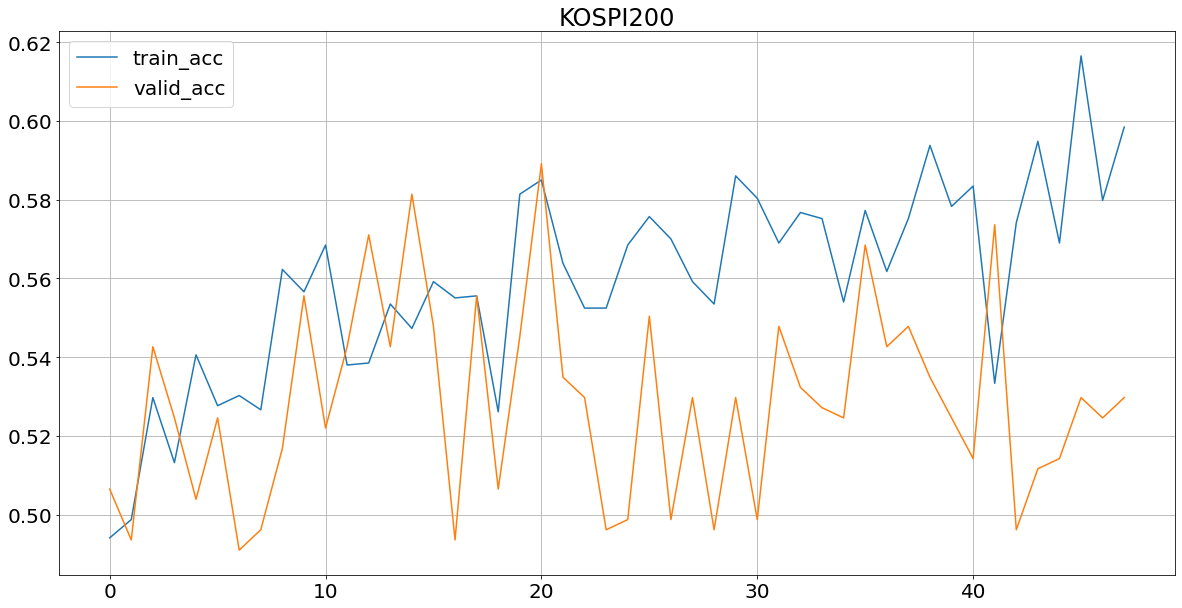

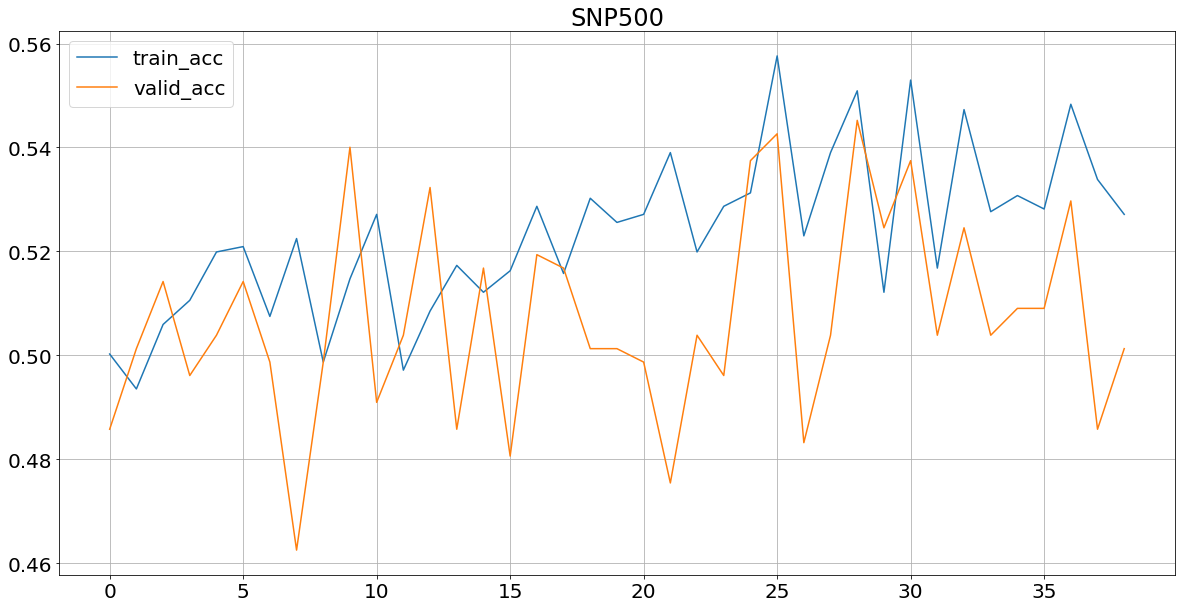

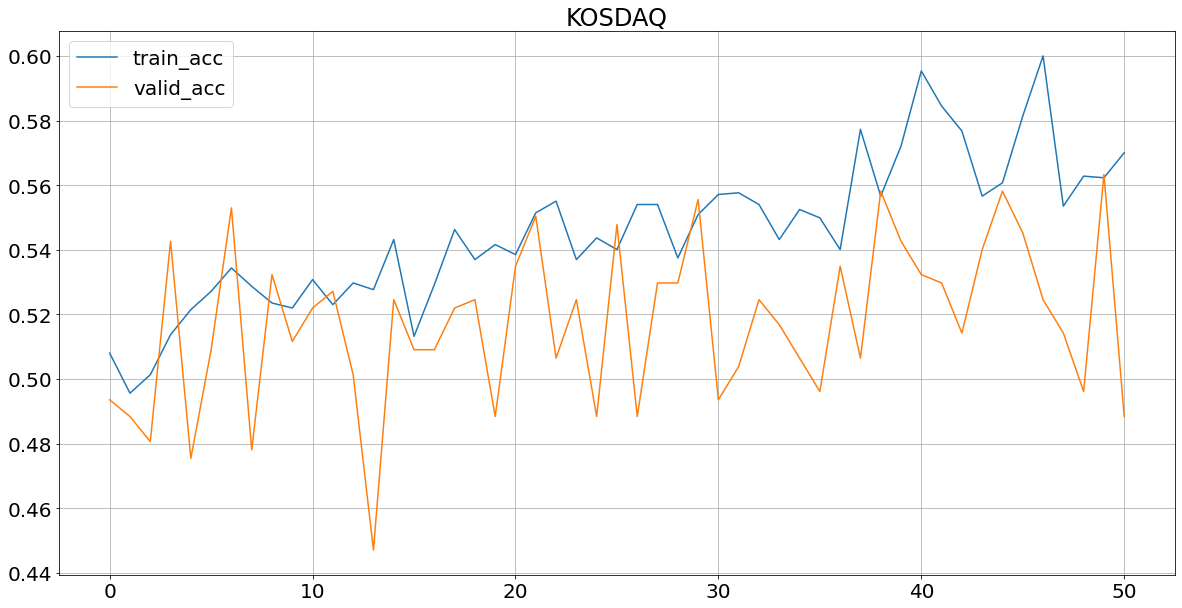

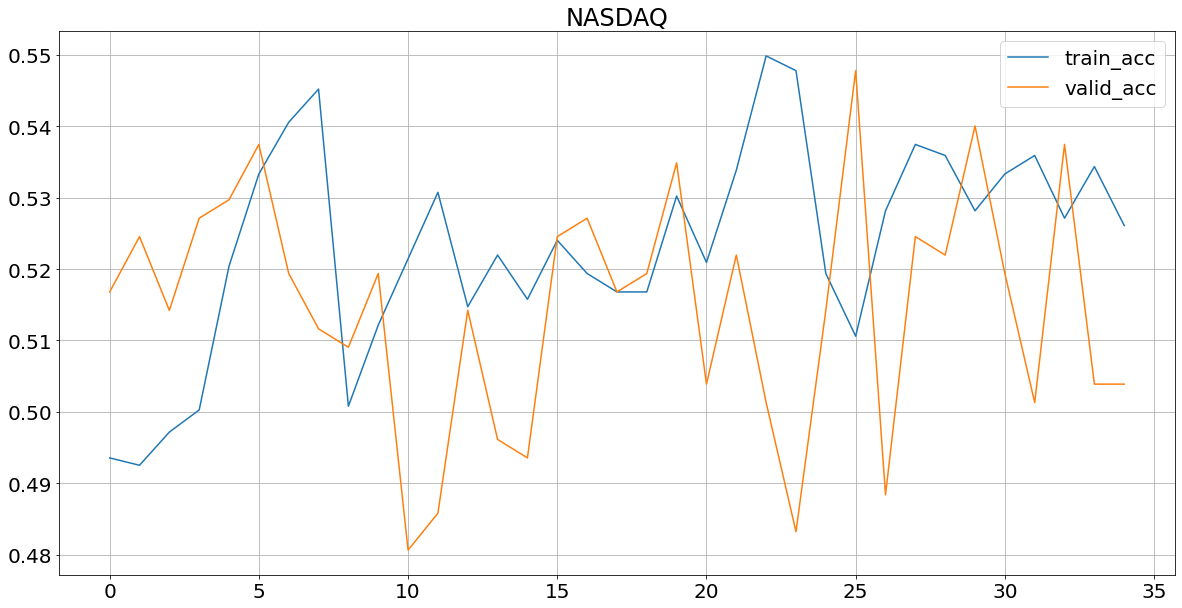

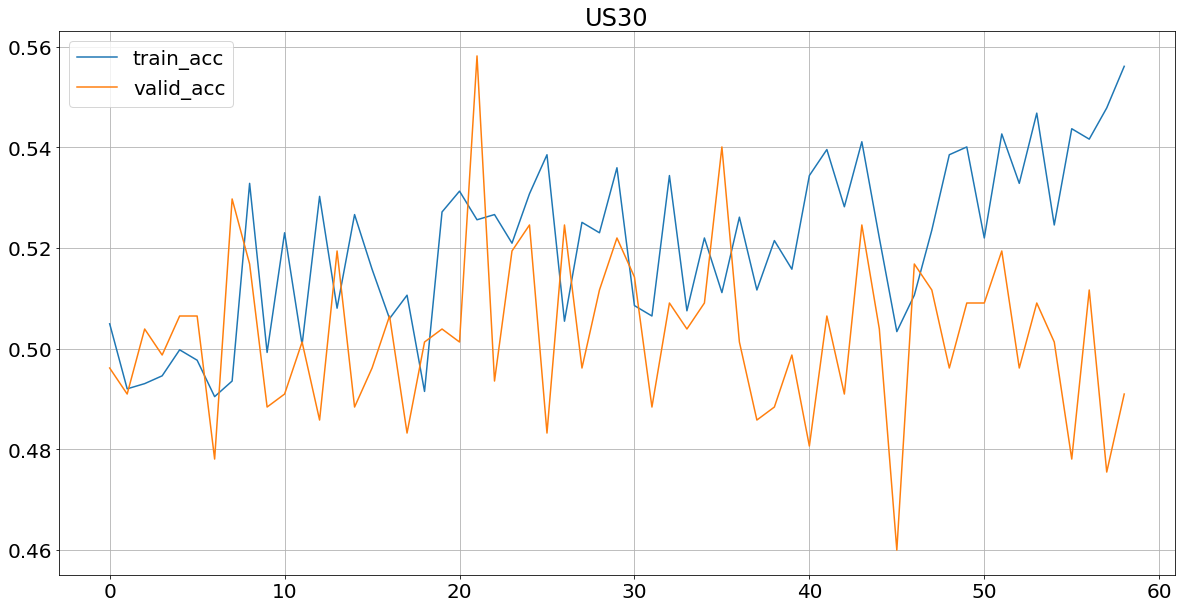

In [297]:
plot_acc('KOSPI200',KOSPI200_train_acc,KOSPI200_valid_acc)
plot_acc('SNP500',SNP500_train_acc,SNP500_valid_acc)
plot_acc('KOSDAQ',KOSDAQ_train_acc,KOSDAQ_valid_acc)
plot_acc('NASDAQ',NASDAQ_train_acc,NASDAQ_valid_acc)
plot_acc('US30',US30_train_acc,US30_valid_acc)

In [298]:
KOSPI200_test_loader = DataLoader(KOSPI200_test_set,batch_size=len(KOSPI200_test_set),num_workers=0)
SNP500_test_loader = DataLoader(SNP500_test_set,batch_size=len(SNP500_test_set),num_workers=0)
KOSDAQ_test_loader = DataLoader(KOSDAQ_test_set,batch_size=len(KOSDAQ_test_set),num_workers=0)
NASDAQ_test_loader = DataLoader(NASDAQ_test_set,batch_size=len(NASDAQ_test_set),num_workers=0)
US30_test_loader = DataLoader(US30_test_set,batch_size=len(US30_test_set),num_workers=0)

In [299]:
def eval_model(stock_name,model_name,loader):
    ensemble_pred = []
    for i in range(5):
        device = ('cuda' if torch.cuda.is_available() else 'cpu')
        model = torch.load(f'./{stock_name}_{model_name}_{i}.pt')
        model.to(device)
        model.eval()
        with torch.no_grad():
            for data in loader:
                data = data.to(device).float() 
                pred = model(data).detach().cpu().numpy()
                ensemble_pred.append(pred)
    pred = np.mean(ensemble_pred,axis=0)
    return pred

# CNN2GRU_eval

In [300]:
deep_KOSPI200_pred = eval_model('KOSPI200','CNN2GRU',KOSPI200_test_loader)
deep_SNP500_pred = eval_model('SNP500','CNN2GRU',SNP500_test_loader)
deep_KOSDAQ_pred = eval_model('KOSDAQ','CNN2GRU',KOSDAQ_test_loader)
deep_NASDAQ_pred = eval_model('NASDAQ','CNN2GRU',NASDAQ_test_loader)
deep_US30_pred = eval_model('US30','CNN2GRU',US30_test_loader)

# Ensemble

In [301]:
Deep_KOSPI200_pred = make_datetime(deep_KOSPI200_pred)
Deep_SNP500_pred = make_datetime(deep_SNP500_pred)
Deep_KOSDAQ_pred = make_datetime(deep_KOSDAQ_pred)
Deep_NASDAQ_pred = make_datetime(deep_NASDAQ_pred)
Deep_US30_pred = make_datetime(deep_US30_pred)

In [302]:
KOSPI200_ensemble = (Deep_KOSPI200_pred+ML_KOSPI200_pred)/2
SNP500_ensemble = (Deep_SNP500_pred+ML_SNP500_pred)/2
KOSDAQ_ensemble = (Deep_KOSDAQ_pred+ML_KOSDAQ_pred)/2
NASDAQ_ensemble = (Deep_NASDAQ_pred+ML_NASDAQ_pred)/2
US30_ensemble = (Deep_US30_pred+ML_US30_pred)/2

In [303]:
def indices_binarizer(target,prediction):
    target_result = []
    prediction_result = []
    for i,indices in enumerate(target.Close):
        if i == 0:
            target_result.append(0)
            data = indices
        if indices >= data:
            pred = 1
            target_result.append(pred)
            data = indices
        if indices < data:
            pred = 0
            target_result.append(pred)
            data = indices
    for i,indices in enumerate(prediction.pred):
        if i == 0:
            prediction_result.append(0)
            pred_data = indices
        if indices >= data:
            pred = 1
            prediction_result.append(pred)
            pred_data = indices
        if indices < data:
            pred = 0
            prediction_result.append(pred)
            pred_data = indices
    return target_result, prediction_result

In [304]:
def print_result(pred):
    pred = pred.reset_index()
    high = pred.pred.max()
    low = pred.pred.min()
    for i in pred.values:
        if high == i[1:2]:
            high_date = i[:1]
        elif low == i[1:2]:
            low_date = i[:1]
        else:
            pass
    if high_date < low_date:
        return print(f'You have short position {high_date} may be Price:{high}\nsell position in {low_date} may be price:{low}')
    elif high_date > low_date:
        return print(f'You have long position {low_date} may be Price:{low}\nsell position in {high_date} may be price:{high}')
    else:
        pass

# Plot result

In [305]:
def final_plot_result(stock_name,real_indices,pred,ensemble_pred):
    plt.figure(figsize=(20,10))
    plt.rc('font',size=20)
    plt.title(stock_name)
    plt.plot(pred,ls='-.',label='prediction_Indices',color='black')
    plt.plot(real_indices,label='real_Indices',color='red')
    plt.plot(ensemble_pred,label='ML+DL',ls='-.',color='blue')
    plt.legend(loc='lower right')
    plt.grid()
    return plt.show()

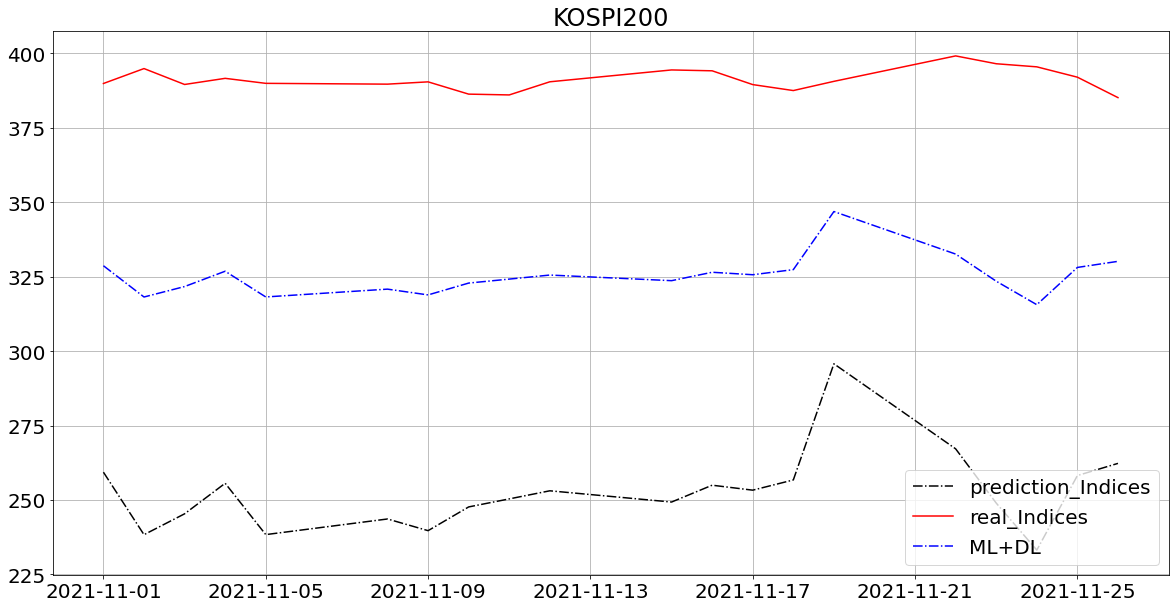

In [306]:
final_plot_result('KOSPI200',real_KOSPI200,Deep_KOSPI200_pred,KOSPI200_ensemble)

In [307]:
print_result(Deep_KOSPI200_pred)

You have short position [Timestamp('2021-11-19 00:00:00')] may be Price:295.71612548828125
sell position in [Timestamp('2021-11-24 00:00:00')] may be price:233.1806182861328


In [308]:
KOSPI200_binary,KOSPI200_binary_pred = indices_binarizer(real_KOSPI200,Deep_KOSPI200_pred)
print(f'Accuracy score:{accuracy_score(KOSPI200_binary,KOSPI200_binary_pred,)}')

Accuracy score:0.6190476190476191


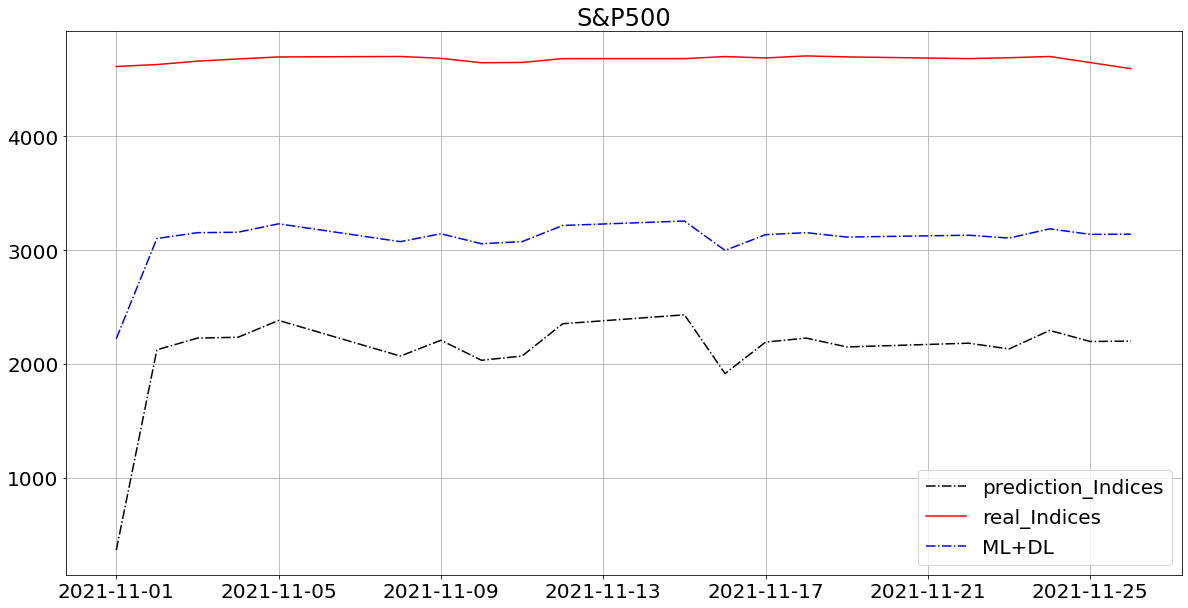

In [309]:
final_plot_result('S&P500',real_SNP500,Deep_SNP500_pred,SNP500_ensemble)

In [310]:
print_result(Deep_SNP500_pred)

You have long position [Timestamp('2021-11-01 00:00:00')] may be Price:364.1866149902344
sell position in [Timestamp('2021-11-15 00:00:00')] may be price:2431.563232421875


In [311]:
SNP500_binary,SNP500_binary_pred= indices_binarizer(real_SNP500,Deep_SNP500_pred.drop(Deep_SNP500_pred.index[18]))
print(f'Accuracy score:{accuracy_score(SNP500_binary,SNP500_binary_pred)}')

Accuracy score:0.4


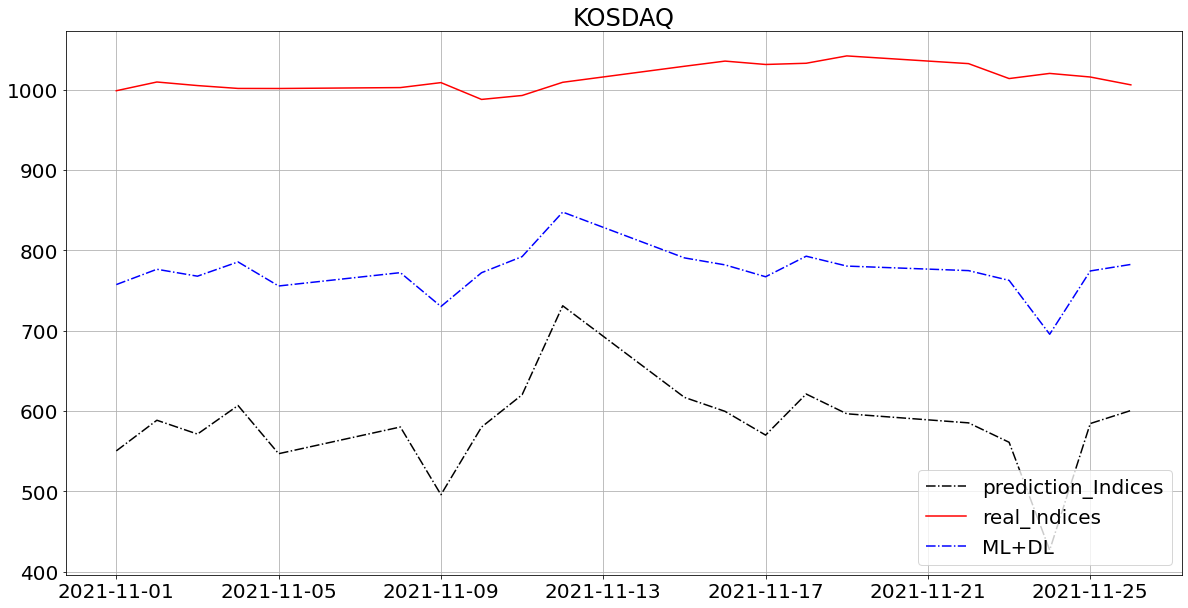

In [312]:
final_plot_result('KOSDAQ',real_KOSDAQ,Deep_KOSDAQ_pred,KOSDAQ_ensemble)

In [313]:
print_result(Deep_KOSDAQ_pred)

You have short position [Timestamp('2021-11-12 00:00:00')] may be Price:730.8834838867188
sell position in [Timestamp('2021-11-24 00:00:00')] may be price:426.75396728515625


In [314]:
KOSDAQ_binary,KOSDAQ_binary_pred  = indices_binarizer(real_KOSDAQ,Deep_KOSDAQ_pred)
print(f'Accuracy score:{accuracy_score(KOSDAQ_binary,KOSDAQ_binary_pred)}')

Accuracy score:0.47619047619047616


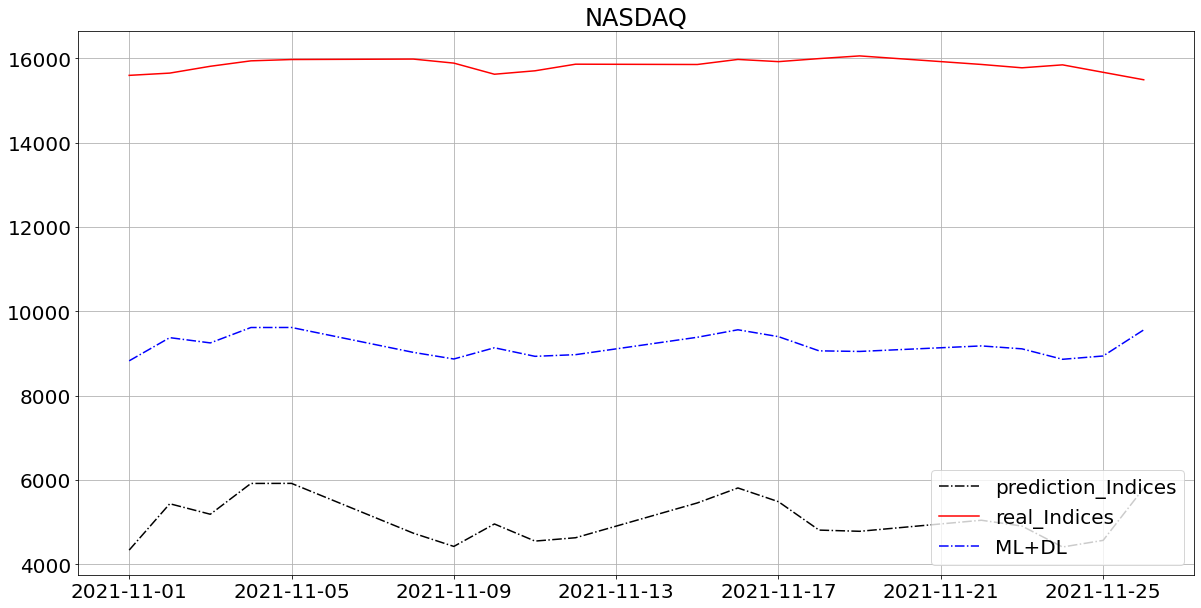

In [315]:
final_plot_result('NASDAQ',real_NASDAQ,Deep_NASDAQ_pred,NASDAQ_ensemble)

In [316]:
print_result(Deep_NASDAQ_pred)

You have long position [Timestamp('2021-11-01 00:00:00')] may be Price:4334.1318359375
sell position in [Timestamp('2021-11-05 00:00:00')] may be price:5916.7021484375


In [317]:
NASDAQ_binary,NASDAQ_binary_pred = indices_binarizer(real_NASDAQ,Deep_NASDAQ_pred.drop(Deep_NASDAQ_pred.index[18]))
print(f'Accuracy score:{accuracy_score(NASDAQ_binary,NASDAQ_binary_pred)}')

Accuracy score:0.4


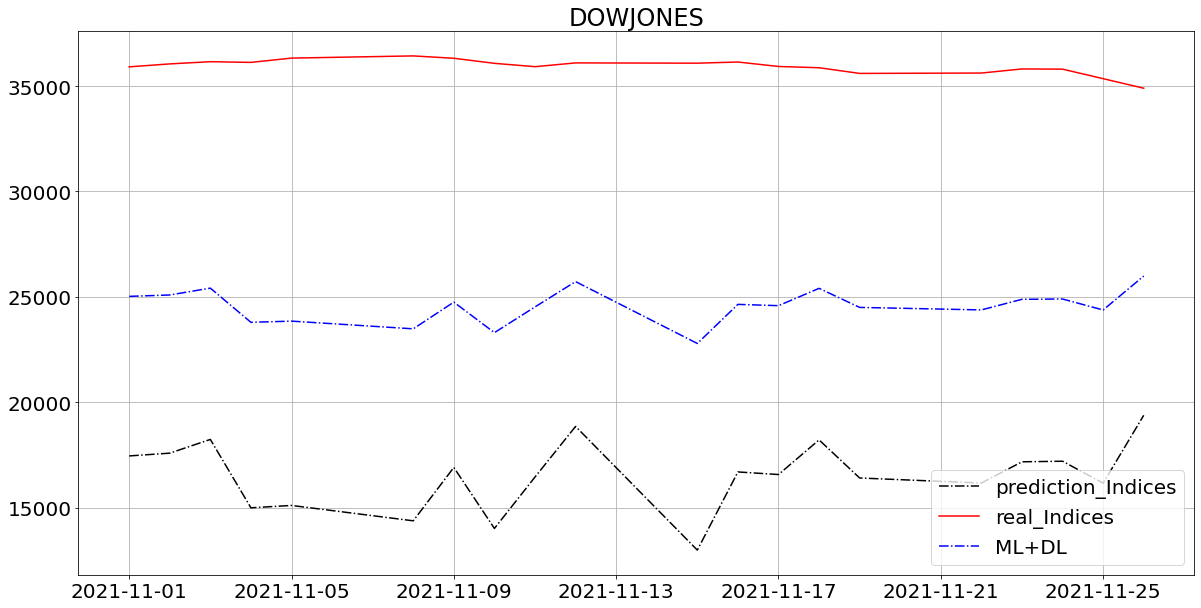

In [318]:
final_plot_result('DOWJONES',real_US30,Deep_US30_pred,US30_ensemble)

In [319]:
print_result(Deep_US30_pred)

You have long position [Timestamp('2021-11-15 00:00:00')] may be Price:12982.052734375
sell position in [Timestamp('2021-11-26 00:00:00')] may be price:19378.44921875


In [320]:
US30_binary,US30_binary_pred = indices_binarizer(real_US30,Deep_US30_pred.drop(Deep_US30_pred.index[18]))
print(f'Accuracy score:{accuracy_score(US30_binary,US30_binary_pred)}')

Accuracy score:0.55


#### Result
* 위의 딥러닝 모델을 사용하였을 경우 20일을 기준으로 지수(Indices)를 예측하여서 가장 높은가격의 날과 가장 낮은 가격의 날을 추출해서 Long(공매수) , Short(공매도)을 이용하였을때 자동투자를 하면 좋은 결과를 낼 수 잇을것 같다.
* 하지만 아직 모델이 정확하게 예측을 하지 못하는 것을 볼 수 있는데, 이 부분은 데이터를 더욱 증대를 해서 훈련을 시키거나, 모델의 레이어와 하이퍼파라미터 수정이 필요하것 같다.